In [1]:
%pylab inline

from __future__ import (division, print_function)

import os
import sys
import copy
import fnmatch
import warnings
import collections

import numpy as np
import scipy
try:
    from scipy.stats import scoreatpercentile
except:
    scoreatpercentile = False
from scipy.interpolate import interp1d
import cPickle as pickle

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.utils.console import ProgressBar

# AstroML
from astroML.plotting import hist

# Matplotlib related
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator
# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 2.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 2.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 2.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 2.5

# Personal
import hscUtils as hUtil
import galSBP
import coaddCutoutGalfitSimple as gSimple 

import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

import cosmology
c=cosmology.Cosmo(H0=70.0, omega_m=0.3, omega_l=0.7, flat=1)

# Color map 
from palettable.colorbrewer.sequential import Oranges_4
ORG4 = Oranges_4.mpl_colormap

from astropy.modeling.models import Sersic1D
#s1 = Sersic1D(amplitude=1, r_eff=18, n=10)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# Absolute magnitude of sun in HSC filters

# Actuall borrowed from DES filters
# Values from magsun.data in FSPS
amag_sun_des_g = 5.08
amag_sun_des_r = 4.62
amag_sun_des_i = 4.52
amag_sun_des_z = 4.52
amag_sun_des_y = 4.51

# Based on http://www.baryons.org/ezgal/filters.php
amag_sun_ukiss_y = 4.515

# Extinction correction factor for HSC 
## A\_lambda = Coeff * E(B-V) 

a_hsc_g = 3.233
a_hsc_r = 2.291 
a_hsc_i = 1.635
a_hsc_z = 1.261
a_hsc_y = 1.076

# 
SIGMA1 = 0.3173
SIGMA2 = 0.0455
SIGMA3 = 0.0027

RSMA_COMMON = np.arange(0.4, 4.2, 0.02)

In [239]:
# Code for Get Bootstrap mean or median 
def _confidence_interval_1d(A, alpha=.05, metric=np.mean, numResamples=10000, interpolate=True):
    """Calculates bootstrap confidence interval along one dimensional array"""
    
    if not isinstance(alpha, collections.Iterable):
        alpha = np.array([alpha])

    N = len(A)
    resampleInds = np.random.randint(0, N, (numResamples,N))
    metricOfResampled = metric(A[resampleInds], axis=-1)

    confidenceInterval = np.zeros(2*len(alpha),dtype='float')
    
    if interpolate:
        for thisAlphaInd, thisAlpha in enumerate(alpha):
            confidenceInterval[2*thisAlphaInd] = scoreatpercentile(metricOfResampled, 
                                                                   thisAlpha*100/2.0)
            confidenceInterval[2*thisAlphaInd+1] = scoreatpercentile(metricOfResampled, 
                                                                     100-thisAlpha*100/2.0)
    else:
        sortedMetricOfResampled = np.sort(metricOfResampled)
        for thisAlphaInd, thisAlpha in enumerate(alpha):
            confidenceInterval[2*thisAlphaInd] = sortedMetricOfResampled[int(round(thisAlpha*numResamples/2.0))]
            confidenceInterval[2*thisAlphaInd+1] = sortedMetricOfResampled[int(round(numResamples - 
                                                                                     thisAlpha*numResamples/2.0))]
    return confidenceInterval
    
def _ma_confidence_interval_1d(A, alpha=.05, metric=np.mean, numResamples=10000, interpolate=True):
    A = np.ma.masked_invalid(A, copy=True)
    A = A.compressed()
    confidenceInterval = _confidence_interval_1d(A, alpha, metric, numResamples, interpolate)
    return confidenceInterval

def confidence_interval(A, axis=None, alpha=.05, metric=np.mean, numResamples=10000, interpolate=True):
    """Return the bootstrap confidence interval of an array or along an axis ignoring NaNs and masked elements.
    
    Parameters
    ----------
    A : array_like
        Array containing numbers whose confidence interval is desired. 
    axis : int, optional
        Axis along which the confidence interval is computed.
        The default is to compute the confidence interval of the flattened array.
    alpha: float or array, optional
        confidence level of confidence interval. 100.0*(1-alpha) percent confidence 
        interval will be returned.
        If length-n array, n confidence intervals will be computed
        The default is .05
    metric : numpy function, optional
        metric to calculate confidence interval for.
        The default is numpy.mean
    numResamples : int, optional
        number of bootstrap samples. The default is 10000.
    interpolate: bool, optional
        uses scipy.stats.scoreatpercentile to interpolate between bootstrap samples 
        if alpha*numResamples/2.0 is not integer.
        The default is True
        
    Returns
    -------
    confidenceInterval : ndarray
    An array with the same shape as `A`, with the specified axis replaced by one twice the length of the alpha
    If `A` is a 0-d array, or if axis is None, a length-2 ndarray is returned.
    """
    if interpolate is True and scoreatpercentile is False:
        print("need scipy to interpolate between values")
        interpolate = False
    A = A.copy()
    if axis is None:
        A = A.ravel()
        outA = _ma_confidence_interval_1d(A, alpha, metric, numResamples, interpolate)
    else:
        outA = np.apply_along_axis(_ma_confidence_interval_1d, axis, A, alpha, 
                                   metric, numResamples, interpolate)
        
    return outA

def normProf(sma, sbp, minSma, maxSma, divide=False): 
    """
    Naive method to normalize the profile. 
    
    Parameters: 
        sbp    : Array for surface brightness profile 
        sma    : Radius range 
        minSma : Minimum SMA
        maxSma   Maximum SMA
    """
    offset = np.nanmedian(sbp[(sma >= minSma) & 
                              (sma <= maxSma)])
    if divide: 
        return (sbp / offset)
    else:
        return (sbp-offset)
    
    
def pixKpc(redshift, pix=0.168, show=True, npix=1.0):
    """
    Get the corresponding Kpc size of a pixel.  
    
    Parameters: 
    """
    pixKpc = pix * npix * hUtil.cosmoScale(redshift)

    if show:
        print("# %d pixel(s) = %6.3f Kpc" % (npix, pixKpc))
        
    return pixKpc


def logAdd(para1, para2):
    """ Useful for adding magnitudes. """
    return np.log10((10.0 ** np.asarray(para1)) + 
                    (10.0 ** np.asarray(para2)))


def errAdd(err1, err2):
    """Add error quadral..."""
    return np.sqrt((err1 ** 2.0) + 
                   (err2 ** 2.0))


def toColorArr(data, bottom=None, top=None):
    """ 
    Convert a data array to "color array" (between 0 and 1). 
    
    Parameters:
        bottom, top  : 
    """
    if top is not None:
        data[data >= top] = top
    if bottom is not None:
        data[data <= bottom] = bottom
        
    return ((data - np.nanmin(data)) / 
            (np.nanmax(data) - np.nanmin(data))) * 255.0


def getLuminosity(mag, redshift, extinction=None, 
                  amag_sun=None):
    """Get the absolute magnitude or luminosity."""
    distmod = hUtil.cosmoDistMod(redshift)
    absMag = (mag - distmod)
    if extinction is not None: 
        absMag -= extinction 
    if amag_sun is not None: 
        absMag = ((amag_sun - absMag) / 2.5)
    
    return absMag

def getStackProfiles(sample, loc, name='GAMA', 
                     idCol='ID_USE', tabCol='sum_tab', save=True):
    """Get the stacks of the profiles."""
    print("## Sample %s : Will deal with %d galaxies" % (name, len(sample)))
    profiles = []
    with ProgressBar(len(sample), ipython_widget=True) as bar:
        for g in sample:
            try:
                gFile = os.path.join(loc, g['sum_tab'].replace('./', '')).strip()
                gProf = Table.read(gFile, format='fits')
                """ Add extra information """
                try: 
                    gProf.meta['KCORRECT_I'] = g['KCORRECT_I']
                    gProf.meta['KCORRECT_b_I'] = g['KCORRECT_b_I']
                    gProf.meta['KCORRECT_c_I'] = g['KCORRECT_c_I']
                    gProf.meta['KCORRECT_G'] = g['KCORRECT_G']
                    gProf.meta['KCORRECT_b_G'] = g['KCORRECT_b_G']
                    gProf.meta['KCORRECT_c_G'] = g['KCORRECT_c_G']
                    gProf.meta['KCORRECT_R'] = g['KCORRECT_R']
                    gProf.meta['KCORRECT_b_R'] = g['KCORRECT_b_R']
                    gProf.meta['KCORRECT_c_R'] = g['KCORRECT_c_R']
                    gProf.meta['KCORRECT_Z'] = g['KCORRECT_Z']
                    gProf.meta['KCORRECT_b_Z'] = g['KCORRECT_b_Z']
                    gProf.meta['KCORRECT_c_Z'] = g['KCORRECT_c_Z']
                    gProf.meta['KCORRECT_Y'] = g['KCORRECT_Y']
                    gProf.meta['KCORRECT_b_Y'] = g['KCORRECT_b_Y']
                    gProf.meta['KCORRECT_c_Y'] = g['KCORRECT_c_Y']
                    gProf.meta['LOGM2LI_A'] = g['logm2lI_A']
                    gProf.meta['LOGM2LI_B'] = g['logm2lI_B']
                    gProf.meta['LOGM2LI_C'] = g['logm2lI_C']
                    gProf.meta['LUM_100'] = g['lum_100']
                    gProf.meta['LUM_120'] = g['lum_120']
                except Exception:
                    print("## WARNING: Some metadata may not be available !")
                    continue
            except Exception:
                print("## Missing: %s" % gFile)
                continue 
            profiles.append(gProf)
            bar.update()
    
    if save: 
        outPkl = os.path.join(loc, (name + '_profs.pkl'))
        hUtil.saveToPickle(profiles, outPkl)
        print("## Save %s to %s" % (name, outPkl))
        
    return profiles


def organizeSbp(profiles, col1='muI1', col2='KCORRECT_c_I', 
                kind='sbp', norm=False, r1=9.9, r2=10.1, divide=False,
                col3=None, col4=None, justStack=False,
                sun1=amag_sun_des_g, sun2=amag_sun_des_r,
                index=None):
    """ Get the stack of individual profiels, and their med/avg. """
    if kind.strip() == 'sbp':
        if col2 is not None: 
            if norm:
                stack = np.vstack(normProf(p['rKpc'], 
                                           np.asarray(p[col1] + (p.meta[col2] / 2.5)), 
                                           r1, r2, divide=divide) 
                                  for p in profiles)
            else:
                stack = np.vstack(np.asarray(p[col1] + (p.meta[col2] / 2.5)) 
                                  for p in profiles)
        else: 
            print("## NO KCORRECTION APPLIED !!")            
            if norm:
                stack = np.vstack(normProf(p['rKpc'], p[col1], 
                                           r1, r2, divide=divide) 
                                  for p in profiles)
            else:
                stack = np.vstack(np.asarray(p[col1]) for p in profiles)
    elif kind.strip() == 'mass':
        if norm:
            stack = np.vstack(normProf(p['rKpc'], 
                                       np.asarray(p[col1] + p.meta[col2]), 
                                       r1, r2, divide=divide) for p in profiles)
        else: 
            stack = np.vstack(np.asarray(p[col1] + p.meta[col2]) for p in profiles)
    elif kind.strip() == 'color':
        cSun = (sun1 - sun2)
        if col3 is None or col4 is None:
            print("## NO KCORRECTION APPLIED !!")
            if norm:
                stack = np.vstack(normProf(p['rKpc'], 
                                           np.asarray(cSun - 2.5 * (p[col1] - p[col2])), 
                                           r1, r2, divide=divide) for p in profiles)
            else: 
                stack = np.vstack(np.asarray(cSun - 2.5 *(p[col1] - p[col2])) for p in profiles)
        else:
            if norm:
                stack = np.vstack(normProf(p['rKpc'], 
                                           np.asarray(cSun - 2.5 * (p[col1] - p[col2]) -
                                                      (p.meta[col3] - p.meta[col4])), 
                                           r1, r2, divide=divide) for p in profiles)
            else: 
                stack = np.vstack(np.asarray(cSun - 2.5 * (p[col1] - p[col2]) -
                                             (p.meta[col3] - p.meta[col4])) 
                                  for p in profiles)
    elif kind.strip() == 'lum':
        if col2 is None:
            stack = np.vstack(np.asarray(p[col1]) for p in profiles)
        else:
            stack = np.vstack(np.asarray(p[col1] - p.meta[col2]) for p in profiles)
    else: 
        raise Exception("## WRONG KIND !!")
        
    if index is not None: 
        stack = np.vstack(p[index] for p in stack)
        
    if not justStack:
        """ Get the median and 1-sigma confidence range """
        medProf = confidence_interval(stack, axis=0, alpha=np.asarray([SIGMA1, 1.0]), 
                                      metric=np.nanmedian, numResamples=1000, 
                                      interpolate=True) 
        avgProf = confidence_interval(stack, axis=0, alpha=np.asarray([SIGMA1, 1.0]), 
                                      metric=np.nanmean, numResamples=1000, 
                                      interpolate=True) 
        stdProf = confidence_interval(stack, axis=0, alpha=np.asarray([SIGMA1, 1.0]), 
                                      metric=np.nanstd, numResamples=1000, 
                                      interpolate=True) 
        return stack, medProf, avgProf, stdProf
    else: 
        return stack
    

def loadPkl(filename):
    try:
        import cPickle as pickle
    except:
        warnings.warn("## cPickle is not available!!")
        import pickle
    
    if os.path.isfile(filename):
        pklFile = open(filename, 'rb')
        data = pickle.load(pklFile)    
        pklFile.close()
    
        return data
    else: 
        warnings.warn("## Can not find %s, return None" % filename)
        return None

In [4]:
newDir = '/Users/songhuang/work/hscs/gama_massive/sbp/'

bcgFile = 'redbcg_1d_160211.fits'
memFile = 'redmem_1d_160211.fits'
gamaFile = 'gama_1d_160211.fits'

try:
    bcgTab
except NameError:
    pass
else:
    del bcgTab
    
try:
    memTab
except NameError:
    pass
else:
    del memTab    
    
try:
    gamaTab
except NameError:
    pass
else:
    del gamaTab
    
#
bcgDir = os.path.join(newDir, 'redbcg')
memDir = os.path.join(newDir, 'redmem')
gamaDir = os.path.join(newDir, 'gama')

# Two summary catalogs
bcgCat = os.path.join(newDir, bcgFile)
memCat = os.path.join(newDir, memFile)
gamaCat = os.path.join(newDir, gamaFile)

if not os.path.isfile(bcgCat):
    raise Exception("## Can not find catalog for BCGs : %s" % bcgCat)
else: 
    bcgTab = Table.read(bcgCat, format='fits')

if not os.path.isfile(memCat):
    raise Exception("## Can not find catalog for cluster members : %s" % memCat)
else: 
    memTab = Table.read(memCat, format='fits')
    
if not os.path.isfile(gamaCat):
    raise Exception("## Can not find catalog for GAMA galaxies : %s" % gamaCat)
else: 
    gamaTab = Table.read(gamaCat, format='fits')
    
print("## Deal with %i galaxies in redBCH sample" % len(bcgTab))
print("## Deal with %i galaxies in redMEM sample" % len(memTab))
print("## Deal with %i galaxies in GAMA sample" % len(gamaTab))

## Deal with 219 galaxies in redBCH sample
## Deal with 1670 galaxies in redMEM sample
## Deal with 9212 galaxies in GAMA sample


# Get a "Clean" GAMA sample 

In [636]:
bcgClean = bcgTab[(bcgTab['m100_c'] >= 10.0) & 
                  (bcgTab['c82_120'] <= 14.0) &
                  (bcgTab['r90_max'] <= 220.0) &
                  (bcgTab['P_CEN_1'] >= 0.8)]
print(len(bcgClean))

gamaClean = gamaTab[(gamaTab['c82_120'] >= 5.5) & 
                    (gamaTab['c82_120'] <= 14.0) &
                    (gamaTab['gz_kC'] >= 1.52) &
                    (gamaTab['ur_rest_sed'] >= 2.1) & 
                    (gamaTab['m100_c'] >= 10.0) &
                    (gamaTab['r90_max'] <= 160.0) &
                    ((gamaTab['r50_120'] - gamaTab['r20_120']) >= 
                     (32.0 * (gamaTab['m30_c'] - gamaTab['m10_c']) - 1.4) )]

print(len(gamaClean))

memClean = memTab[(memTab['c82_120'] >= 5.0) &
                  (memTab['c82_120'] <= 14.0) &
                  (memTab['gz_kC'] >= 1.5) &
                  (memTab['ur_rest_sed'] >= 1.9) & 
                  (memTab['m100_c'] >= 10.0) &
                  (memTab['r90_max'] <= 160.0)]

print(len(memClean))

130
3753
262


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in greater_equal


In [700]:
gamaUse = gamaClean[(gamaClean['z_use'] >= 0.20) &
                    (gamaClean['z_use'] <= 0.50)]
print(len(gamaUse))

memUse = memClean[(memClean['z_use'] >= 0.20) &
                  (memClean['z_use'] <= 0.50)]
print(len(memUse))

bcgUse = bcgClean[(bcgClean['z_use'] >= 0.20) &
                  (bcgClean['z_use'] <= 0.50) &
                  (bcgClean['LAMBDA_CLUSTER'] >= 30.0)]
print(len(bcgUse))

3270
262
61


In [772]:
print("########################################################\n")
#gamaM1 = gamaClean[(gamaClean['m100_c'] >= 11.56) & 
#                   (gamaClean['m100_c'] < 11.70) &
#                   (gamaClean['Z'] >= 0.20) &
#                   (gamaClean['Z'] <= 0.40)]
#gamaM2 = gamaClean[(gamaClean['m100_c'] >= 11.72) & 
#                   (gamaClean['m100_c'] < 11.95) &
#                   (gamaClean['Z'] >= 0.20) &
#                   (gamaClean['Z'] <= 0.50)]
gamaM1 = gamaClean[(gamaClean['m100_c'] >= 11.55) & 
                   (gamaClean['m100_c'] < 11.70) &
                   (gamaClean['z_use'] >= 0.20) &
                   (gamaClean['z_use'] <= 0.50)]

gamaM2 = gamaClean[(gamaClean['m100_c'] >= 11.72) & 
                   (gamaClean['m100_c'] < 11.92) &
                   (gamaClean['z_use'] >= 0.20) &
                   (gamaClean['z_use'] <= 0.50)]

gamaM2b = gamaClean[(gamaClean['m100_c'] >= 11.71) & 
                    (gamaClean['m100_c'] < 12.00) &
                    (gamaClean['z_use'] >= 0.20) &
                    (gamaClean['z_use'] <= 0.50)]

print(len(gamaM1), np.nanmedian(gamaM1['m100_c']), np.nanmedian(gamaM1['z_use']))
print(len(gamaM2), np.nanmedian(gamaM2['m100_c']), np.nanmedian(gamaM2['z_use']))
print(len(gamaM2b), np.nanmedian(gamaM2b['m100_c']), np.nanmedian(gamaM2b['z_use']))

print("########################################################\n")
memM1 = memClean[(memClean['m100_c'] >= 11.55) & 
                 (memClean['m100_c'] < 11.70) &
                 (memClean['z_use'] >= 0.20) &
                 (memClean['z_use'] <= 0.50)]

memM2 = memClean[(memClean['m100_c'] >= 11.70) & 
                 (memClean['m100_c'] < 11.90) &
                 (memClean['z_use'] >= 0.20) &
                 (memClean['z_use'] <= 0.50)]

print(len(memM1), np.nanmedian(memM1['m100_c']), np.nanmedian(memM1['Z']))
print(len(memM2), np.nanmedian(memM2['m100_c']), np.nanmedian(memM2['Z']))

print("########################################################\n")
#bcgM1 = bcgClean[(bcgClean['m100_c'] >= 11.45) & 
#                 (bcgClean['m100_c'] < 11.68) &
#                 (bcgClean['Z'] >= 0.20) &
#                 (bcgClean['Z'] <= 0.40) &
#                 (bcgClean['P_CEN_1'] >= 0.8)]
#bcgM2 = bcgClean[(bcgClean['m100_c'] >= 11.70) & 
#                 (bcgClean['m100_c'] < 11.95) &
#                 (bcgClean['Z'] >= 0.20) &
#                 (bcgClean['Z'] <= 0.50) &
#                 (bcgClean['P_CEN_1'] >= 0.8) &
#                 (bcgClean['LAMBDA_CLUSTER'] >= 30.0)]

bcgM1 = bcgClean[(bcgClean['m100_c'] >= 11.50) & 
                 (bcgClean['m100_c'] < 11.70) &
                 (bcgClean['z_use'] >= 0.20) &
                 (bcgClean['z_use'] <= 0.50) &
                 (bcgClean['LAMBDA_CLUSTER'] >= 30.0)]

bcgM2 = bcgClean[(bcgClean['m100_c'] >= 11.70) & 
                 (bcgClean['m100_c'] < 11.90) &
                 (bcgClean['z_use'] >= 0.20) &
                 (bcgClean['z_use'] <= 0.50) &
                 (bcgClean['LAMBDA_CLUSTER'] >= 30.0)]

bcgM2b = bcgClean[(bcgClean['m100_c'] >= 11.70) & 
                  (bcgClean['m100_c'] < 12.00) &
                  (bcgClean['z_use'] >= 0.20) &
                  (bcgClean['z_use'] <= 0.50) &
                  (bcgClean['LAMBDA_CLUSTER'] >= 30.0)]

print(len(bcgM1), np.nanmedian(bcgM1['m100_c']), np.nanmedian(bcgM1['z_use']))
print(len(bcgM2), np.nanmedian(bcgM2['m100_c']), np.nanmedian(bcgM2['z_use']))
print(len(bcgM2b), np.nanmedian(bcgM2b['m100_c']), np.nanmedian(bcgM2b['z_use']))

########################################################

344 11.6145369275 0.313785016537
110 11.7779600455 0.326115012169
136 11.7752103684 0.325569987297
########################################################

23 11.6124132339 0.295269995928
8 11.7914296201 0.301265001297
########################################################

25 11.6166306229 0.372889995575
17 11.7717903835 0.343160003424
23 11.7784713081 0.352700233459


In [813]:
print("########################################################\n")
gamaCM1 = gamaClean[(gamaClean['m10_c'] >= 11.19) & 
                    (gamaClean['m10_c'] < 11.35) &
                    (gamaClean['Z'] >= 0.20) &
                    (gamaClean['Z'] <= 0.40)]

gamaCM1b = gamaCM1[(gamaCM1['c82_120'] >= 7.0) & 
                   (gamaCM1['r90_120'] / gamaCM1['r50_120'] >= 2.3) &
                   (gamaCM1['gz_kC'] >= 1.6) &
                   (gamaCM1['ur_rest_sed'] >= 2.2)]

gamaCM2 = gamaClean[(gamaClean['m10_c'] >= 11.35) & 
                    (gamaClean['m10_c'] < 11.55) &
                    (gamaClean['Z'] >= 0.20) &
                    (gamaClean['Z'] <= 0.40)]

print(len(gamaCM1), np.nanmedian(gamaCM1['m10_c']), 
      np.nanmedian(gamaCM1['Z']))
print(len(gamaCM2), np.nanmedian(gamaCM2['m10_c']), 
      np.nanmedian(gamaCM2['Z']))
print(len(gamaCM1b), np.nanmedian(gamaCM1b['m10_c']), 
      np.nanmedian(gamaCM1b['Z']))

print("########################################################\n")
memCM1 = memClean[(memClean['m10_c'] >= 11.18) & 
                  (memClean['m10_c'] < 11.35) &
                  (memClean['Z'] >= 0.20) &
                  (memClean['Z'] <= 0.40)]

memCM2 = memClean[(memClean['m10_c'] >= 11.35) & 
                  (memClean['m10_c'] < 11.55) &
                  (memClean['Z'] >= 0.20) &
                  (memClean['Z'] <= 0.50)]

print(len(memCM1), np.nanmedian(memCM1['m10_c']), 
      np.nanmedian(memCM1['Z']))
print(len(memCM2), np.nanmedian(memCM2['m10_c']), 
      np.nanmedian(memCM2['Z']))

print("########################################################\n")

bcgCM1 = bcgClean[(bcgClean['m10_c'] >= 11.15) & 
                  (bcgClean['m10_c'] < 11.34) &
                  (bcgClean['Z'] >= 0.20) &
                  (bcgClean['Z'] <= 0.40) &
                  (bcgClean['LAMBDA_CLUSTER'] >= 30.0)]

bcgCM1b = bcgClean[(bcgClean['m10_c'] >= 11.15) & 
                   (bcgClean['m10_c'] < 11.34) &
                   (bcgClean['m100_c'] <= 11.8) &
                   (bcgClean['Z'] >= 0.20) &
                   (bcgClean['Z'] <= 0.39)]

bcgCM2 = bcgClean[(bcgClean['m10_c'] >= 11.35) & 
                  (bcgClean['m10_c'] < 11.55) &
                  (bcgClean['Z'] >= 0.20) &
                  (bcgClean['Z'] <= 0.50) &
                  (bcgClean['LAMBDA_CLUSTER'] >= 30.0)]

print(len(bcgCM1), np.nanmean(bcgCM1['m10_c']), 
      np.nanmedian(bcgCM1['Z']))
print(len(bcgCM2), np.nanmean(bcgCM2['m10_c']), 
      np.nanmedian(bcgCM2['Z']))
print(len(bcgCM1b), np.nanmean(bcgCM1b['m10_c']), 
      np.nanmedian(bcgCM1b['Z']))

########################################################

676 11.2566042034 0.288484990597
189 11.3938409182 0.303299993277
475 11.2586784122 0.290289998055
########################################################

75 11.2348214615 0.293720006943
12 11.3840113988 0.28750500083
########################################################

15 11.2523061893 0.313470005989
13 11.4152549156 0.340429991484
27 11.2469846747 0.302599996328


In [705]:
gM1_mass = confidence_interval(gamaM1['m100_c'], axis=0, alpha=[SIGMA1, 1.0], 
                               metric=np.median, numResamples=1000, interpolate=True)
gCM1_mass = confidence_interval(gamaM1['m10_c'], axis=0, alpha=[SIGMA1, 1.0], 
                                metric=np.median, numResamples=1000, interpolate=True)
gM1_mdif1 = confidence_interval((gamaM1['lum_100'] - gamaM1['lum_10']), 
                                axis=0, alpha=[SIGMA1, 1.0], 
                                metric=np.median, numResamples=1000, interpolate=True)
gM1_mdif2 = confidence_interval((gamaM1['lum_75'] - gamaM1['lum_10']), 
                                axis=0, alpha=[SIGMA1, 1.0], 
                                metric=np.median, numResamples=1000, interpolate=True)
gM1_mdif3 = confidence_interval((gamaM1['lum_50'] - gamaM1['lum_10']), 
                                axis=0, alpha=[SIGMA1, 1.0], 
                                metric=np.median, numResamples=1000, interpolate=True)
gM1_mdif4 = confidence_interval((gamaM1['lum_25'] - gamaM1['lum_10']), 
                                axis=0, alpha=[SIGMA1, 1.0], 
                                metric=np.median, numResamples=1000, interpolate=True)
gM1_r20 = confidence_interval(gamaM1['r20_120'], axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)
gM1_r50 = confidence_interval(gamaM1['r50_120'], axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)
gM1_r90 = confidence_interval(gamaM1['r90_120'], axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)
gM1_c82 = confidence_interval(gamaM1['c82_120'], axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)
gM1_c52 = confidence_interval((gamaM1['r50_120'] / gamaM1['r20_120']), 
                              axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)

gM2_mass = confidence_interval(gamaM2['m100_c'], axis=0, alpha=[SIGMA1, 1.0], 
                               metric=np.median, numResamples=1000, interpolate=True)
gCM2_mass = confidence_interval(gamaM2['m10_c'], axis=0, alpha=[SIGMA1, 1.0], 
                                metric=np.median, numResamples=1000, interpolate=True)
gM2_mdif1 = confidence_interval((gamaM2['lum_100'] - gamaM2['lum_10']), 
                                axis=0, alpha=[SIGMA1, 1.0], 
                                metric=np.median, numResamples=1000, interpolate=True)
gM2_mdif2 = confidence_interval((gamaM2['lum_75'] - gamaM2['lum_10']), 
                                axis=0, alpha=[SIGMA1, 1.0], 
                                metric=np.median, numResamples=1000, interpolate=True)
gM2_mdif3 = confidence_interval((gamaM2['lum_50'] - gamaM2['lum_10']), 
                                axis=0, alpha=[SIGMA1, 1.0], 
                                metric=np.median, numResamples=1000, interpolate=True)
gM2_mdif4 = confidence_interval((gamaM2['lum_25'] - gamaM2['lum_10']), 
                                axis=0, alpha=[SIGMA1, 1.0], 
                                metric=np.median, numResamples=1000, interpolate=True)
gM2_r20 = confidence_interval(gamaM2['r20_120'], axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)
gM2_r50 = confidence_interval(gamaM2['r50_120'], axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)
gM2_r90 = confidence_interval(gamaM2['r90_120'], axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)
gM2_c82 = confidence_interval(gamaM2['c82_120'], axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)
gM2_c95 = confidence_interval((gamaM2['r50_120'] / gamaM2['r20_120']), 
                              axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)

In [706]:
bM1_mass = confidence_interval(bcgM1['m100_c'], axis=0, alpha=[SIGMA1, 1.0], 
                               metric=np.median, numResamples=1000, interpolate=True)
bCM1_mass = confidence_interval(bcgM1['m10_c'], axis=0, alpha=[SIGMA1, 1.0], 
                                metric=np.median, numResamples=1000, interpolate=True)
bM1_mdif1 = confidence_interval((bcgM1['lum_100'] - bcgM1['lum_10']), 
                               axis=0, alpha=[SIGMA1, 1.0], 
                               metric=np.median, numResamples=1000, interpolate=True)
bM1_mdif2 = confidence_interval((bcgM1['lum_75'] - bcgM1['lum_10']), 
                               axis=0, alpha=[SIGMA1, 1.0], 
                               metric=np.median, numResamples=1000, interpolate=True)
bM1_mdif3 = confidence_interval((bcgM1['lum_50'] - bcgM1['lum_10']), 
                               axis=0, alpha=[SIGMA1, 1.0], 
                               metric=np.median, numResamples=1000, interpolate=True)
bM1_mdif4 = confidence_interval((bcgM1['lum_25'] - bcgM1['lum_10']), 
                               axis=0, alpha=[SIGMA1, 1.0], 
                               metric=np.median, numResamples=1000, interpolate=True)
bM1_r20 = confidence_interval(bcgM1['r20_120'], axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)
bM1_r50 = confidence_interval(bcgM1['r50_120'], axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)
bM1_r90 = confidence_interval(bcgM1['r90_120'], axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)
bM1_c82 = confidence_interval(bcgM1['c82_120'], axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)
bM1_c52 = confidence_interval((bcgM1['r50_120'] / bcgM1['r20_120']), 
                              axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)

bM2_mass = confidence_interval(bcgM2['m100_c'], axis=0, alpha=[SIGMA1, 1.0], 
                               metric=np.median, numResamples=1000, interpolate=True)
bCM2_mass = confidence_interval(bcgM2['m10_c'], axis=0, alpha=[SIGMA1, 1.0], 
                                metric=np.median, numResamples=1000, interpolate=True)
bM2_mdif1 = confidence_interval((bcgM2['lum_100'] - bcgM2['lum_10']), 
                                axis=0, alpha=[SIGMA1, 1.0], 
                                metric=np.median, numResamples=1000, interpolate=True)
bM2_mdif2 = confidence_interval((bcgM2['lum_75'] - bcgM2['lum_10']), 
                                axis=0, alpha=[SIGMA1, 1.0], 
                                metric=np.median, numResamples=1000, interpolate=True)
bM2_mdif3 = confidence_interval((bcgM2['lum_50'] - bcgM2['lum_10']), 
                                axis=0, alpha=[SIGMA1, 1.0], 
                                metric=np.median, numResamples=1000, interpolate=True)
bM2_mdif4 = confidence_interval((bcgM2['lum_25'] - bcgM2['lum_10']), 
                                axis=0, alpha=[SIGMA1, 1.0], 
                                metric=np.median, numResamples=1000, interpolate=True)
bM2_r20 = confidence_interval(bcgM2['r20_120'], axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)
bM2_r50 = confidence_interval(bcgM2['r50_120'], axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)
bM2_r90 = confidence_interval(bcgM2['r90_120'], axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)
bM2_c82 = confidence_interval(bcgM2['c82_120'], axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)
bM2_c95 = confidence_interval((bcgM2['r50_120'] / bcgM2['r20_120']), 
                              axis=0, alpha=[SIGMA1, 1.0], 
                              metric=np.median, numResamples=1000, interpolate=True)

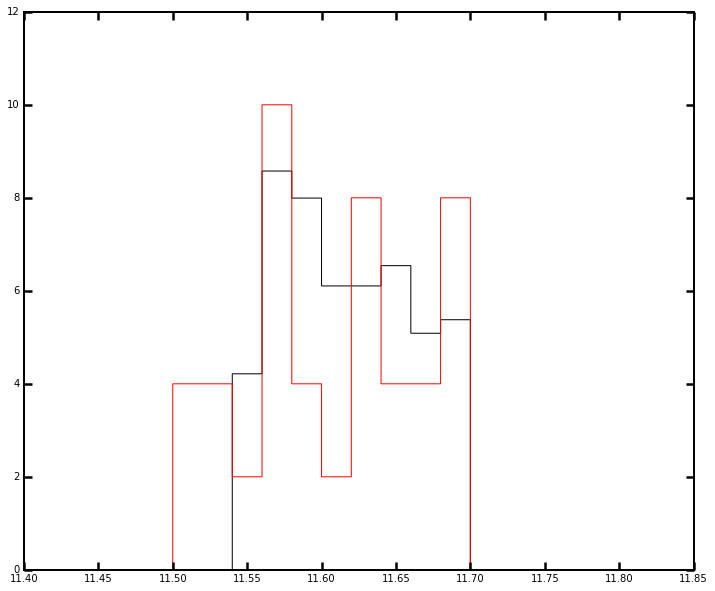

In [707]:
plt.hist(gamaM1['m100_c'], bins=20, range=[11.4, 11.8], color='k', 
         histtype='step', normed=1)
plt.hist(bcgM1['m100_c'], bins=20, range=[11.4, 11.8], color='r', 
         histtype='step', normed=1)
plt.show()

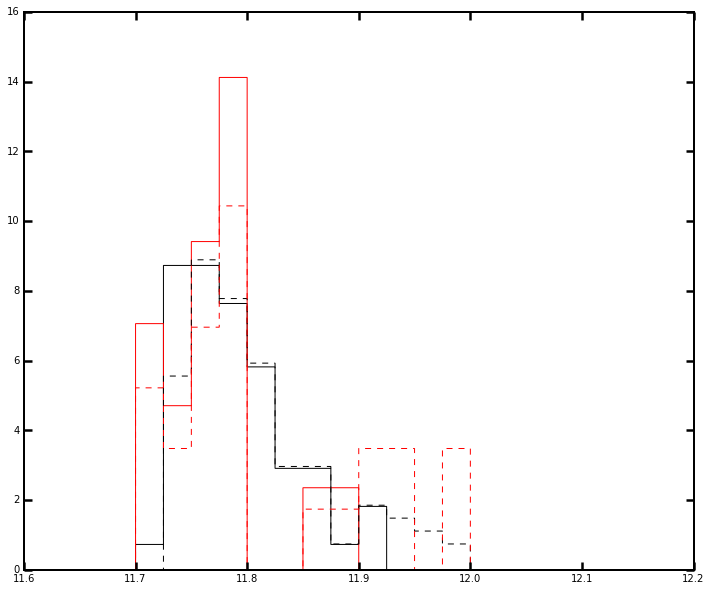

In [710]:
plt.hist(gamaM2['m100_c'], bins=20, range=[11.7, 12.2], color='k', 
         histtype='step', normed=1)
plt.hist(bcgM2['m100_c'], bins=20, range=[11.7, 12.2], color='r', 
         histtype='step', normed=1)
plt.hist(gamaM2b['m100_c'], bins=20, range=[11.7, 12.2], color='k', 
         histtype='step', normed=1, linestyle='--')
plt.hist(bcgM2b['m100_c'], bins=20, range=[11.7, 12.2], color='r', 
         histtype='step', normed=1, linestyle='--')
plt.show()

In [426]:
gamaM1.write(os.path.join(newDir, 'test_gama_m1.fits'), format='fits', overwrite=True)
gamaM2.write(os.path.join(newDir, 'test_gama_m2.fits'), format='fits', overwrite=True)
gamaM2b.write(os.path.join(newDir, 'test_gama_m2b.fits'), format='fits', overwrite=True)

bcgM1.write(os.path.join(newDir, 'test_bcg_m1.fits'), format='fits', overwrite=True)
bcgM2.write(os.path.join(newDir, 'test_bcg_m2.fits'), format='fits', overwrite=True)
bcgM2b.write(os.path.join(newDir, 'test_bcg_m2b.fits'), format='fits', overwrite=True)

memM1.write(os.path.join(newDir, 'test_mem_m1.fits'), format='fits', overwrite=True)
memM2.write(os.path.join(newDir, 'test_mem_m2.fits'), format='fits', overwrite=True)

gamaCM1.write(os.path.join(newDir, 'test_gama_cm1.fits'), format='fits', overwrite=True)
gamaCM2.write(os.path.join(newDir, 'test_gama_cm2.fits'), format='fits', overwrite=True)

bcgCM1.write(os.path.join(newDir, 'test_bcg_cm1.fits'), format='fits', overwrite=True)
bcgCM2.write(os.path.join(newDir, 'test_bcg_cm2.fits'), format='fits', overwrite=True)

In [837]:
### Fancy one 

# definitions for the axes
left, width    = 0.12, 0.69
right          = left + width 
bottom, height = 0.12, 0.86
bottom_h = left_h = left + width + 0.02

recScat = [left,   bottom, width, height]
recHist = [right,  bottom,  0.18, height]


SBP1 = [0.13, 0.12, 0.865, 0.30]
SBP2 = [0.13, 0.42, 0.865, 0.54]

In [791]:
# Color 

BLUE0 = "#92c5de"
BLUE1 = "#0571b0"

RED0 = "#f4a582"
RED1 = "#ca0020"

PURPLE0 = '#af8dc3'
PURPLE1 = '#762a83'

BROWN0 = '#bf812d'
BROWN1 = '#543005'

GREEN0 = '#7fbf7b'
GREEN1 = '#1b7837'

# M_total v.s. Mass growth

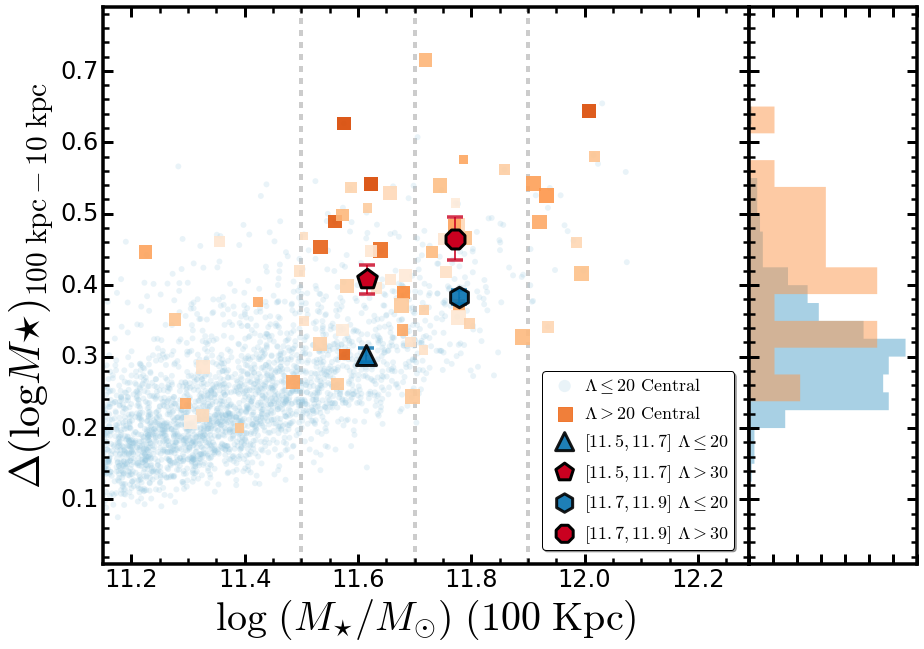

In [817]:
fig = plt.figure(figsize=(13, 9))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# SBP v.s. (cModel - SBP)
# ---------------------------------------------------------------------------
# Scatter plot
#ax1.axhline(0.0, linewidth=4.0, linestyle='-', c='k', alpha=0.2)

ax1.axvline(11.5, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(11.7, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(11.9, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)

# Matched ones 
p1 = ax1.scatter(gamaUse['m100_c'], 
                 gamaUse['lum_100'] - gamaUse['lum_10'], s=35.0, 
                 alpha=0.20, facecolor=BLUE0, edgecolor='none', 
                 label='$\Lambda \leq 20\ \mathrm{Central}$')
p2 = ax1.scatter(bcgUse['m100_c'], 
                 bcgUse['lum_100'] - bcgUse['lum_10'], edgecolor='none',
                 s=((bcgUse['z_use'] - 0.10) * 600.0), cmap=ORG4, alpha=0.90, 
                 c=toColorArr(bcgUse['LAMBDA_CLUSTER'], bottom=20.0, top=70.0), 
                 label='$\Lambda > 20\ \mathrm{Central}$', marker='s')
"""
p3 = ax1.scatter(bcgM1['m100_c'], 
                 bcgM1['lum_100'] - bcgM1['lum_10'], edgecolor='k',
                 s=((bcgM1['z_use'] - 0.10) * 500.0), alpha=0.95, 
                 facecolor='none', label=None, marker='s', linewidth=1.5)
p4 = ax1.scatter(bcgM2b['m100_c'], 
                 bcgM2b['lum_100'] - bcgM2b['lum_10'], edgecolor='k',
                 s=((bcgM2['z_use'] - 0.10) * 500.0), alpha=0.95, 
                 facecolor='none', label=None, marker='s', linewidth=1.5)
"""

# M1
ax1.errorbar(gM1_mass[2], gM1_mdif1[2], marker='+', ms=1, mec='k',
             yerr=0.01, color=BLUE1, ecolor=BLUE1, capthick=3.5, capsize=8, 
             alpha=0.8, linewidth=4.0, fmt='h', elinewidth=2.0, label=None, 
             zorder=100)
ax1.errorbar(bM1_mass[2], bM1_mdif1[2], marker='+', ms=1, mec='k', linewidth=4.0,
             yerr=0.02, mfc=RED1, ecolor=RED1, capthick=3.5, capsize=8, 
             alpha=0.8, fmt='h', elinewidth=2.0, label=None, zorder=100)

ax1.scatter(gM1_mass[2], gM1_mdif1[2], marker='^', s=400, facecolor=BLUE1,
            edgecolor='k', linewidth=3.0, zorder=102, alpha=0.9,
            label='$\mathrm{[11.5,11.7]}\ \Lambda \leq 20$')
ax1.scatter(bM1_mass[2], bM1_mdif1[2], marker='p', s=420, facecolor=RED1,
            edgecolor='k', linewidth=3.0, zorder=102,
            label='$\mathrm{[11.5,11.7]}\ \Lambda > 30$')

# M2
ax1.errorbar(gM2_mass[2], gM2_mdif1[2], marker='+', ms=1, mec='k',
             yerr=0.01, color=BLUE1, ecolor=BLUE1, capthick=3.5, capsize=8, 
             alpha=0.8, fmt='h', elinewidth=2.0, label=None, zorder=100)
ax1.errorbar(bM2_mass[2], bM2_mdif1[2], marker='+', ms=1, mec='k',
             yerr=0.03, mfc=RED1, ecolor=RED1, capthick=3.5, capsize=8, 
             alpha=0.8, fmt='h', elinewidth=2.0, label=None, zorder=100)

ax1.scatter(gM2_mass[2], gM2_mdif1[2], marker='h', s=420, facecolor=BLUE1,
            edgecolor='k', linewidth=3.0, zorder=102, alpha=0.9,
            label='$\mathrm{[11.7,11.9]}\ \Lambda \leq 20$')
ax1.scatter(bM2_mass[2], bM2_mdif1[2], marker='8', s=420, facecolor=RED1,
            edgecolor='k', linewidth=3.0, zorder=102,
            label='$\mathrm{[11.7,11.9]}\ \Lambda > 30$')

# Legend
ax1.legend(loc=(0.68, 0.025), shadow=True, fancybox=True, 
           numpoints=1, fontsize=18, scatterpoints=1, 
           markerscale=0.9, borderpad=0.25, handletextpad=0.1)

legend = ax1.get_legend()
legend.legendHandles[1].set_color(ORG4(0.8))
legend.legendHandles[0].set_sizes([150])
legend.legendHandles[1].set_sizes([200])

#ax1.text(0.05, 0.04, '$\mathrm{Size:}\ {\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=26.0, transform=ax1.transAxes, color=RED0)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ (100\ \mathrm{Kpc})$', size=40)
ax1.set_ylabel('$\Delta(\log M{\star})_{\mathrm{100\ kpc}-\mathrm{10\ kpc}}$', 
               size=42)

# Axis limits
ax1.set_xlim(11.15, 12.29)
ax1.set_ylim(0.01, 0.79)

# ---------------------------------------------------------------------------
# Histogram 
#
n, bins, patches=ax2.hist(gamaM1['lum_100'] - gamaM1['lum_10'], 
                          bins=30, range=[0.05, 0.8], edgecolor='none',
                          orientation='horizontal', histtype='stepfilled', 
                          color=BLUE0, alpha=0.80, normed=1)

n, bins, patches=ax2.hist(bcgM1['lum_100'] - bcgM1['lum_10'], 
                          bins=20, range=[0.05, 0.8], edgecolor='none',
                          orientation='horizontal', histtype='stepfilled', 
                          color=ORG4(0.6), alpha=0.50, normed=1, linewidth=4.0)

#
"""
n, bins, patches=ax2.hist(gamaM2['lum_100'] - gamaM2['lum_10'], 
                          bins=30, range=[0.0, 0.7], linewidth=4.0,
                          orientation='horizontal', histtype='step', 
                          color=BLUE0, alpha=1.0, normed=1)

n, bins, patches=ax2.hist(bcgM2['lum_100'] - bcgM2['lum_10'], 
                          bins=15, range=[0.05, 0.7], linewidth=4.0,
                          orientation='horizontal', histtype='step', 
                          color=RED0, alpha=0.90, normed=1)
"""


ax2.set_ylim(ax1.get_ylim())

ax2.axhline(0.0, linewidth=4.0, linestyle='-', c='k', alpha=0.2)

# Axes setup
# Minor Ticks on 
ax2.minorticks_on()
ax2.tick_params(axis='x', which='minor', bottom='off', top='off')

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('both', length=6, width=2.5, which='minor')

ax1.axhline(0.0, linewidth=4.5, linestyle='-', c='k', alpha=0.2)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

plt.show()

fig.savefig('../figure/hscMassive_mtot_m100_10.png', dpi=230)

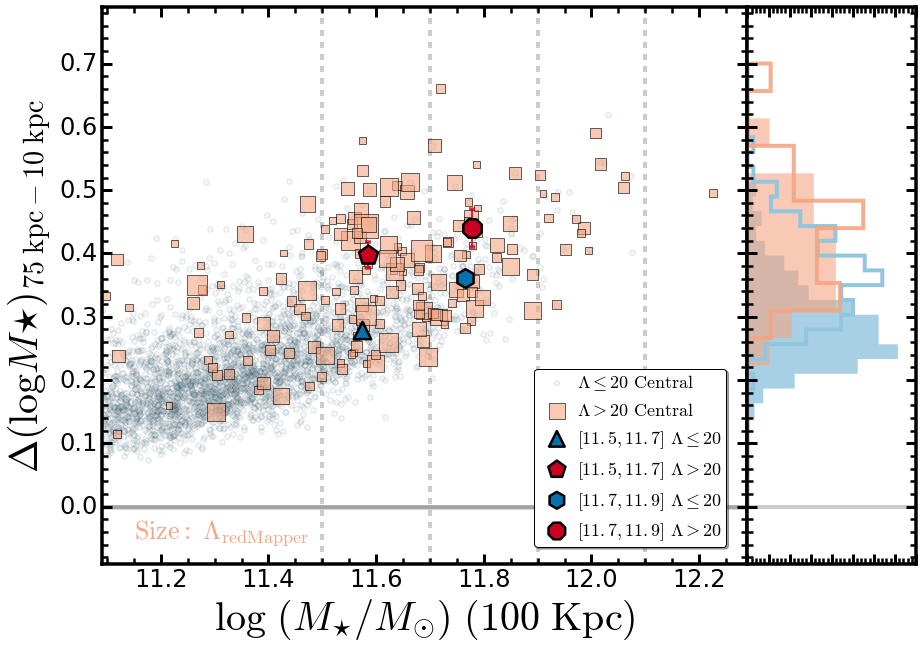

In [535]:
fig = plt.figure(figsize=(13, 9))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# SBP v.s. (cModel - SBP)
# ---------------------------------------------------------------------------
# Scatter plot
ax1.axhline(0.0, linewidth=4.0, linestyle='-', c='k', alpha=0.2)

ax1.axvline(11.5, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(11.7, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(11.9, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(12.1, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)

# Matched ones 
p1 = ax1.scatter(gamaClean['m100_c'], 
                 gamaClean['lum_75'] - gamaClean['lum_10'], s=30.0, 
                 alpha=0.10, c=BLUE0, label='$\Lambda \leq 20\ \mathrm{Central}$')
p2 = ax1.scatter(bcgClean['m100_c'], 
                 bcgClean['lum_75'] - bcgClean['lum_10'], 
                 s=((bcgTab['LAMBDA_CLUSTER'] - 12) * 5.2), 
                 alpha=0.60, c=RED0, label='$\Lambda > 20\ \mathrm{Central}$', marker='s')

# M1
ax1.errorbar(gM1_mass[2], gM1_mdif2[2], marker='+', ms=1, mec='k',
             yerr=0.01, color=BLUE1, ecolor=BLUE1, capthick=3.5, alpha=0.8, linewidth=4.0,
             fmt='h', elinewidth=2.0, label=None, zorder=100)
ax1.errorbar(bM1_mass[2], bM1_mdif2[2], marker='+', ms=1, mec='k', linewidth=4.0,
             yerr=0.02, mfc=RED1, ecolor=RED1, capthick=3.5, alpha=0.8,
             fmt='h', elinewidth=2.0, label=None, zorder=100)

ax1.scatter(gM1_mass[2], gM1_mdif2[2], marker='^', s=300, facecolor=BLUE1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.5,11.7]}\ \Lambda \leq 20$')
ax1.scatter(bM1_mass[2], bM1_mdif2[2], marker='p', s=400, facecolor=RED1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.5,11.7]}\ \Lambda > 20$')

# M2
ax1.errorbar(gM2_mass[2], gM2_mdif2[2], marker='+', ms=1, mec='k',
             yerr=0.01, color=BLUE1, ecolor=BLUE1, capthick=3.5, alpha=0.8,
             fmt='h', elinewidth=2.0, label=None, zorder=100)
ax1.errorbar(bM2_mass[2], bM2_mdif2[2], marker='+', ms=1, mec='k',
             yerr=0.03, mfc=RED1, ecolor=RED1, capthick=3.5, alpha=0.8,
             fmt='h', elinewidth=2.0, label=None, zorder=100)

ax1.scatter(gM2_mass[2], gM2_mdif2[2], marker='h', s=350, facecolor=BLUE1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.7,11.9]}\ \Lambda \leq 20$')
ax1.scatter(bM2_mass[2], bM2_mdif2[2], marker='8', s=400, facecolor=RED1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.7,11.9]}\ \Lambda > 20$')

# Legend
ax1.legend(loc=(0.67, 0.03), shadow=True, fancybox=True, 
           numpoints=1, fontsize=18, scatterpoints=1, 
           markerscale=0.9, borderpad=0.25, handletextpad=0.1)
ax1.text(0.05, 0.03, '$\mathrm{Size:}\ {\Lambda}_{\mathrm{redMapper}}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=26.0, transform=ax1.transAxes, color=RED0)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ (100\ \mathrm{Kpc})$', size=40)
ax1.set_ylabel('$\Delta(\log M{\star})_{\mathrm{75\ kpc}-\mathrm{10\ kpc}}$', 
               size=40)

# Axis limits
ax1.set_xlim(11.09, 12.29)
ax1.set_ylim(-0.09, 0.79)

# ---------------------------------------------------------------------------
# Histogram 
#
n, bins, patches=ax2.hist(gamaM1['lum_75'] - gamaM1['lum_10'], 
                          bins=30, range=[0.0, 0.7], edgecolor='none',
                          orientation='horizontal', histtype='stepfilled', 
                          color=BLUE0, alpha=0.80, normed=1)

n, bins, patches=ax2.hist(bcgM1['lum_75'] - bcgM1['lum_10'], 
                          bins=15, range=[0.05, 0.7], edgecolor='none',
                          orientation='horizontal', histtype='stepfilled', 
                          color=RED0, alpha=0.60, normed=1, linewidth=4.0)

#
n, bins, patches=ax2.hist(gamaM2['lum_75'] - gamaM2['lum_10'], 
                          bins=30, range=[0.0, 0.7], linewidth=4.0,
                          orientation='horizontal', histtype='step', 
                          color=BLUE0, alpha=1.0, normed=1)

n, bins, patches=ax2.hist(bcgM2['lum_75'] - bcgM2['lum_10'], 
                          bins=15, range=[0.05, 0.7], linewidth=4.0,
                          orientation='horizontal', histtype='step', 
                          color=RED0, alpha=0.90, normed=1)


ax2.set_ylim(ax1.get_ylim())

ax2.axhline(0.0, linewidth=4.0, linestyle='-', c='k', alpha=0.2)

# Axes setup
# Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('both', length=6, width=2.5, which='minor')

ax1.axhline(0.0, linewidth=4.5, linestyle='-', c='k', alpha=0.2)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

plt.show()

fig.savefig('../figure/hscMassive_mtot_m75_10.png', dpi=230)

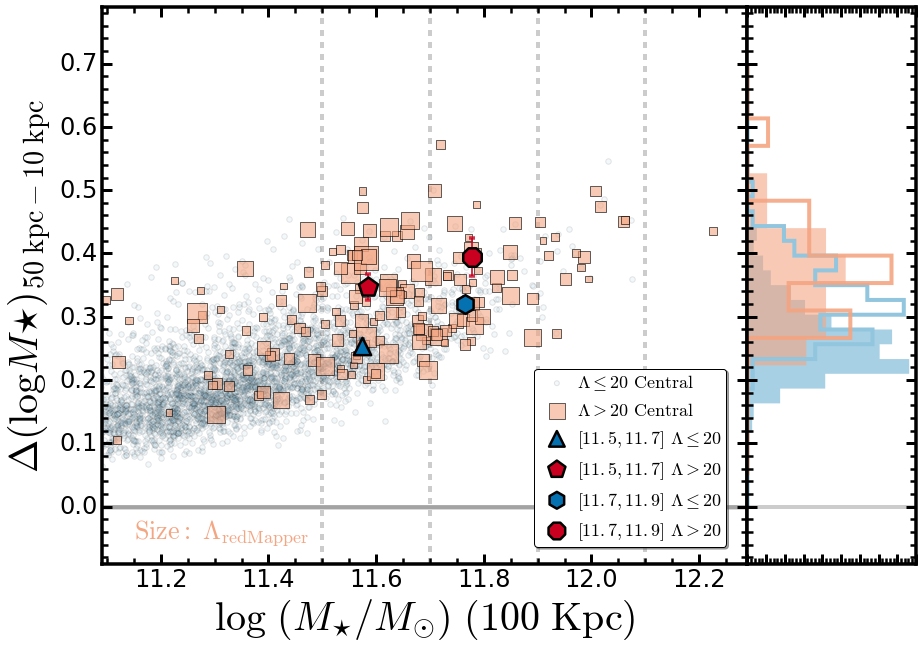

In [536]:
fig = plt.figure(figsize=(13, 9))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# SBP v.s. (cModel - SBP)
# ---------------------------------------------------------------------------
# Scatter plot
ax1.axhline(0.0, linewidth=4.0, linestyle='-', c='k', alpha=0.2)

ax1.axvline(11.5, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(11.7, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(11.9, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(12.1, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)

# Matched ones 
p1 = ax1.scatter(gamaClean['m100_c'], 
                 gamaClean['lum_50'] - gamaClean['lum_10'], s=30.0, 
                 alpha=0.10, c=BLUE0, label='$\Lambda \leq 20\ \mathrm{Central}$')
p2 = ax1.scatter(bcgClean['m100_c'], 
                 bcgClean['lum_50'] - bcgClean['lum_10'], 
                 s=((bcgTab['LAMBDA_CLUSTER'] - 12) * 5.2), 
                 alpha=0.60, c=RED0, label='$\Lambda > 20\ \mathrm{Central}$', marker='s')

# M1
ax1.errorbar(gM1_mass[2], gM1_mdif3[2], marker='+', ms=1, mec='k',
             yerr=0.01, color=BLUE1, ecolor=BLUE1, capthick=3.5, alpha=0.8, linewidth=4.0,
             fmt='h', elinewidth=2.0, label=None, zorder=100)
ax1.errorbar(bM1_mass[2], bM1_mdif3[2], marker='+', ms=1, mec='k', linewidth=4.0,
             yerr=0.02, mfc=RED1, ecolor=RED1, capthick=3.5, alpha=0.8,
             fmt='h', elinewidth=2.0, label=None, zorder=100)

ax1.scatter(gM1_mass[2], gM1_mdif3[2], marker='^', s=300, facecolor=BLUE1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.5,11.7]}\ \Lambda \leq 20$')
ax1.scatter(bM1_mass[2], bM1_mdif3[2], marker='p', s=400, facecolor=RED1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.5,11.7]}\ \Lambda > 20$')

# M2
ax1.errorbar(gM2_mass[2], gM2_mdif3[2], marker='+', ms=1, mec='k',
             yerr=0.01, color=BLUE1, ecolor=BLUE1, capthick=3.5, alpha=0.8,
             fmt='h', elinewidth=2.0, label=None, zorder=100)
ax1.errorbar(bM2_mass[2], bM2_mdif3[2], marker='+', ms=1, mec='k',
             yerr=0.03, mfc=RED1, ecolor=RED1, capthick=3.5, alpha=0.8,
             fmt='h', elinewidth=2.0, label=None, zorder=100)

ax1.scatter(gM2_mass[2], gM2_mdif3[2], marker='h', s=350, facecolor=BLUE1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.7,11.9]}\ \Lambda \leq 20$')
ax1.scatter(bM2_mass[2], bM2_mdif3[2], marker='8', s=400, facecolor=RED1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.7,11.9]}\ \Lambda > 20$')

# Legend
ax1.legend(loc=(0.67, 0.03), shadow=True, fancybox=True, 
           numpoints=1, fontsize=18, scatterpoints=1, 
           markerscale=0.9, borderpad=0.25, handletextpad=0.1)
ax1.text(0.05, 0.03, '$\mathrm{Size:}\ {\Lambda}_{\mathrm{redMapper}}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=26.0, transform=ax1.transAxes, color=RED0)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ (100\ \mathrm{Kpc})$', size=40)
ax1.set_ylabel('$\Delta(\log M{\star})_{\mathrm{50\ kpc}-\mathrm{10\ kpc}}$', 
               size=40)

# Axis limits
ax1.set_xlim(11.09, 12.29)
ax1.set_ylim(-0.09, 0.79)

# ---------------------------------------------------------------------------
# Histogram 
#
n, bins, patches=ax2.hist(gamaM1['lum_50'] - gamaM1['lum_10'], 
                          bins=30, range=[0.0, 0.7], edgecolor='none',
                          orientation='horizontal', histtype='stepfilled', 
                          color=BLUE0, alpha=0.80, normed=1)

n, bins, patches=ax2.hist(bcgM1['lum_50'] - bcgM1['lum_10'], 
                          bins=15, range=[0.05, 0.7], edgecolor='none',
                          orientation='horizontal', histtype='stepfilled', 
                          color=RED0, alpha=0.60, normed=1, linewidth=4.0)

#
n, bins, patches=ax2.hist(gamaM2['lum_50'] - gamaM2['lum_10'], 
                          bins=30, range=[0.0, 0.7], linewidth=4.0,
                          orientation='horizontal', histtype='step', 
                          color=BLUE0, alpha=1.0, normed=1)

n, bins, patches=ax2.hist(bcgM2['lum_50'] - bcgM2['lum_10'], 
                          bins=15, range=[0.05, 0.7], linewidth=4.0,
                          orientation='horizontal', histtype='step', 
                          color=RED0, alpha=0.90, normed=1)


ax2.set_ylim(ax1.get_ylim())

ax2.axhline(0.0, linewidth=4.0, linestyle='-', c='k', alpha=0.2)

# Axes setup
# Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('both', length=6, width=2.5, which='minor')

ax1.axhline(0.0, linewidth=4.5, linestyle='-', c='k', alpha=0.2)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

plt.show()

fig.savefig('../figure/hscMassive_mtot_m50_10.png', dpi=230)

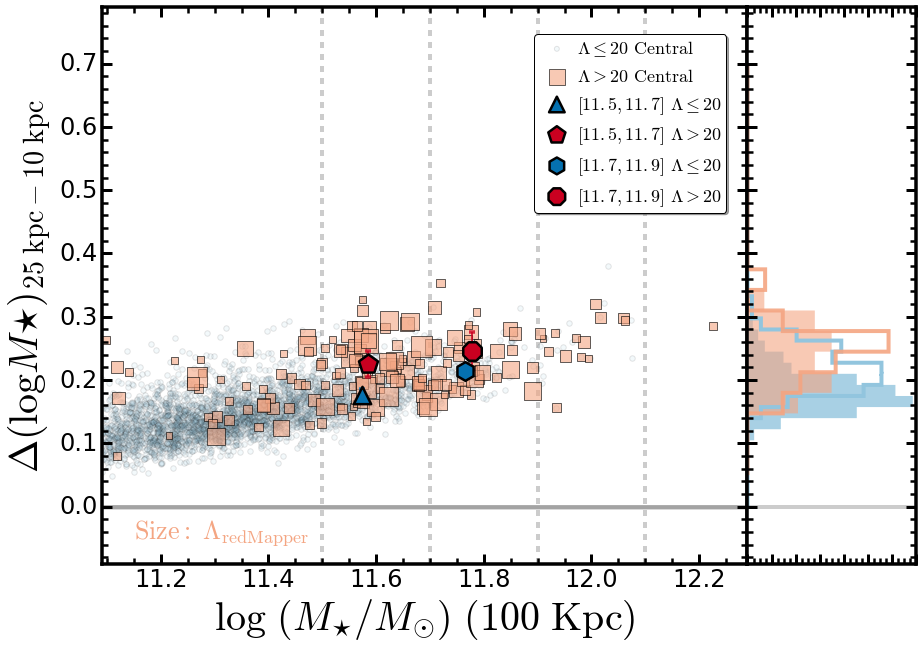

In [537]:
fig = plt.figure(figsize=(13, 9))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# SBP v.s. (cModel - SBP)
# ---------------------------------------------------------------------------
# Scatter plot
ax1.axhline(0.0, linewidth=4.0, linestyle='-', c='k', alpha=0.2)

ax1.axvline(11.5, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(11.7, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(11.9, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(12.1, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)

# Matched ones 
p1 = ax1.scatter(gamaClean['m100_c'], 
                 gamaClean['lum_25'] - gamaClean['lum_10'], s=30.0, 
                 alpha=0.10, c=BLUE0, label='$\Lambda \leq 20\ \mathrm{Central}$')
p2 = ax1.scatter(bcgClean['m100_c'], 
                 bcgClean['lum_25'] - bcgClean['lum_10'], 
                 s=((bcgTab['LAMBDA_CLUSTER'] - 12) * 5.2), 
                 alpha=0.60, c=RED0, label='$\Lambda > 20\ \mathrm{Central}$', marker='s')

# M1
ax1.errorbar(gM1_mass[2], gM1_mdif4[2], marker='+', ms=1, mec='k',
             yerr=0.01, color=BLUE1, ecolor=BLUE1, capthick=3.5, alpha=0.8, linewidth=4.0,
             fmt='h', elinewidth=2.0, label=None, zorder=100)
ax1.errorbar(bM1_mass[2], bM1_mdif4[2], marker='+', ms=1, mec='k', linewidth=4.0,
             yerr=0.02, mfc=RED1, ecolor=RED1, capthick=3.5, alpha=0.8,
             fmt='h', elinewidth=2.0, label=None, zorder=100)

ax1.scatter(gM1_mass[2], gM1_mdif4[2], marker='^', s=300, 
            facecolor=BLUE1, edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.5,11.7]}\ \Lambda \leq 20$')
ax1.scatter(bM1_mass[2], bM1_mdif4[2], marker='p', s=400, facecolor=RED1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.5,11.7]}\ \Lambda > 20$')

# M2
ax1.errorbar(gM2_mass[2], gM2_mdif4[2], marker='+', ms=1, mec='k',
             yerr=0.01, color=BLUE1, ecolor=BLUE1, capthick=3.5, alpha=0.8,
             fmt='h', elinewidth=2.0, label=None, zorder=100)
ax1.errorbar(bM2_mass[2], bM2_mdif4[2], marker='+', ms=1, mec='k',
             yerr=0.03, mfc=RED1, ecolor=RED1, capthick=3.5, alpha=0.8,
             fmt='h', elinewidth=2.0, label=None, zorder=100)

ax1.scatter(gM2_mass[2], gM2_mdif4[2], marker='h', s=350, facecolor=BLUE1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.7,11.9]}\ \Lambda \leq 20$')
ax1.scatter(bM2_mass[2], bM2_mdif4[2], marker='8', s=400, facecolor=RED1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.7,11.9]}\ \Lambda > 20$')

# Legend
ax1.legend(loc=(0.67, 0.63), shadow=True, fancybox=True, 
           numpoints=1, fontsize=18, scatterpoints=1, 
           markerscale=0.9, borderpad=0.25, handletextpad=0.1)
ax1.text(0.05, 0.03, '$\mathrm{Size:}\ {\Lambda}_{\mathrm{redMapper}}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=26.0, transform=ax1.transAxes, color=RED0)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ (100\ \mathrm{Kpc})$', size=40)
ax1.set_ylabel('$\Delta(\log M{\star})_{\mathrm{25\ kpc}-\mathrm{10\ kpc}}$', 
               size=40)

# Axis limits
ax1.set_xlim(11.09, 12.29)
ax1.set_ylim(-0.09, 0.79)

# ---------------------------------------------------------------------------
# Histogram 
#
n, bins, patches=ax2.hist(gamaM1['lum_25'] - gamaM1['lum_10'], 
                          bins=40, range=[0.0, 0.7], edgecolor='none',
                          orientation='horizontal', histtype='stepfilled', 
                          color=BLUE0, alpha=0.80, normed=1)

n, bins, patches=ax2.hist(bcgM1['lum_25'] - bcgM1['lum_10'], 
                          bins=20, range=[0.05, 0.7], edgecolor='none',
                          orientation='horizontal', histtype='stepfilled', 
                          color=RED0, alpha=0.60, normed=1, linewidth=4.0)

#
n, bins, patches=ax2.hist(gamaM2['lum_25'] - gamaM2['lum_10'], 
                          bins=40, range=[0.0, 0.7], linewidth=4.0,
                          orientation='horizontal', histtype='step', 
                          color=BLUE0, alpha=1.0, normed=1)

n, bins, patches=ax2.hist(bcgM2['lum_25'] - bcgM2['lum_10'], 
                          bins=20, range=[0.05, 0.7], linewidth=4.0,
                          orientation='horizontal', histtype='step', 
                          color=RED0, alpha=0.90, normed=1)


ax2.set_ylim(ax1.get_ylim())

ax2.axhline(0.0, linewidth=4.0, linestyle='-', c='k', alpha=0.2)

# Axes setup
# Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('both', length=6, width=2.5, which='minor')

ax1.axhline(0.0, linewidth=4.5, linestyle='-', c='k', alpha=0.2)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

plt.show()

fig.savefig('../figure/hscMassive_mtot_m25_10.png', dpi=230)

# Mass inside 10 Kpc v.s. Mass Growth

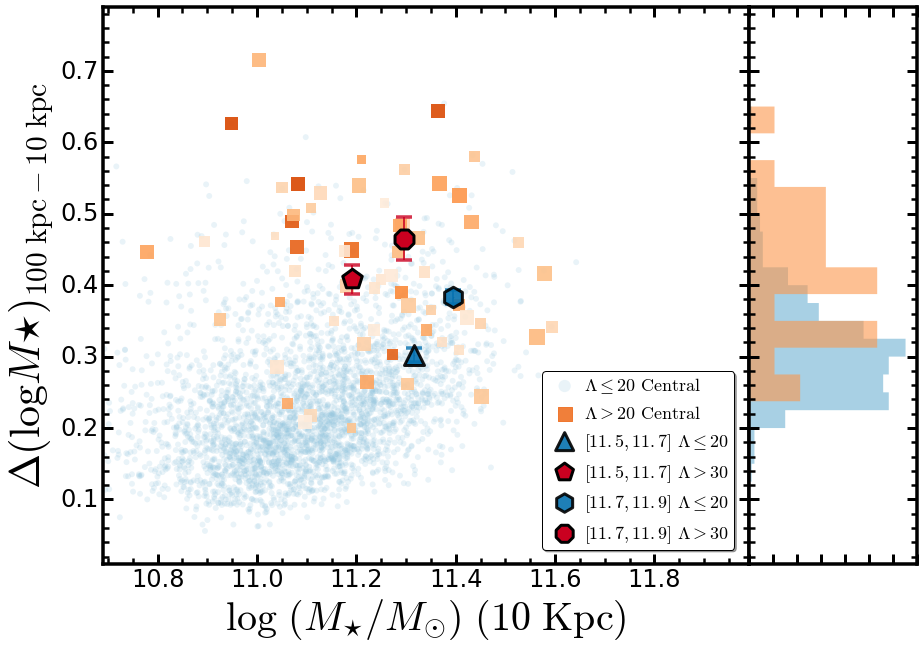

In [819]:
fig = plt.figure(figsize=(13, 9))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# SBP v.s. (cModel - SBP)
# ---------------------------------------------------------------------------
# Scatter plot
#ax1.axhline(0.0, linewidth=4.0, linestyle='-', c='k', alpha=0.2)

#ax1.axvline(11.5, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
#ax1.axvline(11.7, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
#ax1.axvline(11.9, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)

# Matched ones 
p1 = ax1.scatter(gamaUse['m10_c'], 
                 gamaUse['lum_100'] - gamaUse['lum_10'], s=35.0, 
                 alpha=0.20, facecolor=BLUE0, edgecolor='none', 
                 label='$\Lambda \leq 20\ \mathrm{Central}$')
p2 = ax1.scatter(bcgUse['m10_c'], 
                 bcgUse['lum_100'] - bcgUse['lum_10'], edgecolor='none',
                 s=((bcgUse['z_use'] - 0.10) * 600.0), cmap=ORG4, alpha=0.90, 
                 c=toColorArr(bcgUse['LAMBDA_CLUSTER'], bottom=20.0, top=70.0), 
                 label='$\Lambda > 20\ \mathrm{Central}$', marker='s')
"""
p3 = ax1.scatter(bcgM1['m10_c'], 
                 bcgM1['lum_100'] - bcgM1['lum_10'], edgecolor='k',
                 s=((bcgM1['z_use'] - 0.10) * 550.0), alpha=0.95, 
                 facecolor='none', label=None, marker='s', linewidth=2.0)
p4 = ax1.scatter(bcgM2b['m10_c'], 
                 bcgM2b['lum_100'] - bcgM2b['lum_10'], edgecolor='k',
                 s=((bcgM2['z_use'] - 0.10) * 550.0), alpha=0.95, 
                 facecolor='none', label=None, marker='s', linewidth=2.0)
"""

# M1
ax1.errorbar(gCM1_mass[2], gM1_mdif1[2], marker='+', ms=1, mec='k',
             yerr=0.01, color=BLUE1, ecolor=BLUE1, capthick=3.5, capsize=8, 
             alpha=0.8, linewidth=4.0, fmt='h', elinewidth=2.0, label=None, 
             zorder=100)
ax1.errorbar(bCM1_mass[2], bM1_mdif1[2], marker='+', ms=1, mec='k', linewidth=4.0,
             yerr=0.02, mfc=RED1, ecolor=RED1, capthick=3.5, capsize=8, 
             alpha=0.8, fmt='h', elinewidth=2.0, label=None, zorder=100)

ax1.scatter(gCM1_mass[2], gM1_mdif1[2], marker='^', s=400, facecolor=BLUE1,
            edgecolor='k', linewidth=3.0, zorder=102, alpha=0.9,
            label='$\mathrm{[11.5,11.7]}\ \Lambda \leq 20$')
ax1.scatter(bCM1_mass[2], bM1_mdif1[2], marker='p', s=420, facecolor=RED1,
            edgecolor='k', linewidth=3.0, zorder=102,
            label='$\mathrm{[11.5,11.7]}\ \Lambda > 30$')

# M2
ax1.errorbar(gCM2_mass[2], gM2_mdif1[2], marker='+', ms=1, mec='k',
             yerr=0.01, color=BLUE1, ecolor=BLUE1, capthick=3.5, capsize=8, 
             alpha=0.8, fmt='h', elinewidth=2.0, label=None, zorder=100)
ax1.errorbar(bCM2_mass[2], bM2_mdif1[2], marker='+', ms=1, mec='k',
             yerr=0.03, mfc=RED1, ecolor=RED1, capthick=3.5, capsize=8, 
             alpha=0.8, fmt='h', elinewidth=2.0, label=None, zorder=100)

ax1.scatter(gCM2_mass[2], gM2_mdif1[2], marker='h', s=420, facecolor=BLUE1,
            edgecolor='k', linewidth=3.0, zorder=102, alpha=0.9,
            label='$\mathrm{[11.7,11.9]}\ \Lambda \leq 20$')
ax1.scatter(bCM2_mass[2], bM2_mdif1[2], marker='8', s=420, facecolor=RED1,
            edgecolor='k', linewidth=3.0, zorder=102,
            label='$\mathrm{[11.7,11.9]}\ \Lambda > 30$')

# Legend
ax1.legend(loc=(0.68, 0.025), shadow=True, fancybox=True, 
           numpoints=1, fontsize=18, scatterpoints=1, 
           markerscale=0.9, borderpad=0.25, handletextpad=0.1)

legend = ax1.get_legend()
legend.legendHandles[1].set_color(ORG4(0.8))
legend.legendHandles[0].set_sizes([150])
legend.legendHandles[1].set_sizes([200])

#ax1.text(0.05, 0.04, '$\mathrm{Size:}\ {\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=26.0, transform=ax1.transAxes, color=RED0)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ (10\ \mathrm{Kpc})$', size=40)
ax1.set_ylabel('$\Delta(\log M{\star})_{\mathrm{100\ kpc}-\mathrm{10\ kpc}}$', 
               size=42)

# Axis limits
ax1.set_xlim(10.69, 11.99)
ax1.set_ylim(0.01, 0.79)

# ---------------------------------------------------------------------------
# Histogram 
#
n, bins, patches=ax2.hist(gamaM1['lum_100'] - gamaM1['lum_10'], 
                          bins=30, range=[0.05, 0.8], edgecolor='none',
                          orientation='horizontal', histtype='stepfilled', 
                          color=BLUE0, alpha=0.80, normed=1)

n, bins, patches=ax2.hist(bcgM1['lum_100'] - bcgM1['lum_10'], 
                          bins=20, range=[0.05, 0.8], edgecolor='none',
                          orientation='horizontal', histtype='stepfilled', 
                          color=ORG4(0.6), alpha=0.60, normed=1, linewidth=4.0)

#
"""
n, bins, patches=ax2.hist(gamaM2['lum_100'] - gamaM2['lum_10'], 
                          bins=30, range=[0.05, 0.8], linewidth=4.0,
                          orientation='horizontal', histtype='step', 
                          color=BLUE0, alpha=1.0, normed=1)

n, bins, patches=ax2.hist(bcgM2['lum_100'] - bcgM2['lum_10'], 
                          bins=20, range=[0.05, 0.8], linewidth=4.0,
                          orientation='horizontal', histtype='step', 
                          color=RED0, alpha=0.90, normed=1)
"""


ax2.set_ylim(ax1.get_ylim())

# Axes setup
# Minor Ticks on 
ax2.minorticks_on()
ax2.tick_params(axis='x', which='minor', bottom='off', top='off')

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('both', length=6, width=2.5, which='minor')

ax1.axhline(0.0, linewidth=4.5, linestyle='-', c='k', alpha=0.2)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

plt.show()

fig.savefig('../figure/hscMassive_m10_m100_10.png', dpi=230)

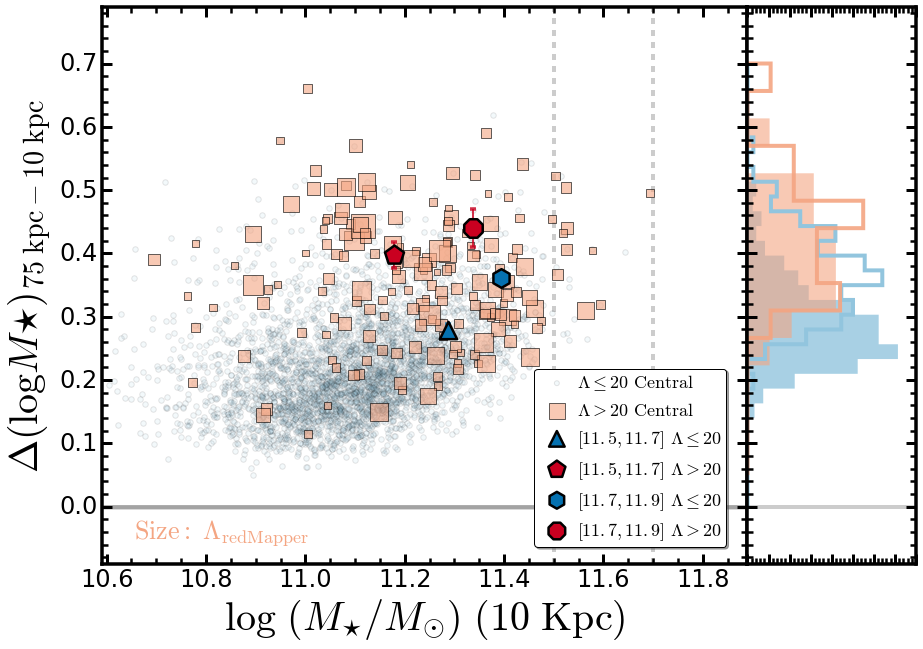

In [539]:
fig = plt.figure(figsize=(13, 9))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# SBP v.s. (cModel - SBP)
# ---------------------------------------------------------------------------
# Scatter plot
ax1.axhline(0.0, linewidth=4.0, linestyle='-', c='k', alpha=0.2)

ax1.axvline(11.5, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(11.7, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(11.9, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(12.1, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)

# Matched ones 
p1 = ax1.scatter(gamaClean['m10_c'], 
                 gamaClean['lum_75'] - gamaClean['lum_10'], s=30.0, 
                 alpha=0.10, c=BLUE0, label='$\Lambda \leq 20\ \mathrm{Central}$')
p2 = ax1.scatter(bcgClean['m10_c'], 
                 bcgClean['lum_75'] - bcgClean['lum_10'], 
                 s=((bcgTab['LAMBDA_CLUSTER'] - 12) * 5.2), 
                 alpha=0.60, c=RED0, label='$\Lambda > 20\ \mathrm{Central}$', marker='s')

# M1
ax1.errorbar(gCM1_mass[2], gM1_mdif2[2], marker='+', ms=1, mec='k',
             yerr=0.01, color=BLUE1, ecolor=BLUE1, capthick=3.5, alpha=0.8, linewidth=4.0,
             fmt='h', elinewidth=2.0, label=None, zorder=100)
ax1.errorbar(bCM1_mass[2], bM1_mdif2[2], marker='+', ms=1, mec='k', linewidth=4.0,
             yerr=0.02, mfc=RED1, ecolor=RED1, capthick=3.5, alpha=0.8,
             fmt='h', elinewidth=2.0, label=None, zorder=100)

ax1.scatter(gCM1_mass[2], gM1_mdif2[2], marker='^', s=300, facecolor=BLUE1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.5,11.7]}\ \Lambda \leq 20$')
ax1.scatter(bCM1_mass[2], bM1_mdif2[2], marker='p', s=400, facecolor=RED1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.5,11.7]}\ \Lambda > 20$')

# M2
ax1.errorbar(gCM2_mass[2], gM2_mdif2[2], marker='+', ms=1, mec='k',
             yerr=0.01, color=BLUE1, ecolor=BLUE1, capthick=3.5, alpha=0.8,
             fmt='h', elinewidth=2.0, label=None, zorder=100)
ax1.errorbar(bCM2_mass[2], bM2_mdif2[2], marker='+', ms=1, mec='k',
             yerr=0.03, mfc=RED1, ecolor=RED1, capthick=3.5, alpha=0.8,
             fmt='h', elinewidth=2.0, label=None, zorder=100)

ax1.scatter(gCM2_mass[2], gM2_mdif2[2], marker='h', s=350, facecolor=BLUE1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.7,11.9]}\ \Lambda \leq 20$')
ax1.scatter(bCM2_mass[2], bM2_mdif2[2], marker='8', s=400, facecolor=RED1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.7,11.9]}\ \Lambda > 20$')

# Legend
ax1.legend(loc=(0.67, 0.03), shadow=True, fancybox=True, 
           numpoints=1, fontsize=18, scatterpoints=1, 
           markerscale=0.9, borderpad=0.25, handletextpad=0.1)
ax1.text(0.05, 0.03, '$\mathrm{Size:}\ {\Lambda}_{\mathrm{redMapper}}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=26.0, transform=ax1.transAxes, color=RED0)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ (10\ \mathrm{Kpc})$', size=40)
ax1.set_ylabel('$\Delta(\log M{\star})_{\mathrm{75\ kpc}-\mathrm{10\ kpc}}$', 
               size=40)

# Axis limits
ax1.set_xlim(10.59, 11.89)
ax1.set_ylim(-0.09, 0.79)

# ---------------------------------------------------------------------------
# Histogram 
#
n, bins, patches=ax2.hist(gamaM1['lum_75'] - gamaM1['lum_10'], 
                          bins=30, range=[0.0, 0.7], edgecolor='none',
                          orientation='horizontal', histtype='stepfilled', 
                          color=BLUE0, alpha=0.80, normed=1)

n, bins, patches=ax2.hist(bcgM1['lum_75'] - bcgM1['lum_10'], 
                          bins=15, range=[0.05, 0.7], edgecolor='none',
                          orientation='horizontal', histtype='stepfilled', 
                          color=RED0, alpha=0.60, normed=1, linewidth=4.0)

#
n, bins, patches=ax2.hist(gamaM2['lum_75'] - gamaM2['lum_10'], 
                          bins=30, range=[0.0, 0.7], linewidth=4.0,
                          orientation='horizontal', histtype='step', 
                          color=BLUE0, alpha=1.0, normed=1)

n, bins, patches=ax2.hist(bcgM2['lum_75'] - bcgM2['lum_10'], 
                          bins=15, range=[0.05, 0.7], linewidth=4.0,
                          orientation='horizontal', histtype='step', 
                          color=RED0, alpha=0.90, normed=1)


ax2.set_ylim(ax1.get_ylim())

ax2.axhline(0.0, linewidth=4.0, linestyle='-', c='k', alpha=0.2)

# Axes setup
# Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('both', length=6, width=2.5, which='minor')

ax1.axhline(0.0, linewidth=4.5, linestyle='-', c='k', alpha=0.2)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

plt.show()

fig.savefig('../figure/hscMassive_m10_m75_10.png', dpi=230)

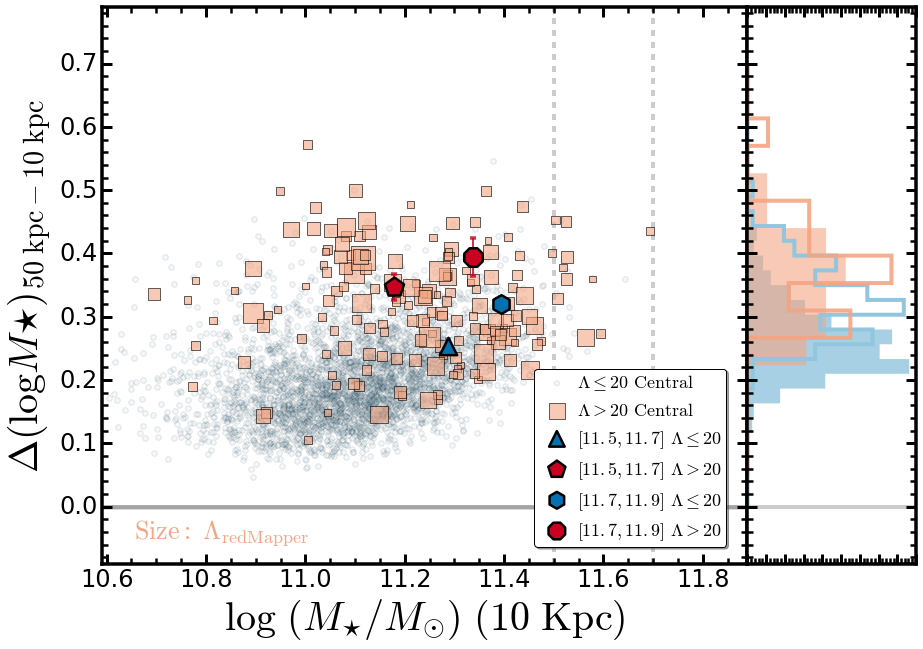

In [540]:
fig = plt.figure(figsize=(13, 9))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# SBP v.s. (cModel - SBP)
# ---------------------------------------------------------------------------
# Scatter plot
ax1.axhline(0.0, linewidth=4.0, linestyle='-', c='k', alpha=0.2)

ax1.axvline(11.5, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(11.7, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(11.9, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(12.1, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)

# Matched ones 
p1 = ax1.scatter(gamaClean['m10_c'], 
                 gamaClean['lum_50'] - gamaClean['lum_10'], s=30.0, 
                 alpha=0.10, c=BLUE0, label='$\Lambda \leq 20\ \mathrm{Central}$')
p2 = ax1.scatter(bcgClean['m10_c'], 
                 bcgClean['lum_50'] - bcgClean['lum_10'], 
                 s=((bcgTab['LAMBDA_CLUSTER'] - 12) * 5.2), 
                 alpha=0.60, c=RED0, label='$\Lambda > 20\ \mathrm{Central}$', marker='s')

# M1
ax1.errorbar(gCM1_mass[2], gM1_mdif3[2], marker='+', ms=1, mec='k',
             yerr=0.01, color=BLUE1, ecolor=BLUE1, capthick=3.5, alpha=0.8, linewidth=4.0,
             fmt='h', elinewidth=2.0, label=None, zorder=100)
ax1.errorbar(bCM1_mass[2], bM1_mdif3[2], marker='+', ms=1, mec='k', linewidth=4.0,
             yerr=0.02, mfc=RED1, ecolor=RED1, capthick=3.5, alpha=0.8,
             fmt='h', elinewidth=2.0, label=None, zorder=100)

ax1.scatter(gCM1_mass[2], gM1_mdif3[2], marker='^', s=300, facecolor=BLUE1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.5,11.7]}\ \Lambda \leq 20$')
ax1.scatter(bCM1_mass[2], bM1_mdif3[2], marker='p', s=400, facecolor=RED1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.5,11.7]}\ \Lambda > 20$')

# M2
ax1.errorbar(gCM2_mass[2], gM2_mdif3[2], marker='+', ms=1, mec='k',
             yerr=0.01, color=BLUE1, ecolor=BLUE1, capthick=3.5, alpha=0.8,
             fmt='h', elinewidth=2.0, label=None, zorder=100)
ax1.errorbar(bCM2_mass[2], bM2_mdif3[2], marker='+', ms=1, mec='k',
             yerr=0.03, mfc=RED1, ecolor=RED1, capthick=3.5, alpha=0.8,
             fmt='h', elinewidth=2.0, label=None, zorder=100)

ax1.scatter(gCM2_mass[2], gM2_mdif3[2], marker='h', s=350, facecolor=BLUE1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.7,11.9]}\ \Lambda \leq 20$')
ax1.scatter(bCM2_mass[2], bM2_mdif3[2], marker='8', s=400, facecolor=RED1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.7,11.9]}\ \Lambda > 20$')

# Legend
ax1.legend(loc=(0.67, 0.03), shadow=True, fancybox=True, 
           numpoints=1, fontsize=18, scatterpoints=1, 
           markerscale=0.9, borderpad=0.25, handletextpad=0.1)
ax1.text(0.05, 0.03, '$\mathrm{Size:}\ {\Lambda}_{\mathrm{redMapper}}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=26.0, transform=ax1.transAxes, color=RED0)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ (10\ \mathrm{Kpc})$', size=40)
ax1.set_ylabel('$\Delta(\log M{\star})_{\mathrm{50\ kpc}-\mathrm{10\ kpc}}$', 
               size=40)

# Axis limits
ax1.set_xlim(10.59, 11.89)
ax1.set_ylim(-0.09, 0.79)

# ---------------------------------------------------------------------------
# Histogram 
#
n, bins, patches=ax2.hist(gamaM1['lum_50'] - gamaM1['lum_10'], 
                          bins=30, range=[0.0, 0.7], edgecolor='none',
                          orientation='horizontal', histtype='stepfilled', 
                          color=BLUE0, alpha=0.80, normed=1)

n, bins, patches=ax2.hist(bcgM1['lum_50'] - bcgM1['lum_10'], 
                          bins=15, range=[0.05, 0.7], edgecolor='none',
                          orientation='horizontal', histtype='stepfilled', 
                          color=RED0, alpha=0.60, normed=1, linewidth=4.0)

#
n, bins, patches=ax2.hist(gamaM2['lum_50'] - gamaM2['lum_10'], 
                          bins=30, range=[0.0, 0.7], linewidth=4.0,
                          orientation='horizontal', histtype='step', 
                          color=BLUE0, alpha=1.0, normed=1)

n, bins, patches=ax2.hist(bcgM2['lum_50'] - bcgM2['lum_10'], 
                          bins=15, range=[0.05, 0.7], linewidth=4.0,
                          orientation='horizontal', histtype='step', 
                          color=RED0, alpha=0.90, normed=1)


ax2.set_ylim(ax1.get_ylim())

ax2.axhline(0.0, linewidth=4.0, linestyle='-', c='k', alpha=0.2)

# Axes setup
# Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('both', length=6, width=2.5, which='minor')

ax1.axhline(0.0, linewidth=4.5, linestyle='-', c='k', alpha=0.2)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

plt.show()

fig.savefig('../figure/hscMassive_m10_m50_10.png', dpi=230)

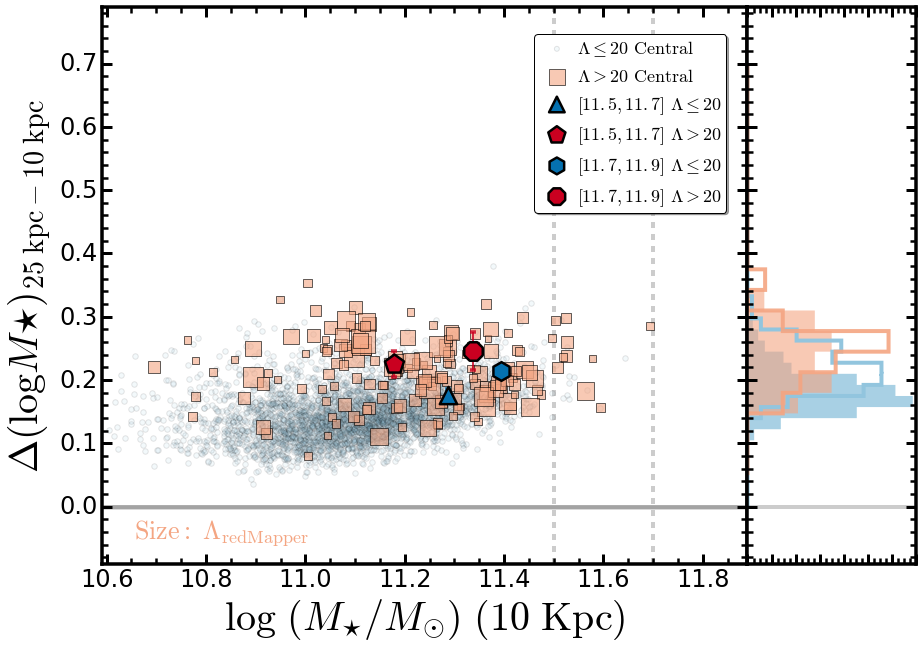

In [541]:
fig = plt.figure(figsize=(13, 9))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# SBP v.s. (cModel - SBP)
# ---------------------------------------------------------------------------
# Scatter plot
ax1.axhline(0.0, linewidth=4.0, linestyle='-', c='k', alpha=0.2)

ax1.axvline(11.5, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(11.7, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(11.9, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)
ax1.axvline(12.1, linewidth=4.0, linestyle='--', c='k', alpha=0.2, zorder=0)

# Matched ones 
p1 = ax1.scatter(gamaClean['m10_c'], 
                 gamaClean['lum_25'] - gamaClean['lum_10'], s=30.0, 
                 alpha=0.10, c=BLUE0, label='$\Lambda \leq 20\ \mathrm{Central}$')
p2 = ax1.scatter(bcgClean['m10_c'], 
                 bcgClean['lum_25'] - bcgClean['lum_10'], 
                 s=((bcgTab['LAMBDA_CLUSTER'] - 12) * 5.2), 
                 alpha=0.60, c=RED0, label='$\Lambda > 20\ \mathrm{Central}$', marker='s')

# M1
ax1.errorbar(gCM1_mass[2], gM1_mdif4[2], marker='+', ms=1, mec='k',
             yerr=0.01, color=BLUE1, ecolor=BLUE1, capthick=3.5, alpha=0.8, linewidth=4.0,
             fmt='h', elinewidth=2.0, label=None, zorder=100)
ax1.errorbar(bCM1_mass[2], bM1_mdif4[2], marker='+', ms=1, mec='k', linewidth=4.0,
             yerr=0.02, mfc=RED1, ecolor=RED1, capthick=3.5, alpha=0.8,
             fmt='h', elinewidth=2.0, label=None, zorder=100)

ax1.scatter(gCM1_mass[2], gM1_mdif4[2], marker='^', s=300, facecolor=BLUE1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.5,11.7]}\ \Lambda \leq 20$')
ax1.scatter(bCM1_mass[2], bM1_mdif4[2], marker='p', s=400, facecolor=RED1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.5,11.7]}\ \Lambda > 20$')

# M2
ax1.errorbar(gCM2_mass[2], gM2_mdif4[2], marker='+', ms=1, mec='k',
             yerr=0.01, color=BLUE1, ecolor=BLUE1, capthick=3.5, alpha=0.8,
             fmt='h', elinewidth=2.0, label=None, zorder=100)
ax1.errorbar(bCM2_mass[2], bM2_mdif4[2], marker='+', ms=1, mec='k',
             yerr=0.03, mfc=RED1, ecolor=RED1, capthick=3.5, alpha=0.8,
             fmt='h', elinewidth=2.0, label=None, zorder=100)

ax1.scatter(gCM2_mass[2], gM2_mdif4[2], marker='h', s=350, facecolor=BLUE1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.7,11.9]}\ \Lambda \leq 20$')
ax1.scatter(bCM2_mass[2], bM2_mdif4[2], marker='8', s=400, facecolor=RED1,
            edgecolor='k', linewidth=2.5, zorder=102,
            label='$\mathrm{[11.7,11.9]}\ \Lambda > 20$')

# Legend
ax1.legend(loc=(0.67, 0.63), shadow=True, fancybox=True, 
           numpoints=1, fontsize=18, scatterpoints=1, 
           markerscale=0.9, borderpad=0.25, handletextpad=0.1)
ax1.text(0.05, 0.03, '$\mathrm{Size:}\ {\Lambda}_{\mathrm{redMapper}}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=26.0, transform=ax1.transAxes, color=RED0)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ (10\ \mathrm{Kpc})$', size=40)
ax1.set_ylabel('$\Delta(\log M{\star})_{\mathrm{25\ kpc}-\mathrm{10\ kpc}}$', 
               size=40)

# Axis limits
ax1.set_xlim(10.59, 11.89)
ax1.set_ylim(-0.09, 0.79)

# ---------------------------------------------------------------------------
# Histogram 
#
n, bins, patches=ax2.hist(gamaM1['lum_25'] - gamaM1['lum_10'], 
                          bins=40, range=[0.0, 0.7], edgecolor='none',
                          orientation='horizontal', histtype='stepfilled', 
                          color=BLUE0, alpha=0.80, normed=1)

n, bins, patches=ax2.hist(bcgM1['lum_25'] - bcgM1['lum_10'], 
                          bins=20, range=[0.05, 0.7], edgecolor='none',
                          orientation='horizontal', histtype='stepfilled', 
                          color=RED0, alpha=0.60, normed=1, linewidth=4.0)

#
n, bins, patches=ax2.hist(gamaM2['lum_25'] - gamaM2['lum_10'], 
                          bins=40, range=[0.0, 0.7], linewidth=4.0,
                          orientation='horizontal', histtype='step', 
                          color=BLUE0, alpha=1.0, normed=1)

n, bins, patches=ax2.hist(bcgM2['lum_25'] - bcgM2['lum_10'], 
                          bins=20, range=[0.05, 0.7], linewidth=4.0,
                          orientation='horizontal', histtype='step', 
                          color=RED0, alpha=0.90, normed=1)


ax2.set_ylim(ax1.get_ylim())

ax2.axhline(0.0, linewidth=4.0, linestyle='-', c='k', alpha=0.2)

# Axes setup
# Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('both', length=6, width=2.5, which='minor')

ax1.axhline(0.0, linewidth=4.5, linestyle='-', c='k', alpha=0.2)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

plt.show()

fig.savefig('../figure/hscMassive_m10_m25_10.png', dpi=230)

## Mass Growth v.s. Mass Growth

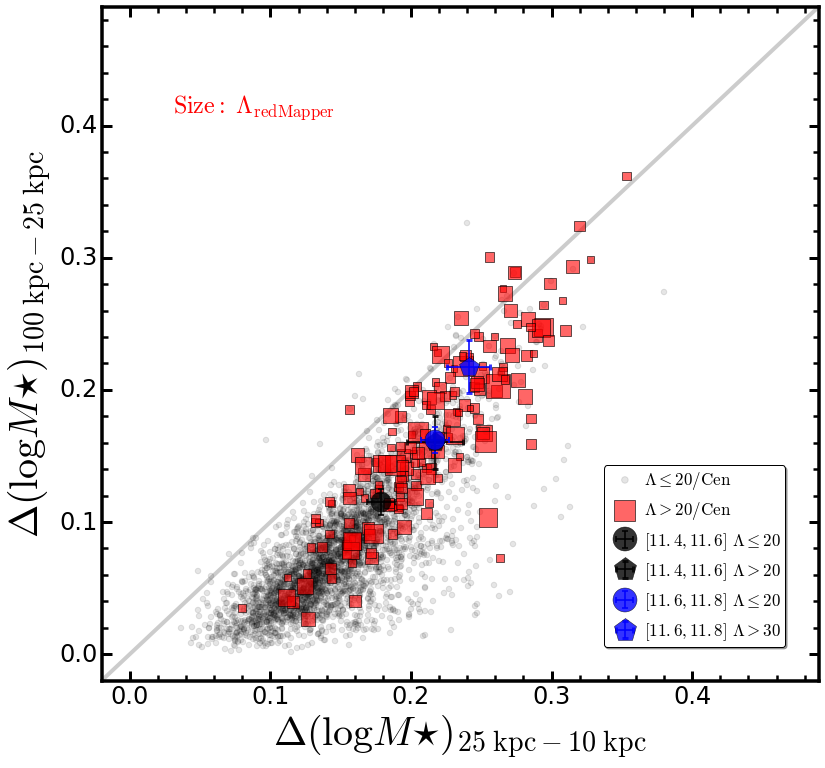

In [214]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.12)
ax1 = fig.add_subplot(111)

temp = np.asarray([-0.1, 1.0])
ax1.plot(temp, temp, c='k', linestyle='-', linewidth=4.0, 
         alpha=0.2, zorder=0)

# Matched ones 
p1 = ax1.scatter(gamaClean['lum_25'] - gamaClean['lum_10'], 
                 gamaClean['lum_100'] - gamaClean['lum_25'], s=30.0, 
                 alpha=0.10, c='k', label='$\Lambda \leq 20\mathrm{/Cen}$')
p2 = ax1.scatter(bcgClean['lum_25'] - bcgClean['lum_10'], 
                 bcgClean['lum_100'] - bcgClean['lum_25'], 
                 s=((bcgTab['LAMBDA_CLUSTER'] - 12) * 5.2), 
                 alpha=0.60, c='r', label='$\Lambda > 20\mathrm{/Cen}$', marker='s')

# M1
ax1.errorbar(np.nanmedian(gamaM1['lum_25'] - gamaM1['lum_10']),
             np.nanmedian(gamaM1['lum_100'] - gamaM1['lum_25']), 
             marker='o', ms=20, mec='k',
             xerr=0.01, yerr=0.01, color='k', ecolor='k', capthick=2.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.4,11.6]}\ \Lambda \leq 20$')
ax1.errorbar(np.nanmedian(bcgM1['lum_25'] - bcgM1['lum_10']),
             np.nanmedian(bcgM1['lum_100'] - bcgM1['lum_25']), 
             marker='p', ms=20, mec='k', linewidth=4.0,
             xerr=0.02, yerr=0.02, mfc='k', ecolor='k', capthick=3.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.4,11.6]}\ \Lambda > 20$')

# M2
ax1.errorbar(np.nanmedian(gamaM2['lum_25'] - gamaM2['lum_10']),
             np.nanmedian(gamaM2['lum_100'] - gamaM2['lum_25']), 
             marker='o', ms=20, mec='k',
             xerr=0.01, yerr=0.01, color='b', ecolor='b', capthick=2.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.6,11.8]}\ \Lambda \leq 20$')
ax1.errorbar(np.nanmedian(bcgM2['lum_25'] - bcgM2['lum_10']),
             np.nanmedian(bcgM2['lum_100'] - bcgM2['lum_25']),
             marker='p', ms=20, mec='k',
             xerr=0.015, yerr=0.02, mfc='b', ecolor='b', capthick=3.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.6,11.8]}\ \Lambda > 30$')

# Legend
ax1.legend(loc=(0.70, 0.05), shadow=True, fancybox=True, 
           numpoints=1, fontsize=17, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.1)
ax1.text(0.10, 0.83, '$\mathrm{Size:}\ {\Lambda}_{\mathrm{redMapper}}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=24.0, transform=ax1.transAxes, color='r')

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\Delta(\log M{\star})_{\mathrm{25\ kpc}-\mathrm{10\ kpc}}$', 
               size=40)
ax1.set_ylabel('$\Delta(\log M{\star})_{\mathrm{100\ kpc}-\mathrm{25\ kpc}}$', 
               size=40)

# Axis limits
ax1.set_xlim(-0.02, 0.49)
ax1.set_ylim(-0.02, 0.49)

plt.show()

fig.savefig('../figure/hscMassive_dm25-10_dm100_25.png', dpi=230)

# Mass v.s Mass

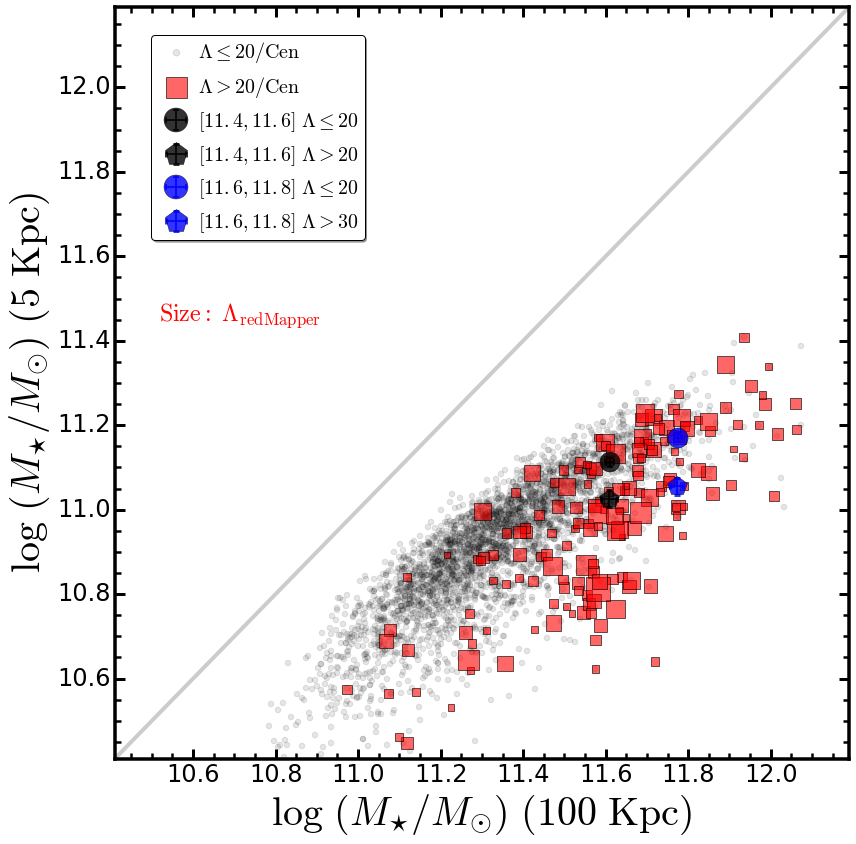

In [228]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.13, right=0.98, bottom=0.11, top=0.98)
ax1 = fig.add_subplot(111)

temp = np.asarray([10.0, 13.0])
ax1.plot(temp, temp, c='k', linestyle='-', linewidth=4.0, 
         alpha=0.2, zorder=0)

# Matched ones 
p1 = ax1.scatter(gamaClean['m100_c'], gamaClean['m5_c'], s=30.0, 
                 alpha=0.10, c='k', label='$\Lambda \leq 20\mathrm{/Cen}$')
p2 = ax1.scatter(bcgClean['m100_c'], bcgClean['m5_c'], 
                 s=((bcgTab['LAMBDA_CLUSTER'] - 12) * 5.2), 
                 alpha=0.60, c='r', label='$\Lambda > 20\mathrm{/Cen}$', marker='s')

# M1
ax1.errorbar(np.nanmedian(gamaM1['m100_c']),
             np.nanmedian(gamaM1['m5_c']), 
             marker='o', ms=20, mec='k',
             xerr=0.01, yerr=0.01, color='k', ecolor='k', capthick=2.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.4,11.6]}\ \Lambda \leq 20$')
ax1.errorbar(np.nanmedian(bcgM1['m100_c']),
             np.nanmedian(bcgM1['m5_c']), 
             marker='p', ms=20, mec='k', linewidth=4.0,
             xerr=0.02, yerr=0.02, mfc='k', ecolor='k', capthick=3.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.4,11.6]}\ \Lambda > 20$')

# M2
ax1.errorbar(np.nanmedian(gamaM2['m100_c']),
             np.nanmedian(gamaM2['m5_c']), 
             marker='o', ms=20, mec='k',
             xerr=0.01, yerr=0.01, color='b', ecolor='b', capthick=2.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.6,11.8]}\ \Lambda \leq 20$')
ax1.errorbar(np.nanmedian(bcgM2['m100_c']),
             np.nanmedian(bcgM2['m5_c']),
             marker='p', ms=20, mec='k',
             xerr=0.015, yerr=0.02, mfc='b', ecolor='b', capthick=3.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.6,11.8]}\ \Lambda > 30$')

# Legend
ax1.legend(loc=(0.05, 0.69), shadow=True, fancybox=True, 
           numpoints=1, fontsize=20, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.1)
ax1.text(0.06, 0.57, '$\mathrm{Size:}\ {\Lambda}_{\mathrm{redMapper}}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=24.0, transform=ax1.transAxes, color='r')

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ (\mathrm{100\ Kpc})$', size=40)
ax1.set_ylabel('$\log\ (M_{\star}/M_{\odot})\ (\mathrm{5\ Kpc})$', size=40)

# Axis limits
ax1.set_xlim(10.41, 12.19)
ax1.set_ylim(10.41, 12.19)

plt.show()

fig.savefig('../figure/hscMassive_m100_m5.png', dpi=230)

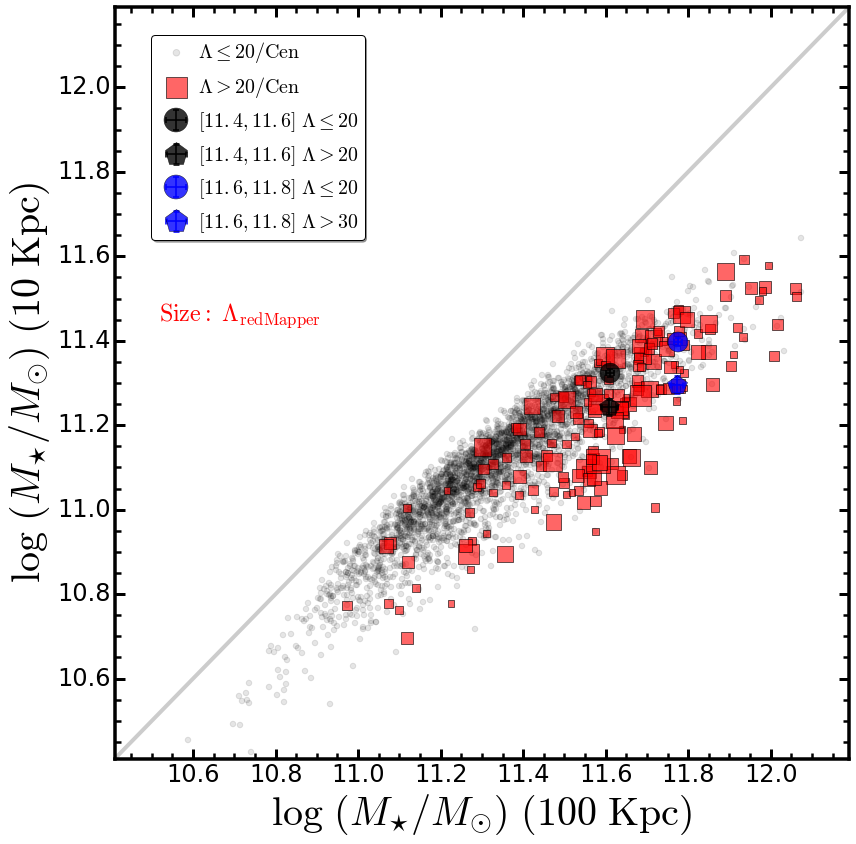

In [229]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.13, right=0.98, bottom=0.11, top=0.98)
ax1 = fig.add_subplot(111)

temp = np.asarray([10.0, 13.0])
ax1.plot(temp, temp, c='k', linestyle='-', linewidth=4.0, 
         alpha=0.2, zorder=0)

# Matched ones 
p1 = ax1.scatter(gamaClean['m100_c'], gamaClean['m10_c'], s=30.0, 
                 alpha=0.10, c='k', label='$\Lambda \leq 20\mathrm{/Cen}$')
p2 = ax1.scatter(bcgClean['m100_c'], bcgClean['m10_c'], 
                 s=((bcgTab['LAMBDA_CLUSTER'] - 12) * 5.2), 
                 alpha=0.60, c='r', label='$\Lambda > 20\mathrm{/Cen}$', marker='s')

# M1
ax1.errorbar(np.nanmedian(gamaM1['m100_c']),
             np.nanmedian(gamaM1['m10_c']), 
             marker='o', ms=20, mec='k',
             xerr=0.01, yerr=0.01, color='k', ecolor='k', capthick=2.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.4,11.6]}\ \Lambda \leq 20$')
ax1.errorbar(np.nanmedian(bcgM1['m100_c']),
             np.nanmedian(bcgM1['m10_c']), 
             marker='p', ms=20, mec='k', linewidth=4.0,
             xerr=0.02, yerr=0.02, mfc='k', ecolor='k', capthick=3.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.4,11.6]}\ \Lambda > 20$')

# M2
ax1.errorbar(np.nanmedian(gamaM2['m100_c']),
             np.nanmedian(gamaM2['m10_c']), 
             marker='o', ms=20, mec='k',
             xerr=0.01, yerr=0.01, color='b', ecolor='b', capthick=2.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.6,11.8]}\ \Lambda \leq 20$')
ax1.errorbar(np.nanmedian(bcgM2['m100_c']),
             np.nanmedian(bcgM2['m10_c']),
             marker='p', ms=20, mec='k',
             xerr=0.015, yerr=0.02, mfc='b', ecolor='b', capthick=3.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.6,11.8]}\ \Lambda > 30$')

# Legend
ax1.legend(loc=(0.05, 0.69), shadow=True, fancybox=True, 
           numpoints=1, fontsize=20, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.1)
ax1.text(0.06, 0.57, '$\mathrm{Size:}\ {\Lambda}_{\mathrm{redMapper}}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=24.0, transform=ax1.transAxes, color='r')

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ (\mathrm{100\ Kpc})$', size=40)
ax1.set_ylabel('$\log\ (M_{\star}/M_{\odot})\ (\mathrm{10\ Kpc})$', size=40)

# Axis limits
ax1.set_xlim(10.41, 12.19)
ax1.set_ylim(10.41, 12.19)

plt.show()

fig.savefig('../figure/hscMassive_m100_m10.png', dpi=230)

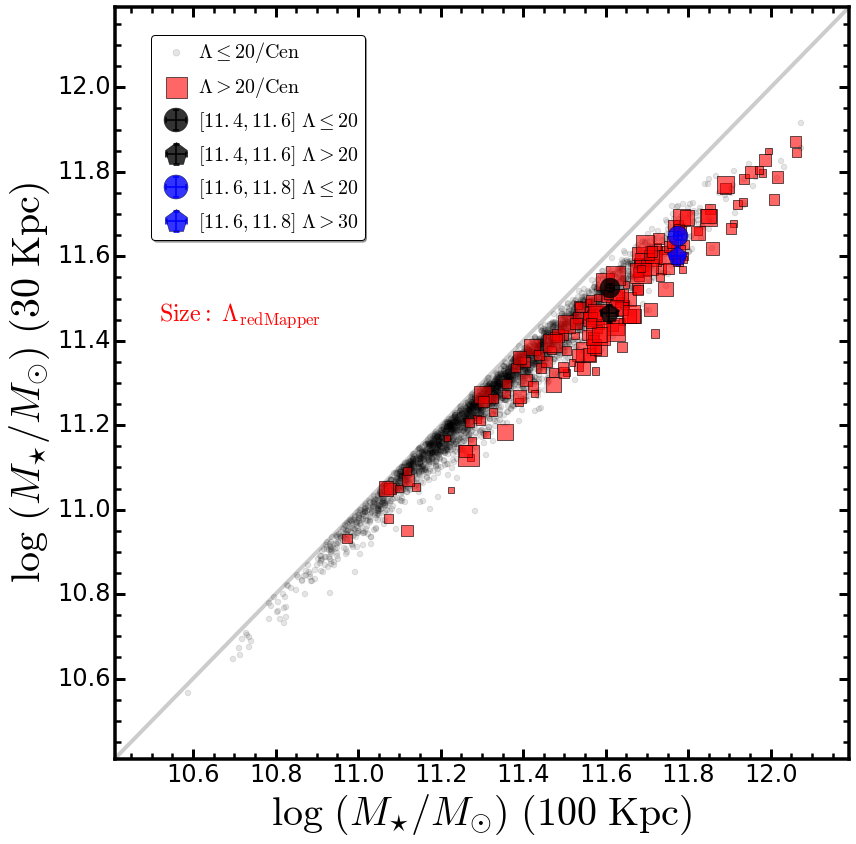

In [230]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.13, right=0.98, bottom=0.11, top=0.98)
ax1 = fig.add_subplot(111)

temp = np.asarray([10.0, 13.0])
ax1.plot(temp, temp, c='k', linestyle='-', linewidth=4.0, 
         alpha=0.2, zorder=0)

# Matched ones 
p1 = ax1.scatter(gamaClean['m100_c'], gamaClean['m30_c'], s=30.0, 
                 alpha=0.10, c='k', label='$\Lambda \leq 20\mathrm{/Cen}$')
p2 = ax1.scatter(bcgClean['m100_c'], bcgClean['m30_c'], 
                 s=((bcgTab['LAMBDA_CLUSTER'] - 12) * 5.2), 
                 alpha=0.60, c='r', label='$\Lambda > 20\mathrm{/Cen}$', marker='s')

# M1
ax1.errorbar(np.nanmedian(gamaM1['m100_c']),
             np.nanmedian(gamaM1['m30_c']), 
             marker='o', ms=20, mec='k',
             xerr=0.01, yerr=0.01, color='k', ecolor='k', capthick=2.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.4,11.6]}\ \Lambda \leq 20$')
ax1.errorbar(np.nanmedian(bcgM1['m100_c']),
             np.nanmedian(bcgM1['m30_c']), 
             marker='p', ms=20, mec='k', linewidth=4.0,
             xerr=0.02, yerr=0.02, mfc='k', ecolor='k', capthick=3.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.4,11.6]}\ \Lambda > 20$')

# M2
ax1.errorbar(np.nanmedian(gamaM2['m100_c']),
             np.nanmedian(gamaM2['m30_c']), 
             marker='o', ms=20, mec='k',
             xerr=0.01, yerr=0.01, color='b', ecolor='b', capthick=2.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.6,11.8]}\ \Lambda \leq 20$')
ax1.errorbar(np.nanmedian(bcgM2['m100_c']),
             np.nanmedian(bcgM2['m30_c']),
             marker='p', ms=20, mec='k',
             xerr=0.015, yerr=0.02, mfc='b', ecolor='b', capthick=3.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.6,11.8]}\ \Lambda > 30$')

# Legend
ax1.legend(loc=(0.05, 0.69), shadow=True, fancybox=True, 
           numpoints=1, fontsize=20, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.1)
ax1.text(0.06, 0.57, '$\mathrm{Size:}\ {\Lambda}_{\mathrm{redMapper}}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=24.0, transform=ax1.transAxes, color='r')

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ (\mathrm{100\ Kpc})$', size=40)
ax1.set_ylabel('$\log\ (M_{\star}/M_{\odot})\ (\mathrm{30\ Kpc})$', size=40)

# Axis limits
ax1.set_xlim(10.41, 12.19)
ax1.set_ylim(10.41, 12.19)

plt.show()

fig.savefig('../figure/hscMassive_m100_m30.png', dpi=230)

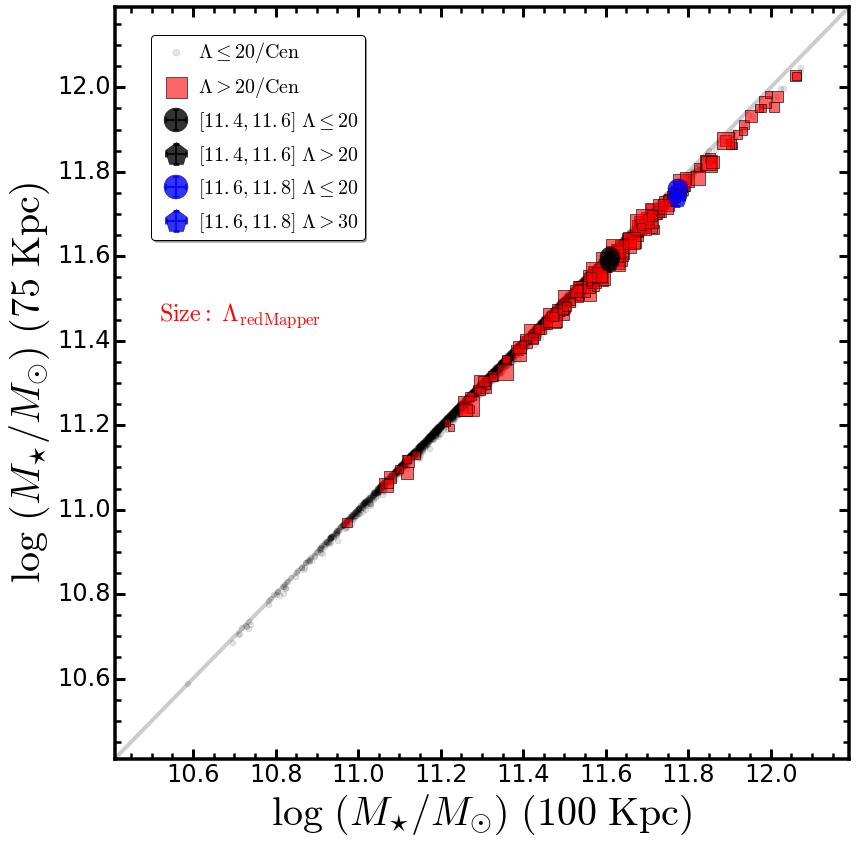

In [234]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.13, right=0.98, bottom=0.11, top=0.98)
ax1 = fig.add_subplot(111)

temp = np.asarray([10.0, 13.0])
ax1.plot(temp, temp, c='k', linestyle='-', linewidth=4.0, 
         alpha=0.2, zorder=0)

# Matched ones 
p1 = ax1.scatter(gamaClean['m100_c'], gamaClean['m75_c'], s=30.0, 
                 alpha=0.10, c='k', label='$\Lambda \leq 20\mathrm{/Cen}$')
p2 = ax1.scatter(bcgClean['m100_c'], bcgClean['m75_c'], 
                 s=((bcgTab['LAMBDA_CLUSTER'] - 12) * 5.2), 
                 alpha=0.60, c='r', label='$\Lambda > 20\mathrm{/Cen}$', marker='s')

# M1
ax1.errorbar(np.nanmedian(gamaM1['m100_c']),
             np.nanmedian(gamaM1['m75_c']), 
             marker='o', ms=20, mec='k',
             xerr=0.01, yerr=0.01, color='k', ecolor='k', capthick=2.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.4,11.6]}\ \Lambda \leq 20$')
ax1.errorbar(np.nanmedian(bcgM1['m100_c']),
             np.nanmedian(bcgM1['m75_c']), 
             marker='p', ms=20, mec='k', linewidth=4.0,
             xerr=0.02, yerr=0.02, mfc='k', ecolor='k', capthick=3.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.4,11.6]}\ \Lambda > 20$')

# M2
ax1.errorbar(np.nanmedian(gamaM2['m100_c']),
             np.nanmedian(gamaM2['m75_c']), 
             marker='o', ms=20, mec='k',
             xerr=0.01, yerr=0.01, color='b', ecolor='b', capthick=2.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.6,11.8]}\ \Lambda \leq 20$')
ax1.errorbar(np.nanmedian(bcgM2['m100_c']),
             np.nanmedian(bcgM2['m75_c']),
             marker='p', ms=20, mec='k',
             xerr=0.015, yerr=0.02, mfc='b', ecolor='b', capthick=3.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.6,11.8]}\ \Lambda > 30$')

# Legend
ax1.legend(loc=(0.05, 0.69), shadow=True, fancybox=True, 
           numpoints=1, fontsize=20, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.1)
ax1.text(0.06, 0.57, '$\mathrm{Size:}\ {\Lambda}_{\mathrm{redMapper}}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=24.0, transform=ax1.transAxes, color='r')

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ (\mathrm{100\ Kpc})$', size=40)
ax1.set_ylabel('$\log\ (M_{\star}/M_{\odot})\ (\mathrm{75\ Kpc})$', size=40)

# Axis limits
ax1.set_xlim(10.41, 12.19)
ax1.set_ylim(10.41, 12.19)

plt.show()

fig.savefig('../figure/hscMassive_m100_m75.png', dpi=230)

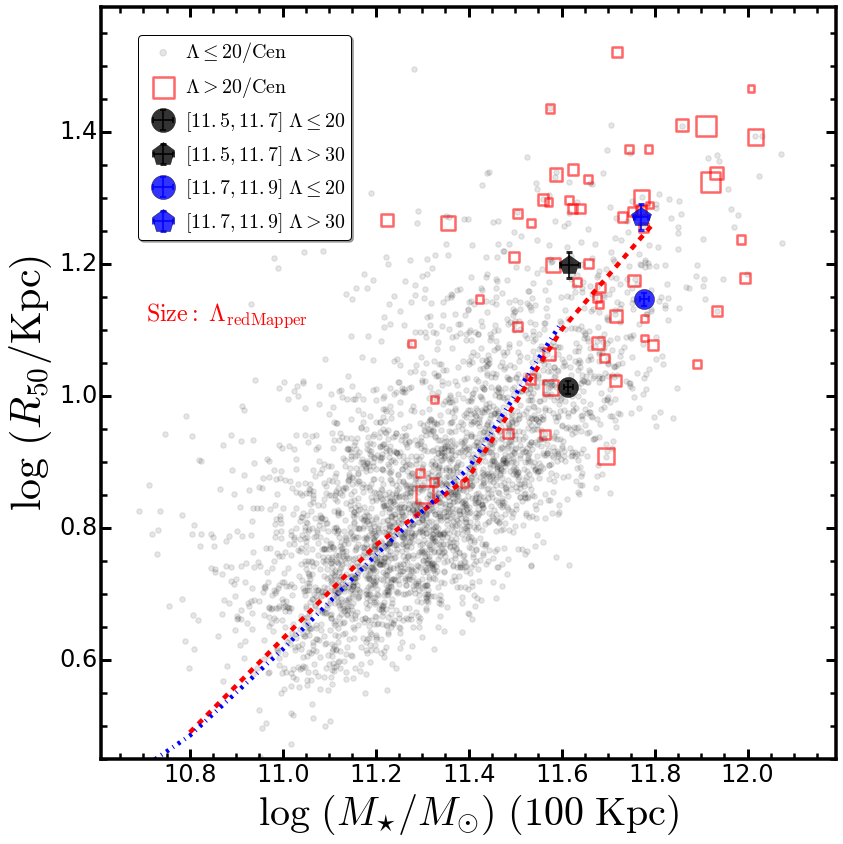

In [855]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.13, right=0.98, bottom=0.11, top=0.98)
ax1 = fig.add_subplot(111)

mc = np.asarray([10.8, 11.2, 11.4, 11.6, 11.8])
rc = np.asarray([0.49, 0.774, 0.877, 1.101, 1.264])

ms = np.asarray([10.6, 10.8, 11.0, 11.2, 11.4, 11.6])
rs = np.asarray([0.389, 0.485, 0.616, 0.759, 0.891, 1.112])
ax1.plot(mc, rc, linestyle='--', linewidth=4.5, c='r')
ax1.plot(ms, rs, linestyle='-.', linewidth=4.5, c='b')

#temp = np.asarray([10.0, 13.0])
#ax1.plot(temp, temp, c='k', linestyle='-', linewidth=4.0, 
#         alpha=0.2, zorder=0)

# Matched ones 
p1 = ax1.scatter(gamaUse['m100_c'], np.log10(gamaUse['r50_120']), s=30.0, 
                 alpha=0.10, c='k', label='$\Lambda \leq 20\mathrm{/Cen}$')
p2 = ax1.scatter(bcgUse['m100_c'], np.log10(bcgUse['r50_120']), 
                 s=((bcgTab['LAMBDA_CLUSTER'] - 12) * 5.2), 
                 alpha=0.60, facecolor='none', edgecolor='r', 
                 label='$\Lambda > 20\mathrm{/Cen}$', marker='s', linewidth=2.5)
# M1
ax1.errorbar(np.nanmedian(gamaM1['m100_c']),
             np.nanmedian(np.log10(gamaM1['r50_120'])), 
             marker='o', ms=20, mec='k',
             xerr=0.01, yerr=0.01, color='k', ecolor='k', capthick=2.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.5,11.7]}\ \Lambda \leq 20$')
ax1.errorbar(np.nanmedian(bcgM1['m100_c']),
             np.nanmedian(np.log10(bcgM1['r50_120'])), 
             marker='p', ms=20, mec='k', linewidth=4.0,
             xerr=0.02, yerr=0.02, mfc='k', ecolor='k', capthick=3.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.5,11.7]}\ \Lambda > 30$')

# M2
ax1.errorbar(np.nanmedian(gamaM2['m100_c']),
             np.nanmedian(np.log10(gamaM2['r50_120'])), 
             marker='o', ms=20, mec='k',
             xerr=0.01, yerr=0.01, color='b', ecolor='b', capthick=2.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.7,11.9]}\ \Lambda \leq 20$')
ax1.errorbar(np.nanmedian(bcgM2['m100_c']),
             np.nanmedian(np.log10(bcgM2['r50_120'])),
             marker='p', ms=20, mec='k',
             xerr=0.015, yerr=0.02, mfc='b', ecolor='b', capthick=3.0, alpha=0.8,
             fmt='h', elinewidth=2.0, label='$\mathrm{[11.7,11.9]}\ \Lambda > 30$')

# Legend
ax1.legend(loc=(0.05, 0.69), shadow=True, fancybox=True, 
           numpoints=1, fontsize=20, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.1)
ax1.text(0.06, 0.57, '$\mathrm{Size:}\ {\Lambda}_{\mathrm{redMapper}}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=24.0, transform=ax1.transAxes, color='r')

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ (\mathrm{100\ Kpc})$', size=40)
ax1.set_ylabel('$\log\ (R_{50}/\mathrm{Kpc})$', size=42)

# Axis limits
ax1.set_xlim(10.61, 12.19)
ax1.set_ylim(0.45, 1.59)

plt.show()

#fig.savefig('../figure/hscMassive_m100_m5.png', dpi=230)

# Average Profiles

In [756]:
mpC13_1 = Table.read('cooper13_13.5-14.0_all.dat', format='ascii')
mpC13_2 = Table.read('cooper13_13.5-14.0_insitu.dat', format='ascii')
mpC13_3 = Table.read('cooper13_13.5-14.0_accreted.dat', format='ascii')

# Cooper 2013: 13.5 < logM_halo < 14.0
"""
ax1.plot((10.0 ** mpC13_2['col1']) ** 0.25, mpC13_2['col2'], linewidth=4.5, 
         c='m', alpha=0.9)
ax1.plot((10.0 ** mpC13_3['col1']) ** 0.25, mpC13_3['col2'], linewidth=4.5, 
         c='c', alpha=0.9)
ax1.plot((10.0 ** mpC13_1['col1']) ** 0.25, mpC13_1['col2'], linewidth=4.5, 
         c='b', alpha=0.9)
"""

"\nax1.plot((10.0 ** mpC13_2['col1']) ** 0.25, mpC13_2['col2'], linewidth=4.5, \n         c='m', alpha=0.9)\nax1.plot((10.0 ** mpC13_3['col1']) ** 0.25, mpC13_3['col2'], linewidth=4.5, \n         c='c', alpha=0.9)\nax1.plot((10.0 ** mpC13_1['col1']) ** 0.25, mpC13_1['col2'], linewidth=4.5, \n         c='b', alpha=0.9)\n"

In [757]:
prof_bcg_m1 = getStackProfiles(bcgM1, bcgDir, name='test_bcg_m1')
prof_gama_m1 = getStackProfiles(gamaM1, gamaDir, name='test_gama_m1')
prof_mem_m1 = getStackProfiles(memM1, memDir, name='test_mem_m1')

## Sample test_bcg_m1 : Will deal with 25 galaxies

## Save test_bcg_m1 to /Users/songhuang/work/hscs/gama_massive/sbp/redbcg/test_bcg_m1_profs.pkl
## Sample test_gama_m1 : Will deal with 344 galaxies

## Save test_gama_m1 to /Users/songhuang/work/hscs/gama_massive/sbp/gama/test_gama_m1_profs.pkl
## Sample test_mem_m1 : Will deal with 24 galaxies

## Save test_mem_m1 to /Users/songhuang/work/hscs/gama_massive/sbp/redmem/test_mem_m1_profs.pkl


In [758]:
prof_bcg_m2 = getStackProfiles(bcgM2, bcgDir, name='test_bcg_m2')
prof_gama_m2 = getStackProfiles(gamaM2, gamaDir, name='test_gama_m2')
prof_mem_m2 = getStackProfiles(memM2, memDir, name='test_mem_m2')

## Sample test_bcg_m2 : Will deal with 17 galaxies

## Save test_bcg_m2 to /Users/songhuang/work/hscs/gama_massive/sbp/redbcg/test_bcg_m2_profs.pkl
## Sample test_gama_m2 : Will deal with 110 galaxies

## Save test_gama_m2 to /Users/songhuang/work/hscs/gama_massive/sbp/gama/test_gama_m2_profs.pkl
## Sample test_mem_m2 : Will deal with 8 galaxies

## Save test_mem_m2 to /Users/songhuang/work/hscs/gama_massive/sbp/redmem/test_mem_m2_profs.pkl


In [759]:
prof_bcg_m2b = getStackProfiles(bcgM2b, bcgDir, name='test_bcg_m2b')
prof_gama_m2b = getStackProfiles(gamaM2b, gamaDir, name='test_gama_m2b')

## Sample test_bcg_m2b : Will deal with 23 galaxies

## Save test_bcg_m2b to /Users/songhuang/work/hscs/gama_massive/sbp/redbcg/test_bcg_m2b_profs.pkl
## Sample test_gama_m2b : Will deal with 136 galaxies

## Save test_gama_m2b to /Users/songhuang/work/hscs/gama_massive/sbp/gama/test_gama_m2b_profs.pkl


In [792]:
prof_bcg_cm1 = getStackProfiles(bcgCM1, bcgDir, name='test_bcg_cm1')
prof_gama_cm1 = getStackProfiles(gamaCM1, gamaDir, name='test_gama_cm1')
prof_mem_cm1 = getStackProfiles(memCM1, memDir, name='test_mem_cm1')

## Sample test_bcg_cm1 : Will deal with 15 galaxies

## Save test_bcg_cm1 to /Users/songhuang/work/hscs/gama_massive/sbp/redbcg/test_bcg_cm1_profs.pkl
## Sample test_gama_cm1 : Will deal with 676 galaxies

## Save test_gama_cm1 to /Users/songhuang/work/hscs/gama_massive/sbp/gama/test_gama_cm1_profs.pkl
## Sample test_mem_cm1 : Will deal with 75 galaxies

## Save test_mem_cm1 to /Users/songhuang/work/hscs/gama_massive/sbp/redmem/test_mem_cm1_profs.pkl


In [793]:
prof_bcg_cm2 = getStackProfiles(bcgCM2, bcgDir, name='test_bcg_cm2')
prof_gama_cm2 = getStackProfiles(gamaCM2, gamaDir, name='test_gama_cm2')
prof_mem_cm2 = getStackProfiles(memCM2, memDir, name='test_mem_cm2')

## Sample test_bcg_cm2 : Will deal with 13 galaxies

## Save test_bcg_cm2 to /Users/songhuang/work/hscs/gama_massive/sbp/redbcg/test_bcg_cm2_profs.pkl
## Sample test_gama_cm2 : Will deal with 214 galaxies

## Save test_gama_cm2 to /Users/songhuang/work/hscs/gama_massive/sbp/gama/test_gama_cm2_profs.pkl
## Sample test_mem_cm2 : Will deal with 12 galaxies

## Save test_mem_cm2 to /Users/songhuang/work/hscs/gama_massive/sbp/redmem/test_mem_cm2_profs.pkl


In [794]:
prof_bcg_cm1b = getStackProfiles(bcgCM1b, bcgDir, name='test_bcg_cm1b')
prof_gama_cm1b = getStackProfiles(gamaCM1b, gamaDir, name='test_gama_cm1b')

## Sample test_bcg_cm1b : Will deal with 27 galaxies

## Save test_bcg_cm1b to /Users/songhuang/work/hscs/gama_massive/sbp/redbcg/test_bcg_cm1b_profs.pkl
## Sample test_gama_cm1b : Will deal with 475 galaxies

## Save test_gama_cm1b to /Users/songhuang/work/hscs/gama_massive/sbp/gama/test_gama_cm1b_profs.pkl


In [760]:
bm1_sm, bm1_mm, bm1_amg, bm1_stdm = organizeSbp(prof_bcg_m1, col1='muI1', 
                                                col2='LOGM2LI_C', kind='mass')
mm1_sm, mm1_mm, mm1_amg, mm1_stdm = organizeSbp(prof_mem_m1, col1='muI1', 
                                                col2='LOGM2LI_C', kind='mass')
gm1_sm, gm1_mm, gm1_amg, gm1_stdm = organizeSbp(prof_gama_m1, col1='muI1', 
                                                col2='LOGM2LI_C', kind='mass')

bm1s_sm, bm1s_mm, bm1s_amg, bm1s_stdm = organizeSbp(prof_bcg_m1, col1='muI3', 
                                                    col2='LOGM2LI_C', kind='mass')
mm1s_sm, mm1s_mm, mm1s_amg, mm1s_stdm = organizeSbp(prof_mem_m1, col1='muI3', 
                                                    col2='LOGM2LI_C', kind='mass')
gm1s_sm, gm1s_mm, gm1s_amg, gm1s_stdm = organizeSbp(prof_gama_m1, col1='muI3', 
                                                    col2='LOGM2LI_C', kind='mass')

In [761]:
bm2_sm, bm2_mm, bm2_amg, bm2_stdm = organizeSbp(prof_bcg_m2, col1='muI1', 
                                                col2='LOGM2LI_C', kind='mass')
mm2_sm, mm2_mm, mm2_amg, mm2_stdm = organizeSbp(prof_mem_m2, col1='muI2', 
                                                col2='LOGM2LI_C', kind='mass')
gm2_sm, gm2_mm, gm2_amg, gm2_stdm = organizeSbp(prof_gama_m2, col1='muI1', 
                                                col2='LOGM2LI_C', kind='mass')

indexMem = np.where(RSMA_COMMON <= 4.1)
bm2s_sm, bm2s_mm, bm2s_amg, bm2s_stdm = organizeSbp(prof_bcg_m2, col1='muI3', 
                                                    col2='LOGM2LI_C', kind='mass',
                                                    index=indexMem)
mm2s_sm, mm2s_mm, mm2s_amg, mm2s_stdm = organizeSbp(prof_mem_m2, col1='muI3', 
                                                    col2='LOGM2LI_C', kind='mass',
                                                    index=indexMem)
gm2s_sm, gm2s_mm, gm2s_amg, gm2s_stdm = organizeSbp(prof_gama_m2, col1='muI3', 
                                                    col2='LOGM2LI_C', kind='mass',
                                                    index=indexMem)

bm2b_sm, bm2b_mm, bm2b_amg, bm2b_stdm = organizeSbp(prof_bcg_m2b, col1='muI1', 
                                                    col2='LOGM2LI_C', kind='mass')
gm2b_sm, gm2b_mm, gm2b_amg, gm2b_stdm = organizeSbp(prof_gama_m2b, col1='muI1', 
                                                    col2='LOGM2LI_C', kind='mass')

bm2l_sm, bm2l_mm, bm2l_amg, bm2l_stdm = organizeSbp(prof_bcg_m2b, col1='muI3', 
                                                    col2='LOGM2LI_C', kind='mass')
gm2l_sm, gm2l_mm, gm2l_amg, gm2l_stdm = organizeSbp(prof_gama_m2b, col1='muI3', 
                                                    col2='LOGM2LI_C', kind='mass')

In [795]:
bcm1_sm, bcm1_mm, bcm1_amg, bcm1_stdm = organizeSbp(prof_bcg_cm1, col1='muI1', 
                                                    col2='LOGM2LI_C', kind='mass')
mcm1_sm, mcm1_mm, mcm1_amg, mcm1_stdm = organizeSbp(prof_mem_cm1, col1='muI1', 
                                                    col2='LOGM2LI_C', kind='mass')
gcm1_sm, gcm1_mm, gcm1_amg, gcm1_stdm = organizeSbp(prof_gama_cm1, col1='muI1', 
                                                    col2='LOGM2LI_C', kind='mass')

bcm1b_sm, bcm1b_mm, bcm1b_amg, bcm1b_stdm = organizeSbp(prof_bcg_cm1, col1='muI3', 
                                                        col2='LOGM2LI_C', kind='mass')

gcm1b_sm, gcm1b_mm, gcm1b_amg, gcm1b_stdm = organizeSbp(prof_gama_cm1, col1='muI3', 
                                                        col2='LOGM2LI_C', kind='mass')

In [796]:
bcm1c_sm, bcm1c_mm, bcm1c_amg, bcm1c_stdm = organizeSbp(prof_bcg_cm1b, col1='muI1', 
                                                        col2='LOGM2LI_C', kind='mass')

gcm1c_sm, gcm1c_mm, gcm1c_amg, gcm1c_stdm = organizeSbp(prof_gama_cm1b, col1='muI1', 
                                                        col2='LOGM2LI_C', kind='mass')

bcm1d_sm, bcm1d_mm, bcm1d_amg, bcm1d_stdm = organizeSbp(prof_bcg_cm1b, col1='muI3', 
                                                        col2='LOGM2LI_C', kind='mass')

gcm1d_sm, gcm1d_mm, gcm1d_amg, gcm1d_stdm = organizeSbp(prof_gama_cm1b, col1='muI3', 
                                                        col2='LOGM2LI_C', kind='mass')

In [797]:
bcm2_sm, bcm2_mm, bcm2_amg, bcm2_stdm = organizeSbp(prof_bcg_cm2, col1='muI1', 
                                                    col2='LOGM2LI_C', kind='mass')

gcm2_sm, gcm2_mm, gcm2_amg, gcm2_stdm = organizeSbp(prof_gama_cm2, col1='muI1', 
                                                    col2='LOGM2LI_C', kind='mass')
mcm2_sm, mcm2_mm, mcm2_amg, mcm2_stdm = organizeSbp(prof_mem_cm2, col1='muI2', 
                                                    col2='LOGM2LI_C', kind='mass')
bcm2b_sm, bcm2b_mm, bcm2b_amg, bcm2b_stdm = organizeSbp(prof_bcg_cm2, col1='muI3', 
                                                        col2='LOGM2LI_C', kind='mass')

gcm2b_sm, gcm2b_mm, gcm2b_amg, gcm2b_stdm = organizeSbp(prof_gama_cm2, col1='muI3', 
                                                        col2='LOGM2LI_C', kind='mass')

In [241]:
# Curve of growth

indGrowth = np.where((RSMA_COMMON ** 4.0) >= 2.0)

gm1_sg, gm1_mg, gm1_ag, gm1_dg = organizeSbp(prof_gama_m1, col1='lumI1', col2='LUM_100', kind='lum', 
                                             index=indGrowth)
mm1_sg, mm1_mg, mm1_ag, mm1_dg = organizeSbp(prof_mem_m1, col1='lumI1', col2='LUM_100', kind='lum', 
                                             index=indGrowth)
bm1_sg, bm1_mg, bm1_ag, bm1_dg = organizeSbp(prof_bcg_m1, col1='lumI1', col2='LUM_100', kind='lum', 
                                             index=indGrowth)

gm2_sg, gm2_mg, gm2_ag, gm2_dg = organizeSbp(prof_gama_m2, col1='lumI1', col2='LOGM2LI_C', 
                                             kind='mass')
mm2_sg, mm2_mg, mm2_ag, mm2_dg = organizeSbp(prof_mem_m2, col1='lumI1', col2='LUM_100', kind='lum', 
                                             index=indGrowth)
bm2_sg, bm2_mg, bm2_ag, bm2_dg = organizeSbp(prof_bcg_m2, col1='lumI1', col2='LUM_100', kind='lum', 
                                             index=indGrowth)

In [245]:
gm2_sg, gm2_mg, gm2_ag, gm2_dg = organizeSbp(prof_gama_m2, col1='lumI1', col2='LOGM2LI_C', 
                                             kind='mass', index=indGrowth)
bm2_sg, bm2_mg, bm2_ag, bm2_dg = organizeSbp(prof_bcg_m2, col1='lumI1', col2='LOGM2LI_C', 
                                             kind='mass', index=indGrowth)

## Mix the BCG and GAMA sample, random draw N_BCG from it, and calculte the median profile

In [762]:
mixM1_sm = np.vstack([gm1_sm, mm1_sm, bm1_sm])
randM1_sm = []
ii = 0
while ii < 8000:
    mprof = np.nanmedian(mixM1_sm[np.random.choice(len(mixM1_sm), len(bm1_sm), 
                                                   replace=False)], axis=0)
    randM1_sm.append(mprof)
    ii += 1 

In [763]:
mixM2_sm = np.vstack([gm2_sm, mm2_sm, bm2_sm])
randM2_sm = []
ii = 0
while ii < 8000:
    mprof = np.nanmedian(mixM2_sm[np.random.choice(len(mixM2_sm), len(bm2_sm), 
                                                   replace=False)], axis=0)
    randM2_sm.append(mprof)
    ii += 1 

In [764]:
mixM2b_sm = np.vstack([gm2b_sm, bm2b_sm])
randM2b_sm = []
ii = 0
while ii < 8000:
    mprof = np.nanmedian(mixM2b_sm[np.random.choice(len(mixM2b_sm), len(bm2b_sm), 
                                                    replace=False)], axis=0)
    randM2b_sm.append(mprof)
    ii += 1 

In [798]:
mixCM1_sm = np.vstack([gcm1_sm, mcm1_sm, bcm1_sm])
randCM1_sm = []
ii = 0
while ii < 8000:
    mprof = np.nanmedian(mixCM1_sm[np.random.choice(len(mixCM1_sm), len(bcm1_sm), 
                                                   replace=False)], axis=0)
    randCM1_sm.append(mprof)
    ii += 1

In [799]:
mixCM1b_sm = np.vstack([gcm1b_sm, bcm1b_sm])
randCM1b_sm = []
ii = 0
while ii < 8000:
    mprof = np.nanmedian(mixCM1b_sm[np.random.choice(len(mixCM1b_sm), len(bcm1b_sm), 
                                                     replace=False)], axis=0)
    randCM1b_sm.append(mprof)
    ii += 1

In [800]:
mixCM2_sm = np.vstack([gcm2_sm, mcm2_sm, bcm2_sm])
randCM2_sm = []
ii = 0
while ii < 8000:
    mprof = np.nanmedian(mixCM2_sm[np.random.choice(len(mixCM2_sm), len(bcm2_sm), 
                                                   replace=False)], axis=0)
    randCM2_sm.append(mprof)
    ii += 1 

In [766]:
indInt = np.where((RSMA_COMMON ** 4.0) <= 100.01)

print(np.log10(np.trapz((10.0 ** bm2_mm[2][indInt]), 
                        x=np.pi * ((RSMA_COMMON[indInt] ** 4.0) ** 2.0))))
print(np.log10(np.trapz((10.0 ** gm2_mm[2][indInt]), 
                        x=np.pi * ((RSMA_COMMON[indInt] ** 4.0) ** 2.0))))

print(np.log10(np.trapz((10.0 ** bm1_mm[2][indInt]), 
                        x=np.pi * ((RSMA_COMMON[indInt] ** 4.0) ** 2.0))))
print(np.log10(np.trapz((10.0 ** gm1_mm[2][indInt]), 
                        x=np.pi * ((RSMA_COMMON[indInt] ** 4.0) ** 2.0))))

11.4784350179
11.5438205328
11.3398766334
11.371478145


In [860]:
SBP1 = [0.125, 0.07, 0.865, 0.30]
SBP2 = [0.125, 0.37, 0.865, 0.59]

## M1: 11.5 < logM(<100 Kpc) < 11.7

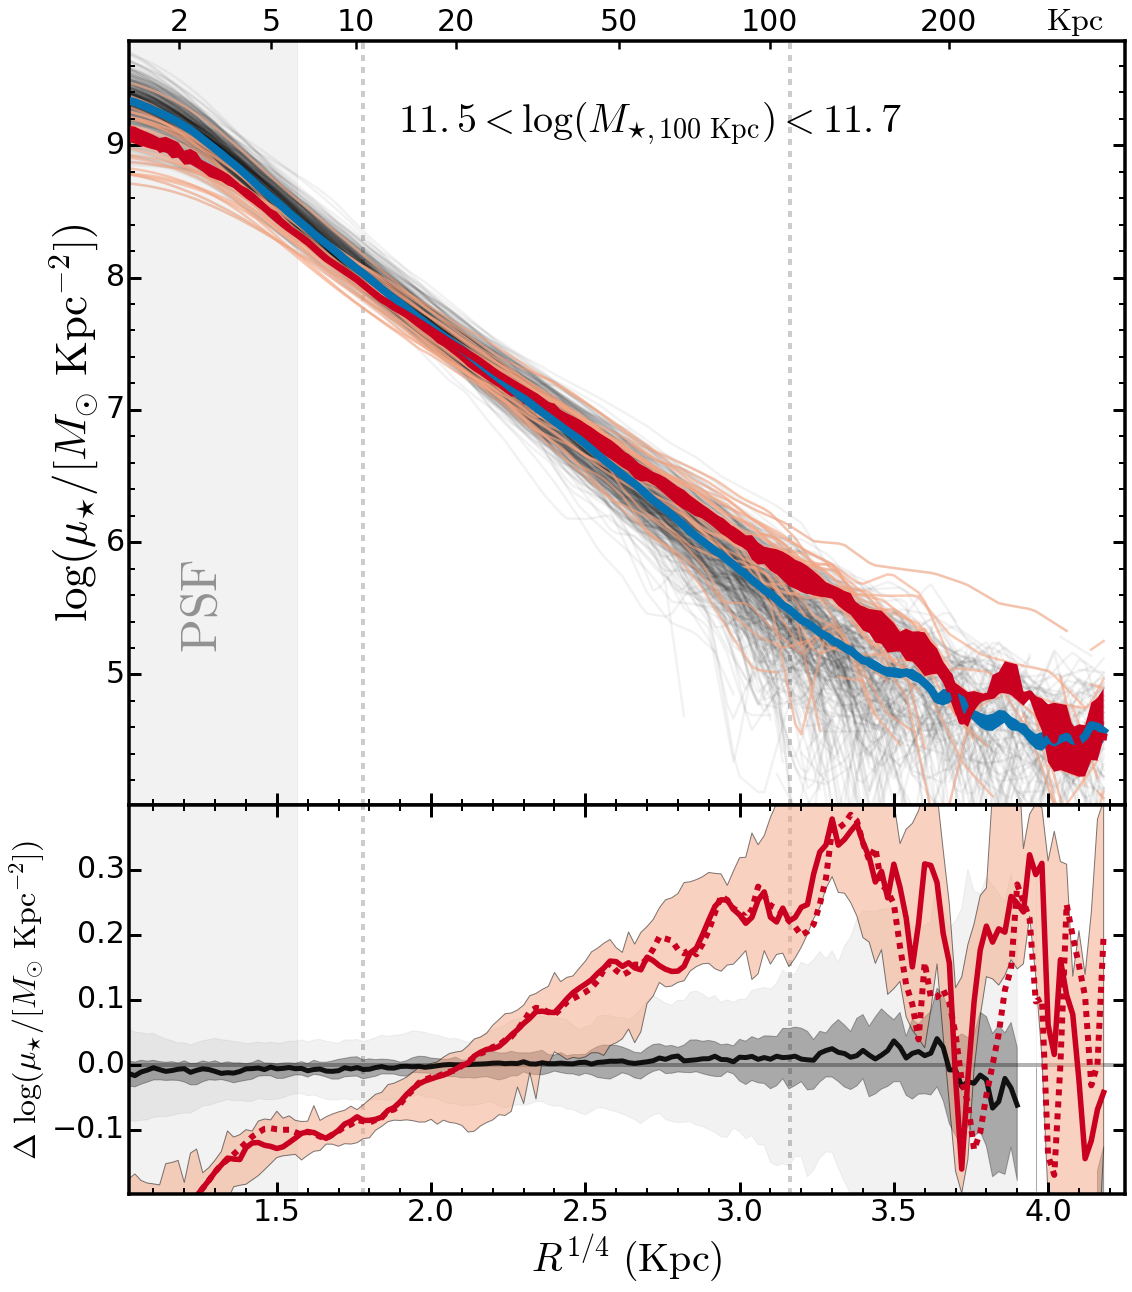

In [861]:
# --------------------------------------------------------------------------------------- #
## Setup up figure
fig = plt.figure(figsize=(16, 18))

ax1 = plt.axes(SBP2)
ax3 = plt.axes(SBP1)

########################################################################################
## Region affected by PSF
# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 6.0**0.25], [2.0, 2.0], [11.0, 11.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
## Mark the two interesting radius
# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

########################################################################################
## Individual profiles
for gg in gm1_sm:
    ax1.plot(RSMA_COMMON, gg, c='k', alpha=0.05, linewidth=2.5)
for bb in bm1_sm:
    ax1.plot(RSMA_COMMON, bb, c=RED0, alpha=0.60, linewidth=2.5)

## Median profiles
ax1.fill_between(RSMA_COMMON, gm1_mm[0], gm1_mm[1], 
                 facecolor=BLUE1, edgecolor='none', alpha=1.0, zorder=1005)
ax1.fill_between(RSMA_COMMON, bm1_mm[0], bm1_mm[1], 
                 facecolor=RED1, edgecolor='none', alpha=1.0, zorder=1005)

ax1.plot(RSMA_COMMON, gm1_mm[2], linestyle='-', linewidth=8.0, 
         c=BLUE1, alpha=1.0, zorder=1010)
#ax1.plot(RSMA_COMMON, gm1b_mm[2], linestyle='--', linewidth=4.0, 
#         c=BLUE1, alpha=1.0, zorder=1010)

ax1.plot(RSMA_COMMON, bm1_mm[2], linestyle='-', linewidth=7.0, 
         c=RED1, alpha=1.0, zorder=1010)
#ax1.plot(RSMA_COMMON, bm1b_mm[2], linestyle='-.', linewidth=4.0, 
#         c=RED1, alpha=1.0, zorder=1010)

## Label the mass range
ax1.text(0.27, 0.86, '$11.5 < \log (M_{\star, 100\ \mathrm{Kpc}}) < 11.7$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=40.0, transform=ax1.transAxes, weight='heavy')

## X, Y Lables
ax1.set_ylabel('$\log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=45)

## Ticks
ax1.minorticks_on()
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
ax1.tick_params('both', length=12, width=3, which='major')
ax1.tick_params('both', length=6, width=2, which='minor')

## Remove the X-axis label
ax1.xaxis.set_major_formatter(NullFormatter())

## Width of the axes
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

## Label the PSF region 
ax1.text(0.05, 0.20, '$\mathrm{PSF}$', rotation='vertical',
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=50.0, transform=ax1.transAxes, weight='bold', 
         color='k', alpha=0.4)

## X, Y limits
ax1.set_xlim(1.02, 4.25)
ax1.set_ylim(4.01, 9.79)

########################################################################################
# Secondary Axis 
ax2 = ax1.twiny()
kpcs = np.asarray([2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0])
kpcTicks= (kpcs ** 0.25)
ax2.set_xlim(1.02, 4.35)
ax2.set_ylim(4.01, 9.79)
ax2.set_xticks(kpcTicks)
ax2.set_xticklabels(['{:g}'.format(kpc) for kpc in kpcs], fontsize=30)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
ax2.text(0.92, 1.0035, '$\mathrm{Kpc}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=32.0, transform=ax2.transAxes)

########################################################################################

## Highlight zero 
ax3.axhline(0.0, linewidth=4.0, c='k', linestyle='-', zorder=0, alpha=0.3)

# 10 Kpc 
ax3.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax3.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

# z = 0.4 : 1"=5.4 Kpc
ax3.fill_between([0.0, 6.0**0.25], [-2.0, -2.0], [2.0, 2.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
         
ax3.fill_between(RSMA_COMMON, 
                 np.percentile(randM1_sm - gm1_mm[2], 3, axis=0), 
                 np.percentile(randM1_sm - gm1_mm[2], 97, axis=0), 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
ax3.fill_between(RSMA_COMMON, 
                 np.percentile(randM1_sm - gm1_mm[2], 31, axis=0), 
                 np.percentile(randM1_sm - gm1_mm[2], 69, axis=0), 
                 facecolor='k', edgecolor='k', alpha=0.30, zorder=0)
ax3.plot(RSMA_COMMON, np.percentile(randM1_sm - gm1_mm[2], 50, axis=0), 
         c='k', linewidth=5.0, linestyle='-', alpha=0.9)


ax3.fill_between(RSMA_COMMON, 
                 (bm1_mm[0] - gm1_mm[1]), (bm1_mm[1] - gm1_mm[0]),
                 facecolor=RED0, edgecolor='k', alpha=0.50, zorder=1)
ax3.plot(RSMA_COMMON, bm1_mm[2] - gm1_mm[2], c=RED1, linewidth=5.5, 
         linestyle='-')
ax3.plot(RSMA_COMMON, bm1s_mm[2] - gm1s_mm[2], c=RED1, linewidth=6.0, 
         linestyle='--')

ax3.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=40)
ax3.set_ylabel('$\Delta\ \log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=32)

ax3.set_xlim(1.02, 4.25)
ax3.set_ylim(-0.199, 0.399)


# Axes setup
# Minor Ticks on 
ax3.minorticks_on()
ax3.tick_params(axis='y', which='minor', left='off', right='off')

for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
ax3.tick_params('both', length=12, width=3, which='major')
ax3.tick_params('both', length=6, width=2, which='minor')

ax3.spines['top'].set_linewidth(3.5)
ax3.spines['right'].set_linewidth(3.5)
ax3.spines['bottom'].set_linewidth(3.5)
ax3.spines['left'].set_linewidth(3.5)



########################################################################################
plt.show()

fig.savefig('../figure/hscMassive_mprof_m1_test.png', dpi=230)

## M2: 11.7 < logM < 11.9

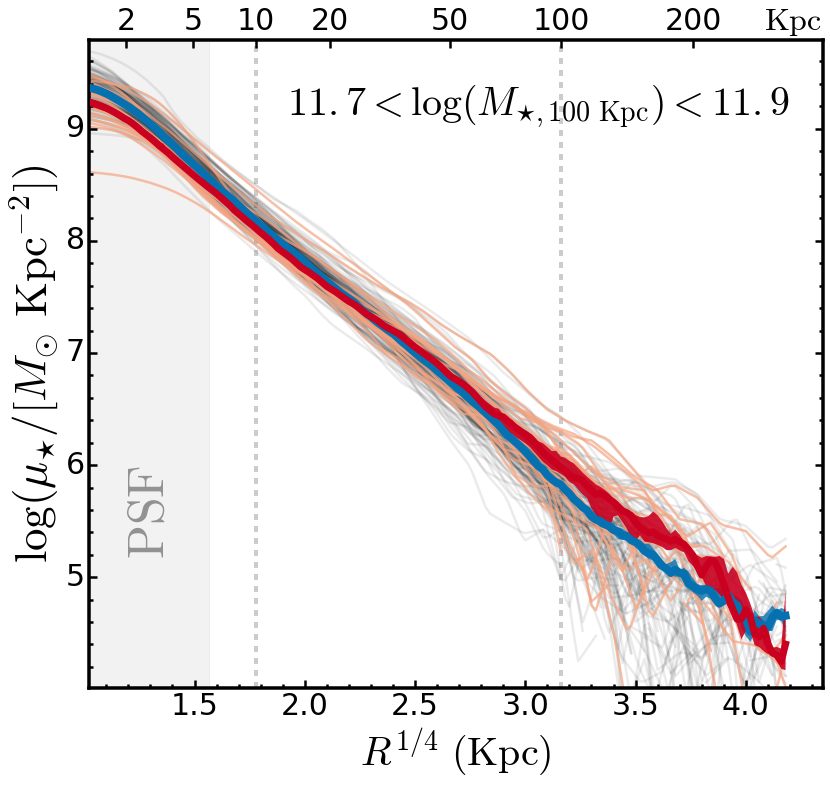

In [784]:
# --------------------------------------------------------------------------------------- #
## Setup up figure
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

########################################################################################
## Region affected by PSF
# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 6.0**0.25], [2.0, 2.0], [11.0, 11.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
## Mark the two interesting radius
# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

########################################################################################
## Individual profiles
for gg in gm2b_sm:
    ax1.plot(RSMA_COMMON, gg, c='k', alpha=0.08, linewidth=2.5)
for bb in bm2b_sm:
    ax1.plot(RSMA_COMMON, bb, c=RED0, alpha=0.70, linewidth=2.5)

## Median profiles
ax1.fill_between(RSMA_COMMON, gm2b_mm[0], gm2b_mm[1], 
                 facecolor=BLUE1, edgecolor='none', alpha=0.8, zorder=1005)
ax1.fill_between(RSMA_COMMON, bm2b_mm[0], bm2b_mm[1], 
                 facecolor=RED1, edgecolor='none', alpha=0.9, zorder=1005)

ax1.plot(RSMA_COMMON, gm2b_mm[2], linestyle='-', linewidth=8.0, 
         c=BLUE1, alpha=1.0, zorder=1010)
#ax1.plot(RSMA_COMMON, gm2b_mm[2], linestyle='--', linewidth=4.0, 
#         c=BLUE1, alpha=1.0, zorder=1010)

ax1.plot(RSMA_COMMON, bm2b_mm[2], linestyle='-', linewidth=7.0, 
         c=RED1, alpha=1.0, zorder=1010)
#ax1.plot(RSMA_COMMON, bm2b_mm[2], linestyle='-.', linewidth=4.0, 
#         c=RED1, alpha=1.0, zorder=1010)

## Label the mass range
ax1.text(0.27, 0.86, '$11.7 < \log (M_{\star, 100\ \mathrm{Kpc}}) < 11.9$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=40.0, transform=ax1.transAxes, weight='heavy')

## X, Y Lables
ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=40)
ax1.set_ylabel('$\log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=45)

## Ticks
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
## Width of the axes
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

## Label the PSF region 
ax1.text(0.05, 0.20, '$\mathrm{PSF}$', rotation='vertical',
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=50.0, transform=ax1.transAxes, weight='bold', 
         color='k', alpha=0.4)

## X, Y limits
ax1.set_xlim(1.02, 4.35)
ax1.set_ylim(4.01, 9.79)

########################################################################################
# Secondary Axis 
ax2 = ax1.twiny()
kpcs = np.asarray([2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0])
kpcTicks= (kpcs ** 0.25)
ax2.set_xlim(1.02, 4.35)
ax2.set_ylim(4.01, 9.79)
ax2.set_xticks(kpcTicks)
ax2.set_xticklabels(['{:g}'.format(kpc) for kpc in kpcs], fontsize=30)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
ax2.text(0.92, 1.003, '$\mathrm{Kpc}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=32.0, transform=ax2.transAxes)

########################################################################################
plt.show()

fig.savefig('../figure/hscMassive_mprof_m2_test.png', dpi=230)

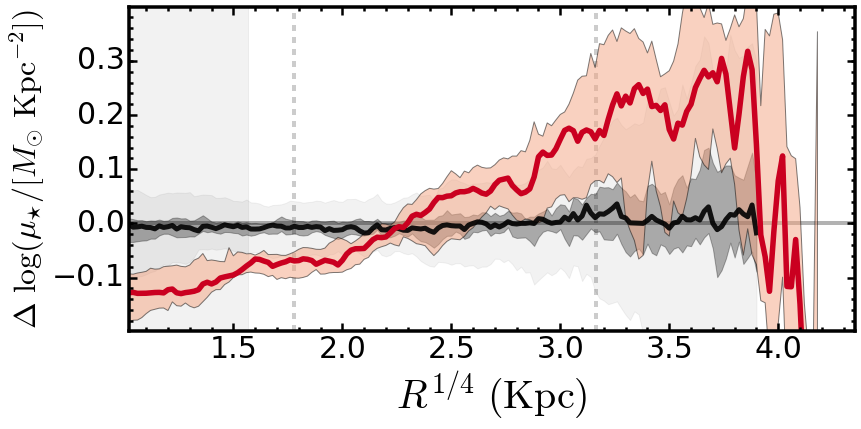

In [828]:
# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0.11, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

ax1.axhline(0.0, linewidth=4.0, c='k', linestyle='-', zorder=0, alpha=0.3)

# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 6.0**0.25], [-2.0, -2.0], [2.0, 2.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
         
ax1.fill_between(RSMA_COMMON, 
                 np.percentile(randM2_sm - gm2_mm[2], 3, axis=0), 
                 np.percentile(randM2_sm - gm2_mm[2], 97, axis=0), 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
ax1.fill_between(RSMA_COMMON, 
                 np.percentile(randM2_sm - gm2_mm[2], 31, axis=0), 
                 np.percentile(randM2_sm - gm2_mm[2], 69, axis=0), 
                 facecolor='k', edgecolor='k', alpha=0.30, zorder=0)

ax1.plot(RSMA_COMMON, np.percentile(randM2_sm - gm2_mm[2], 50, axis=0), 
         c='k', linewidth=5.0, linestyle='-', alpha=0.9)


ax1.fill_between(RSMA_COMMON, 
                 (bm2b_mm[0] - gm2b_mm[1]), (bm2b_mm[1] - gm2b_mm[0]),
                 facecolor=RED0, edgecolor='k', alpha=0.50, zorder=1)
ax1.plot(RSMA_COMMON, bm2b_mm[2] - gm2b_mm[2], c=RED1, linewidth=5.5, 
         linestyle='-')

#ax1.plot(RSMA_COMMON, bm2s_mm[2] - gm2s_mm[2], c=RED1, linewidth=6.0, 
#         linestyle='--')


#ax1.text(0.04, 0.84, '$11.4 < \log (M_{\star}) < 11.6$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=30.0, transform=ax1.transAxes)

ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=40)
ax1.set_ylabel('$\Delta\ \log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=32)

ax1.set_xlim(1.02, 4.35)
ax1.set_ylim(-0.199, 0.399)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

plt.show()

fig.savefig('../figure/hscMassive_dmprof_m2_test.png', dpi=230)

## Lambda > 20; Satellites

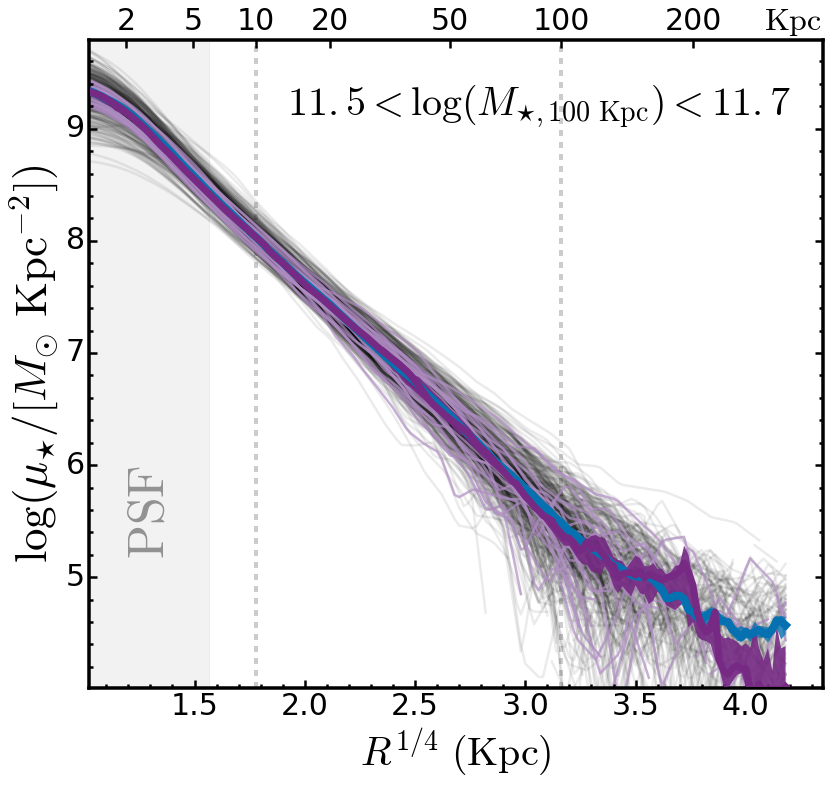

In [780]:
# --------------------------------------------------------------------------------------- #
## Setup up figure
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

########################################################################################
## Region affected by PSF
# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 6.0**0.25], [2.0, 2.0], [11.0, 11.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
## Mark the two interesting radius
# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

########################################################################################
## Individual profiles
for gg in gm1_sm:
    ax1.plot(RSMA_COMMON, gg, c='k', alpha=0.08, linewidth=2.5)
for bb in mm1_sm:
    ax1.plot(RSMA_COMMON, bb, c=PURPLE0, alpha=0.70, linewidth=2.5)

## Median profiles
ax1.fill_between(RSMA_COMMON, gm1_mm[0], gm1_mm[1], 
                 facecolor=BLUE1, edgecolor='none', alpha=0.8, zorder=1005)
ax1.fill_between(RSMA_COMMON, mm1_mm[0], mm1_mm[1], 
                 facecolor=PURPLE1, edgecolor='none', alpha=0.9, zorder=1005)

ax1.plot(RSMA_COMMON, gm1_mm[2], linestyle='-', linewidth=8.0, 
         c=BLUE1, alpha=1.0, zorder=1010)
#ax1.plot(RSMA_COMMON, gm1_mm[2], linestyle='--', linewidth=4.0, 
#         c=BLUE1, alpha=1.0, zorder=1010)

ax1.plot(RSMA_COMMON, mm1_mm[2], linestyle='-', linewidth=7.0, 
         c=PURPLE1, alpha=1.0, zorder=1010)
#ax1.plot(RSMA_COMMON, mm1_mm[2], linestyle='-.', linewidth=4.0, 
#         c=BROWN1, alpha=1.0, zorder=1010)

## Label the mass range
ax1.text(0.27, 0.86, '$11.5 < \log (M_{\star, 100\ \mathrm{Kpc}}) < 11.7$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=40.0, transform=ax1.transAxes, weight='heavy')

## X, Y Lables
ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=40)
ax1.set_ylabel('$\log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=45)

## Ticks
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
## Width of the axes
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

## Label the PSF region 
ax1.text(0.05, 0.20, '$\mathrm{PSF}$', rotation='vertical',
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=50.0, transform=ax1.transAxes, weight='bold', 
         color='k', alpha=0.4)

## X, Y limits
ax1.set_xlim(1.02, 4.35)
ax1.set_ylim(4.01, 9.79)

########################################################################################
# Secondary Axis 
ax2 = ax1.twiny()
kpcs = np.asarray([2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0])
kpcTicks= (kpcs ** 0.25)
ax2.set_xlim(1.02, 4.35)
ax2.set_ylim(4.01, 9.79)
ax2.set_xticks(kpcTicks)
ax2.set_xticklabels(['{:g}'.format(kpc) for kpc in kpcs], fontsize=30)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
ax2.text(0.92, 1.003, '$\mathrm{Kpc}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=32.0, transform=ax2.transAxes)

########################################################################################
plt.show()

fig.savefig('../figure/hscMassive_mprof_m1_mem_test.png', dpi=230)

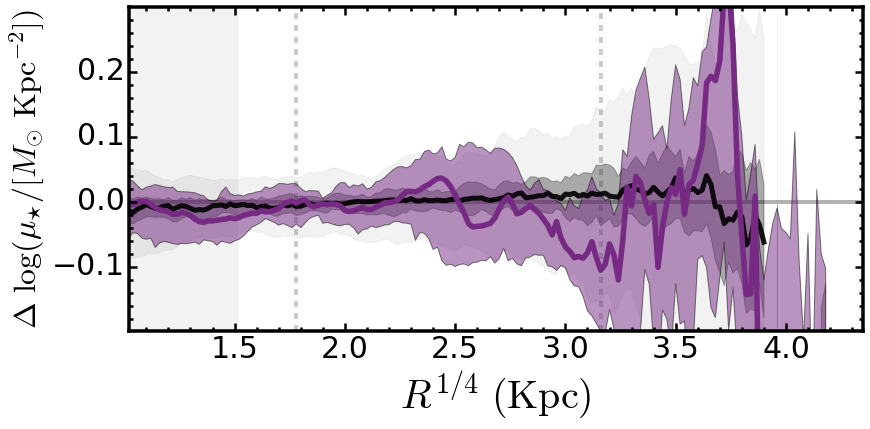

In [781]:
# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

ax1.axhline(0.0, linewidth=4.0, c='k', linestyle='-', zorder=0, alpha=0.3)

# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

# z = 0.2 : 1"=3.3 Kpc
#ax1.axvline(3.3 ** 0.25, linewidth=4.0, c='b', linestyle='--', alpha=0.2, zorder=0)
# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 5.2**0.25], [-2.0, -2.0], [2.0, 2.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
         
ax1.fill_between(RSMA_COMMON, 
                 np.percentile(randM1_sm - gm1_mm[2], 3, axis=0), 
                 np.percentile(randM1_sm - gm1_mm[2], 97, axis=0), 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
ax1.fill_between(RSMA_COMMON, 
                 np.percentile(randM1_sm - gm1_mm[2], 31, axis=0), 
                 np.percentile(randM1_sm - gm1_mm[2], 69, axis=0), 
                 facecolor='k', edgecolor='k', alpha=0.30, zorder=0)

ax1.plot(RSMA_COMMON, np.percentile(randM1_sm - gm1_mm[2], 50, axis=0), 
         c='k', linewidth=5.0, linestyle='-', alpha=0.9)

ax1.fill_between(RSMA_COMMON, 
                 (mm1_mm[0] - gm1_mm[1]), (mm1_mm[1] - gm1_mm[0]),
                 facecolor=PURPLE1, edgecolor='k', alpha=0.50, zorder=1)

ax1.plot(RSMA_COMMON, mm1_mm[2] - gm1_mm[2], c=PURPLE1, linewidth=5.5, 
         linestyle='-')
#ax1.plot(RSMA_COMMON, mm1b_mm[2] - gm1b_mm[2], c=PURPLE1, linewidth=6.0, 
#         linestyle='--')


#ax1.text(0.04, 0.84, '$11.4 < \log (M_{\star}) < 11.6$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=30.0, transform=ax1.transAxes)

ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=40)
ax1.set_ylabel('$\Delta\ \log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=32)

ax1.set_xlim(1.02, 4.35)
ax1.set_ylim(-0.199, 0.299)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

plt.show()

fig.savefig('../figure/hscMassive_dmprof_m1_mem_test.png', dpi=230)

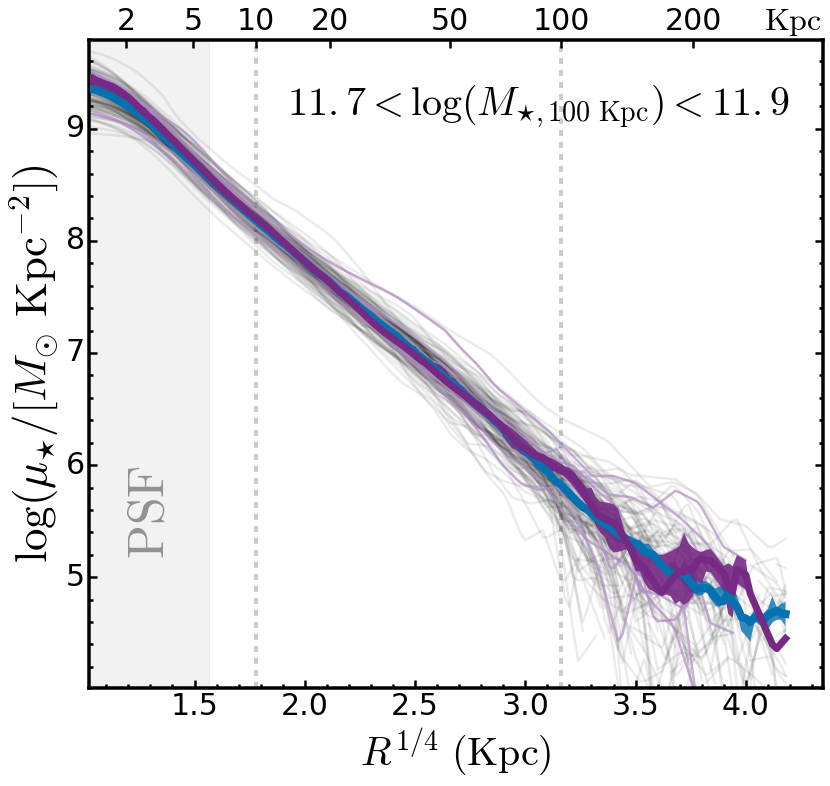

In [783]:
# --------------------------------------------------------------------------------------- #
## Setup up figure
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

########################################################################################
## Region affected by PSF
# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 6.0**0.25], [2.0, 2.0], [11.0, 11.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
## Mark the two interesting radius
# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

########################################################################################
## Individual profiles
for gg in gm2_sm:
    ax1.plot(RSMA_COMMON, gg, c='k', alpha=0.08, linewidth=2.5)
for bb in mm2_sm:
    ax1.plot(RSMA_COMMON, bb, c=PURPLE0, alpha=0.70, linewidth=2.5)

## Median profiles
ax1.fill_between(RSMA_COMMON, gm2_mm[0], gm2_mm[1], 
                 facecolor=BLUE1, edgecolor='none', alpha=0.8, zorder=1005)
ax1.fill_between(RSMA_COMMON, mm2_mm[0], mm2_mm[1], 
                 facecolor=PURPLE1, edgecolor='none', alpha=0.9, zorder=1005)

ax1.plot(RSMA_COMMON, gm2_mm[2], linestyle='-', linewidth=8.0, 
         c=BLUE1, alpha=1.0, zorder=1010)
#ax1.plot(RSMA_COMMON, gm2_mm[2], linestyle='--', linewidth=4.0, 
#         c=BLUE1, alpha=1.0, zorder=1010)

ax1.plot(RSMA_COMMON, mm2_mm[2], linestyle='-', linewidth=7.0, 
         c=PURPLE1, alpha=1.0, zorder=1010)
#ax1.plot(RSMA_COMMON, mm2_mm[2], linestyle='-.', linewidth=4.0, 
#         c=BROWN1, alpha=1.0, zorder=1010)

## Label the mass range
ax1.text(0.27, 0.86, '$11.7 < \log (M_{\star, 100\ \mathrm{Kpc}}) < 11.9$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=40.0, transform=ax1.transAxes, weight='heavy')

## X, Y Lables
ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=40)
ax1.set_ylabel('$\log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=45)

## Ticks
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
## Width of the axes
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

## Label the PSF region 
ax1.text(0.05, 0.20, '$\mathrm{PSF}$', rotation='vertical',
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=50.0, transform=ax1.transAxes, weight='bold', 
         color='k', alpha=0.4)

## X, Y limits
ax1.set_xlim(1.02, 4.35)
ax1.set_ylim(4.01, 9.79)

########################################################################################
# Secondary Axis 
ax2 = ax1.twiny()
kpcs = np.asarray([2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0])
kpcTicks= (kpcs ** 0.25)
ax2.set_xlim(1.02, 4.35)
ax2.set_ylim(4.01, 9.79)
ax2.set_xticks(kpcTicks)
ax2.set_xticklabels(['{:g}'.format(kpc) for kpc in kpcs], fontsize=30)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
ax2.text(0.92, 1.003, '$\mathrm{Kpc}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=32.0, transform=ax2.transAxes)

########################################################################################
plt.show()

fig.savefig('../figure/hscMassive_mprof_m2_mem_test.png', dpi=230)

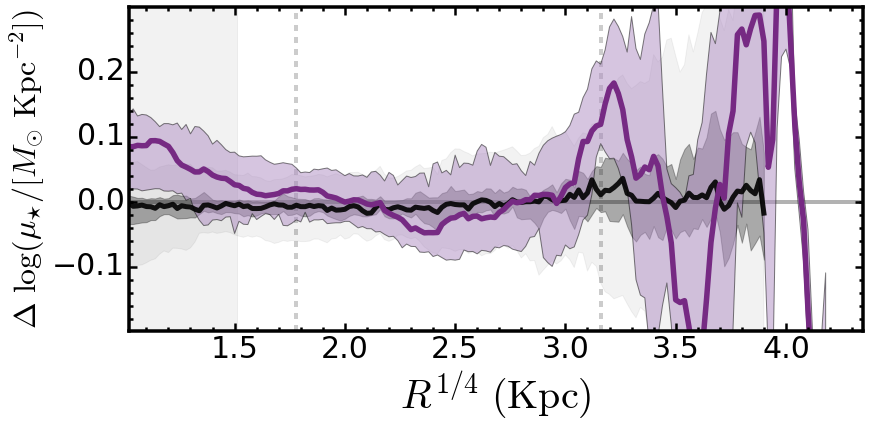

In [786]:
# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

ax1.axhline(0.0, linewidth=4.0, c='k', linestyle='-', zorder=0, alpha=0.3)

# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

# z = 0.2 : 1"=3.3 Kpc
#ax1.axvline(3.3 ** 0.25, linewidth=4.0, c='b', linestyle='--', alpha=0.2, zorder=0)
# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 5.2**0.25], [-2.0, -2.0], [2.0, 2.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
         
ax1.fill_between(RSMA_COMMON, 
                 np.percentile(randM2_sm - gm2_mm[2], 3, axis=0), 
                 np.percentile(randM2_sm - gm2_mm[2], 97, axis=0), 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
ax1.fill_between(RSMA_COMMON, 
                 np.percentile(randM2_sm - gm2_mm[2], 31, axis=0), 
                 np.percentile(randM2_sm - gm2_mm[2], 69, axis=0), 
                 facecolor='k', edgecolor='k', alpha=0.30, zorder=0)

ax1.plot(RSMA_COMMON, np.percentile(randM2_sm - gm2_mm[2], 50, axis=0), 
         c='k', linewidth=5.0, linestyle='-', alpha=0.9)

ax1.fill_between(RSMA_COMMON, 
                 (mm2_mm[0] - gm2_mm[1]), (mm2_mm[1] - gm2_mm[0]),
                 facecolor=PURPLE0, edgecolor='k', alpha=0.50, zorder=1)

ax1.plot(RSMA_COMMON, mm2_mm[2] - gm2_mm[2], c=PURPLE1, linewidth=5.5, 
         linestyle='-')
#ax1.plot(RSMA_COMMON, mm1b_mm[2] - gm1b_mm[2], c=PURPLE1, linewidth=6.0, 
#         linestyle='--')


#ax1.text(0.04, 0.84, '$11.4 < \log (M_{\star}) < 11.6$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=30.0, transform=ax1.transAxes)

ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=40)
ax1.set_ylabel('$\Delta\ \log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=32)

ax1.set_xlim(1.02, 4.35)
ax1.set_ylim(-0.199, 0.299)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

plt.show()

fig.savefig('../figure/hscMassive_dmprof_m2_mem_test.png', dpi=230)

# Central Mass Matched Samples

## 11.15 < logm(<10 Kpc) < 11.35

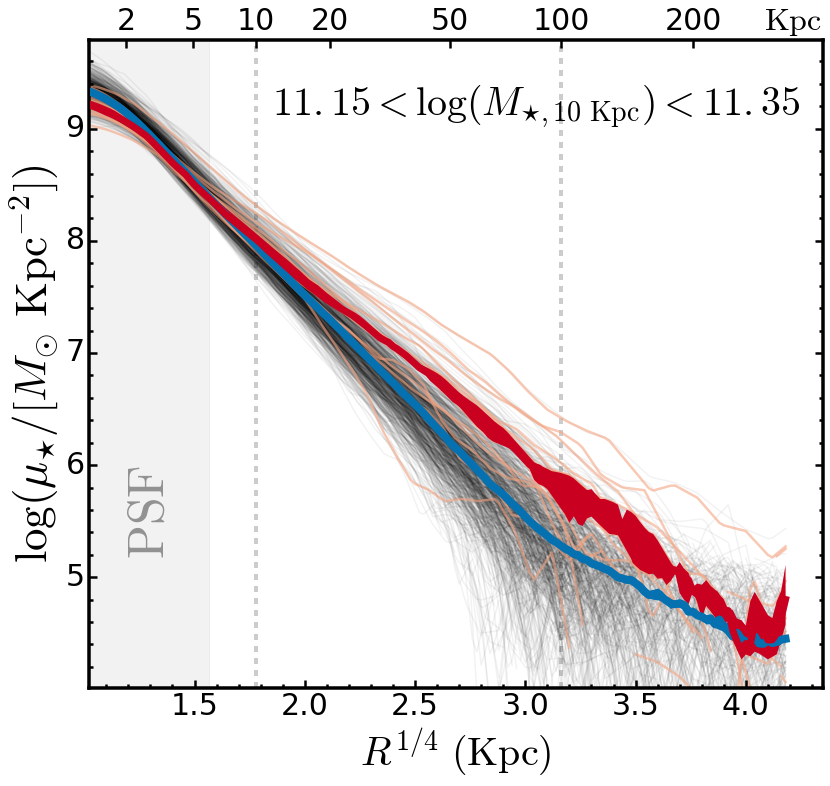

In [822]:
# --------------------------------------------------------------------------------------- #
## Setup up figure
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

########################################################################################
## Region affected by PSF
# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 6.0**0.25], [2.0, 2.0], [11.0, 11.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
## Mark the two interesting radius
# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

########################################################################################
## Individual profiles
for gg in gcm1b_sm:
    ax1.plot(RSMA_COMMON, gg, c='k', alpha=0.05, linewidth=1.5)
for bb in bcm1_sm:
    ax1.plot(RSMA_COMMON, bb, c=RED0, alpha=0.60, linewidth=2.5)

## Median profiles
ax1.fill_between(RSMA_COMMON, gcm1b_mm[0], gcm1b_mm[1], 
                 facecolor=BLUE1, edgecolor='none', alpha=1.0, zorder=1005)
ax1.fill_between(RSMA_COMMON, bcm1_mm[0], bcm1_mm[1], 
                 facecolor=RED1, edgecolor='none', alpha=1.0, zorder=1005)

ax1.plot(RSMA_COMMON, gcm1b_mm[2], linestyle='-', linewidth=8.0, 
         c=BLUE1, alpha=1.0, zorder=1010)
#ax1.plot(RSMA_COMMON, gcm1b_mm[2], linestyle='--', linewidth=4.0, 
#         c=BLUE1, alpha=1.0, zorder=1010)

ax1.plot(RSMA_COMMON, bcm1_mm[2], linestyle='-', linewidth=7.0, 
         c=RED1, alpha=1.0, zorder=1010)
#ax1.plot(RSMA_COMMON, bm1b_mm[2], linestyle='-.', linewidth=4.0, 
#         c=RED1, alpha=1.0, zorder=1010)

## Label the mass range
ax1.text(0.25, 0.86, '$11.15 < \log (M_{\star, 10\ \mathrm{Kpc}}) < 11.35$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=40.0, transform=ax1.transAxes, weight='heavy')

## X, Y Lables
ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=40)
ax1.set_ylabel('$\log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=45)

## Ticks
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
## Width of the axes
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

## Label the PSF region 
ax1.text(0.05, 0.20, '$\mathrm{PSF}$', rotation='vertical',
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=50.0, transform=ax1.transAxes, weight='bold', 
         color='k', alpha=0.4)

## X, Y limits
ax1.set_xlim(1.02, 4.35)
ax1.set_ylim(4.01, 9.79)

########################################################################################
# Secondary Axis 
ax2 = ax1.twiny()
kpcs = np.asarray([2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0])
kpcTicks= (kpcs ** 0.25)
ax2.set_xlim(1.02, 4.35)
ax2.set_ylim(4.01, 9.79)
ax2.set_xticks(kpcTicks)
ax2.set_xticklabels(['{:g}'.format(kpc) for kpc in kpcs], fontsize=30)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
ax2.text(0.92, 1.003, '$\mathrm{Kpc}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=32.0, transform=ax2.transAxes)

########################################################################################
plt.show()

fig.savefig('../figure/hscMassive_mprof_cm1_test.png', dpi=230)

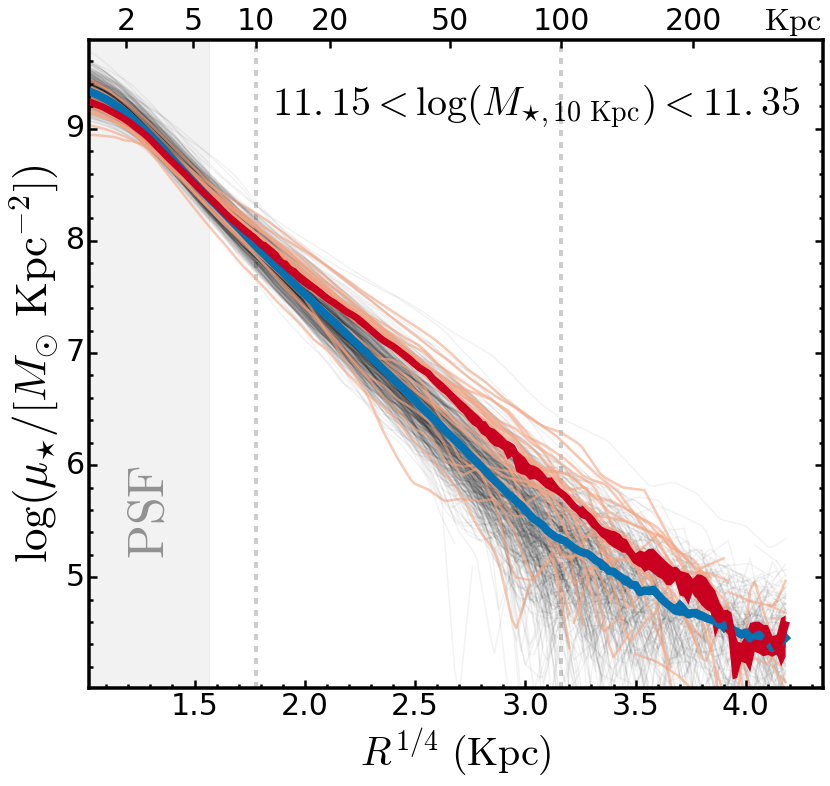

In [823]:
# --------------------------------------------------------------------------------------- #
## Setup up figure
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

########################################################################################
## Region affected by PSF
# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 6.0**0.25], [2.0, 2.0], [11.0, 11.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
## Mark the two interesting radius
# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

########################################################################################
## Individual profiles
for gg in gcm1c_sm:
    ax1.plot(RSMA_COMMON, gg, c='k', alpha=0.05, linewidth=1.5)
for bb in bcm1c_sm:
    ax1.plot(RSMA_COMMON, bb, c=RED0, alpha=0.60, linewidth=2.5)

## Median profiles
ax1.fill_between(RSMA_COMMON, gcm1c_mm[0], gcm1c_mm[1], 
                 facecolor=BLUE1, edgecolor='none', alpha=1.0, zorder=1005)
ax1.fill_between(RSMA_COMMON, bcm1c_mm[0], bcm1c_mm[1], 
                 facecolor=RED1, edgecolor='none', alpha=1.0, zorder=1005)

ax1.plot(RSMA_COMMON, gcm1c_mm[2], linestyle='-', linewidth=8.0, 
         c=BLUE1, alpha=1.0, zorder=1010)
#ax1.plot(RSMA_COMMON, gcm1b_mm[2], linestyle='--', linewidth=4.0, 
#         c=BLUE1, alpha=1.0, zorder=1010)

ax1.plot(RSMA_COMMON, bcm1c_mm[2], linestyle='-', linewidth=7.0, 
         c=RED1, alpha=1.0, zorder=1010)
#ax1.plot(RSMA_COMMON, bm1b_mm[2], linestyle='-.', linewidth=4.0, 
#         c=RED1, alpha=1.0, zorder=1010)

## Label the mass range
ax1.text(0.25, 0.86, '$11.15 < \log (M_{\star, 10\ \mathrm{Kpc}}) < 11.35$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=40.0, transform=ax1.transAxes, weight='heavy')

## X, Y Lables
ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=40)
ax1.set_ylabel('$\log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=45)

## Ticks
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
## Width of the axes
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

## Label the PSF region 
ax1.text(0.05, 0.20, '$\mathrm{PSF}$', rotation='vertical',
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=50.0, transform=ax1.transAxes, weight='bold', 
         color='k', alpha=0.4)

## X, Y limits
ax1.set_xlim(1.02, 4.35)
ax1.set_ylim(4.01, 9.79)

########################################################################################
# Secondary Axis 
ax2 = ax1.twiny()
kpcs = np.asarray([2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0])
kpcTicks= (kpcs ** 0.25)
ax2.set_xlim(1.02, 4.35)
ax2.set_ylim(4.01, 9.79)
ax2.set_xticks(kpcTicks)
ax2.set_xticklabels(['{:g}'.format(kpc) for kpc in kpcs], fontsize=30)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
ax2.text(0.92, 1.003, '$\mathrm{Kpc}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=32.0, transform=ax2.transAxes)

########################################################################################
plt.show()

fig.savefig('../figure/hscMassive_mprof_cm1b_test.png', dpi=230)

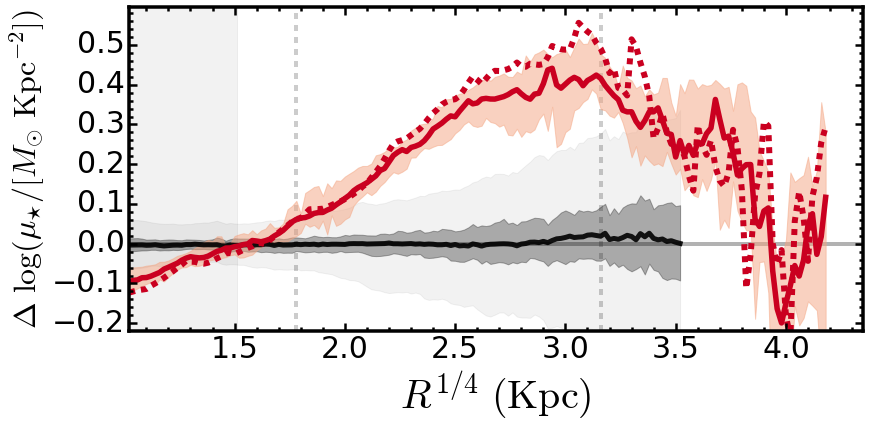

In [824]:
# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

ax1.axhline(0.0, linewidth=4.0, c='k', linestyle='-', zorder=0, alpha=0.3)

# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

# z = 0.2 : 1"=3.3 Kpc
#ax1.axvline(3.3 ** 0.25, linewidth=4.0, c='b', linestyle='--', alpha=0.2, zorder=0)
# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 5.2**0.25], [-2.0, -2.0], [2.0, 2.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
         
ax1.fill_between(RSMA_COMMON, 
                 np.percentile(randCM1_sm - gcm1_mm[2], 3, axis=0), 
                 np.percentile(randCM1_sm - gcm1_mm[2], 97, axis=0), 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
ax1.fill_between(RSMA_COMMON, 
                 np.percentile(randCM1_sm - gcm1_mm[2], 31, axis=0), 
                 np.percentile(randCM1_sm - gcm1_mm[2], 69, axis=0), 
                 facecolor='k', edgecolor='k', alpha=0.30, zorder=0)

ax1.plot(RSMA_COMMON, np.percentile(randCM1_sm - gcm1_mm[2], 50, axis=0), 
         c='k', linewidth=5.0, linestyle='-', alpha=0.9)

ax1.fill_between(RSMA_COMMON, 
                 (bcm1c_mm[0] - gcm1c_mm[1]), (bcm1c_mm[1] - gcm1c_mm[0]),
                 facecolor=RED0, edgecolor=RED0, alpha=0.50, zorder=1)

ax1.plot(RSMA_COMMON, bcm1c_mm[2] - gcm1c_mm[2], c=RED1, linewidth=5.5, 
         linestyle='-')

ax1.plot(RSMA_COMMON, bcm1b_mm[2] - gcm1b_mm[2], c=RED1, linewidth=6.0, 
         linestyle='--')

#ax1.text(0.04, 0.84, '$11.4 < \log (M_{\star}) < 11.6$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=30.0, transform=ax1.transAxes)

ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=40)
ax1.set_ylabel('$\Delta\ \log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=32)

ax1.set_xlim(1.02, 4.35)
ax1.set_ylim(-0.22, 0.595)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

plt.show()

fig.savefig('../figure/hscMassive_dmprof_cm1_test.png', dpi=230)

## 11.35 < logM(<10 Kpc) < 11.55

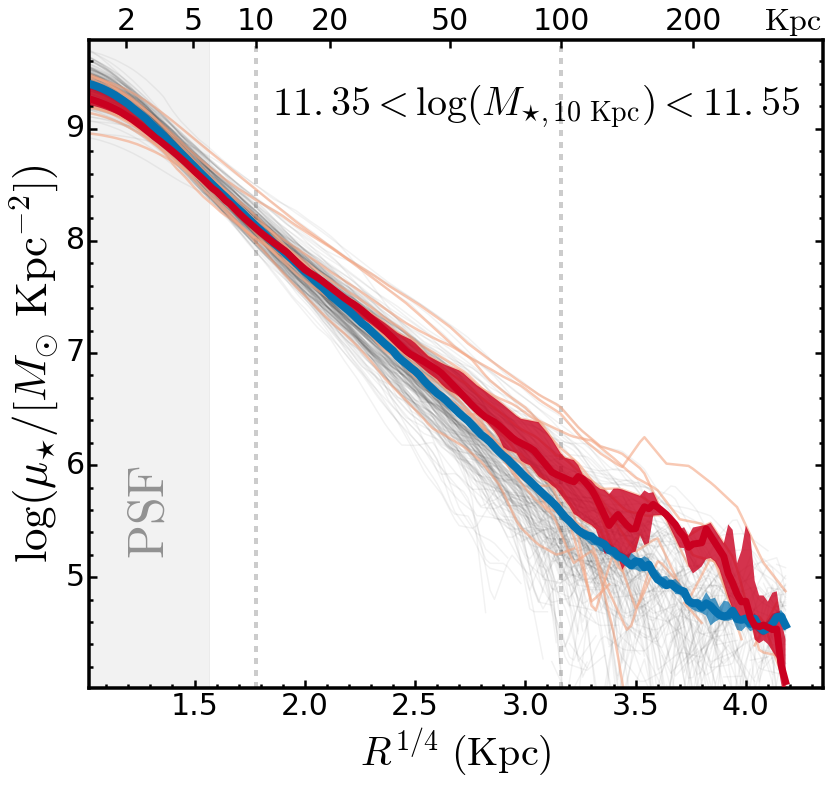

In [826]:
# --------------------------------------------------------------------------------------- #
## Setup up figure
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

########################################################################################
## Region affected by PSF
# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 6.0**0.25], [2.0, 2.0], [11.0, 11.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
## Mark the two interesting radius
# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

########################################################################################
## Individual profiles
for gg in gcm2_sm:
    ax1.plot(RSMA_COMMON, gg, c='k', alpha=0.05, linewidth=1.5)
for bb in bcm2_sm:
    ax1.plot(RSMA_COMMON, bb, c=RED0, alpha=0.60, linewidth=2.5)

## Median profiles
ax1.fill_between(RSMA_COMMON, gcm2_mm[0], gcm2_mm[1], 
                 facecolor=BLUE1, edgecolor='none', alpha=0.7, zorder=1005)
ax1.fill_between(RSMA_COMMON, bcm2_mm[0], bcm2_mm[1], 
                 facecolor=RED1, edgecolor='none', alpha=0.8, zorder=1005)

ax1.plot(RSMA_COMMON, gcm2_mm[2], linestyle='-', linewidth=8.0, 
         c=BLUE1, alpha=1.0, zorder=1010)
#ax1.plot(RSMA_COMMON, gcm2_mm[2], linestyle='--', linewidth=4.0, 
#         c=BLUE1, alpha=1.0, zorder=1010)

ax1.plot(RSMA_COMMON, bcm2_mm[2], linestyle='-', linewidth=7.0, 
         c=RED1, alpha=1.0, zorder=1010)
#ax1.plot(RSMA_COMMON, bm1b_mm[2], linestyle='-.', linewidth=4.0, 
#         c=RED1, alpha=1.0, zorder=1010)

## Label the mass range
ax1.text(0.25, 0.86, '$11.35 < \log (M_{\star, 10\ \mathrm{Kpc}}) < 11.55$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=40.0, transform=ax1.transAxes, weight='heavy')

## X, Y Lables
ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=40)
ax1.set_ylabel('$\log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=45)

## Ticks
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
## Width of the axes
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

## Label the PSF region 
ax1.text(0.05, 0.20, '$\mathrm{PSF}$', rotation='vertical',
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=50.0, transform=ax1.transAxes, weight='bold', 
         color='k', alpha=0.4)

## X, Y limits
ax1.set_xlim(1.02, 4.35)
ax1.set_ylim(4.01, 9.79)

########################################################################################
# Secondary Axis 
ax2 = ax1.twiny()
kpcs = np.asarray([2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0])
kpcTicks= (kpcs ** 0.25)
ax2.set_xlim(1.02, 4.35)
ax2.set_ylim(4.01, 9.79)
ax2.set_xticks(kpcTicks)
ax2.set_xticklabels(['{:g}'.format(kpc) for kpc in kpcs], fontsize=30)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
ax2.text(0.92, 1.003, '$\mathrm{Kpc}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=32.0, transform=ax2.transAxes)

########################################################################################
plt.show()

fig.savefig('../figure/hscMassive_mprof_cm2_test.png', dpi=230)

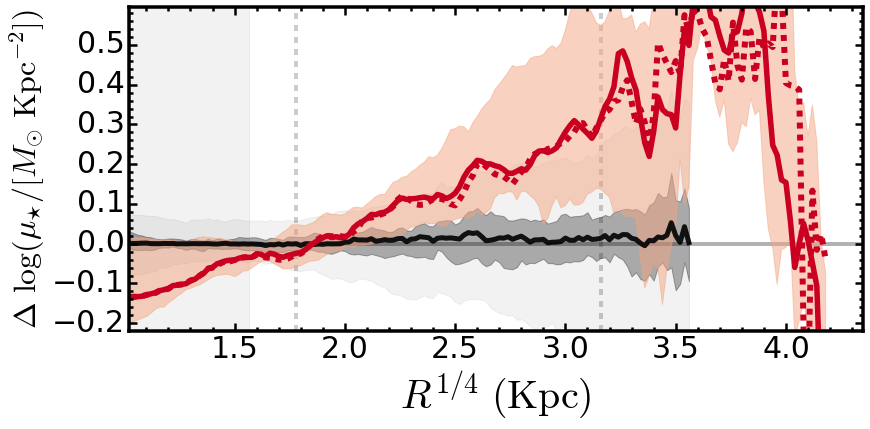

In [827]:
# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

ax1.axhline(0.0, linewidth=4.0, c='k', linestyle='-', zorder=0, alpha=0.3)

# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

# z = 0.2 : 1"=3.3 Kpc
#ax1.axvline(3.3 ** 0.25, linewidth=4.0, c='b', linestyle='--', alpha=0.2, zorder=0)
# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 6.0**0.25], [-2.0, -2.0], [2.0, 2.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
         
ax1.fill_between(RSMA_COMMON, 
                 np.percentile(randCM2_sm - gcm2_mm[2], 3, axis=0), 
                 np.percentile(randCM2_sm - gcm2_mm[2], 97, axis=0), 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
ax1.fill_between(RSMA_COMMON, 
                 np.percentile(randCM2_sm - gcm2_mm[2], 31, axis=0), 
                 np.percentile(randCM2_sm - gcm2_mm[2], 69, axis=0), 
                 facecolor='k', edgecolor='k', alpha=0.30, zorder=0)

ax1.plot(RSMA_COMMON, np.percentile(randCM2_sm - gcm2_mm[2], 50, axis=0), 
         c='k', linewidth=5.0, linestyle='-', alpha=0.9)

ax1.fill_between(RSMA_COMMON, 
                 (bcm2_mm[0] - gcm2_mm[1]), (bcm2_mm[1] - gcm2_mm[0]),
                 facecolor=RED0, edgecolor=RED0, alpha=0.50, zorder=1)

ax1.plot(RSMA_COMMON, bcm2_mm[2] - gcm2_mm[2], c=RED1, linewidth=5.5, 
         linestyle='-')

ax1.plot(RSMA_COMMON, bcm2b_mm[2] - gcm2b_mm[2], c=RED1, linewidth=6.0, 
         linestyle='--')


#ax1.text(0.04, 0.84, '$11.4 < \log (M_{\star}) < 11.6$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=30.0, transform=ax1.transAxes)

ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=40)
ax1.set_ylabel('$\Delta\ \log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=32)

ax1.set_xlim(1.02, 4.35)
ax1.set_ylim(-0.22, 0.595)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

plt.show()

fig.savefig('../figure/hscMassive_dmprof_cm2_test.png', dpi=230)

# Ellipticity profiles

In [810]:
#### M1, no-normalization 
indEllip = np.intersect1d(np.where(RSMA_COMMON >= 1.0)[0], 
                          np.where(RSMA_COMMON <= 3.8)[0])

# GAMA M1a 
gm1_se, gm1_me, gm1_ae, gm1_de = organizeSbp(prof_gama_m1, col1='ell', col2=None, 
                                             kind='sbp', index=indEllip)
# BCG M1a 
bm1_se, bm1_me, bm1_ae, bm1_de = organizeSbp(prof_bcg_m1, col1='ell', col2=None, 
                                             kind='sbp', index=indEllip)

# GAMA M1a 
gm2_se, gm2_me, gm2_ae, gm2_de = organizeSbp(prof_gama_m2, col1='ell', col2=None, 
                                             kind='sbp', index=indEllip)
# BCG M1a 
bm2_se, bm2_me, bm2_ae, bm2_de = organizeSbp(prof_bcg_m2, col1='ell', col2=None, 
                                             kind='sbp', index=indEllip)

## NO KCORRECTION APPLIED !!
## NO KCORRECTION APPLIED !!
## NO KCORRECTION APPLIED !!
## NO KCORRECTION APPLIED !!


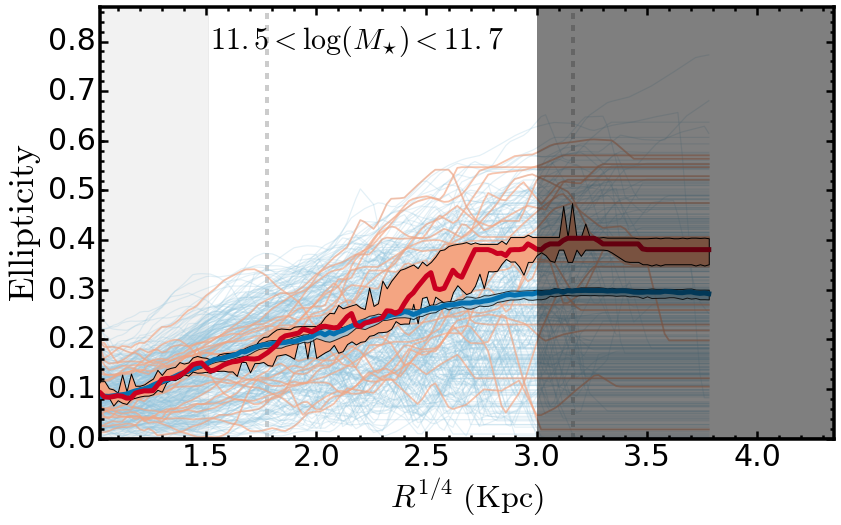

In [811]:
# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

ax1.axhline(0.0, linewidth=4.0, c='k', linestyle='-', zorder=0, alpha=0.3)

# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

# z = 0.2 : 1"=3.3 Kpc
#ax1.axvline(3.3 ** 0.25, linewidth=4.0, c='b', linestyle='--', alpha=0.2, zorder=0)
# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 5.2**0.25], [-2.0, -2.0], [2.0, 2.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)

for i, gg in enumerate(gm1_se):
    if np.nanmax(gg[RSMA_COMMON[indEllip] <= 2.1]) <= 0.4:
        ax1.plot(RSMA_COMMON[indEllip], gg, c=BLUE0, alpha=0.25, linewidth=1.2)
    else:
        np.delete(gm1_se, i)
for j, bb in enumerate(bm1_se):
    if np.nanmax(bb[RSMA_COMMON[indEllip] <= 2.1]) <= 0.4:
        ax1.plot(RSMA_COMMON[indEllip], bb, c=RED0, alpha=0.65, linewidth=1.8)
    else:
        np.delete(bm1_se, j)
        
ax1.fill_between(RSMA_COMMON[indEllip], bm1_me[0], bm1_me[1], 
                 facecolor=RED0, edgecolor='k', alpha=1.0, zorder=1005)
ax1.fill_between(RSMA_COMMON[indEllip], gm1_me[0], gm1_me[1], 
                 facecolor=BLUE0, edgecolor='k', alpha=0.8, zorder=1005)

ax1.plot(RSMA_COMMON[indEllip], gm1_me[2], linestyle='-', linewidth=5.0, 
         c=BLUE1, alpha=1.0, zorder=1010)
ax1.plot(RSMA_COMMON[indEllip], bm1_me[2], linestyle='-', linewidth=5.0, 
         c=RED1, alpha=1.0, zorder=1010)
ax1.fill_between([3.0, 4.5], [-0.1, -0.1], [1.1, 1.1], 
                 facecolor='k', edgecolor='none', alpha=0.5, zorder=2000)

ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=32)
ax1.set_ylabel('$\mathrm{Ellipticity}$', size=36)

ax1.set_xlim(1.02, 4.35)
ax1.set_ylim(-0.0, 0.87)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

ax1.text(0.15, 0.88, '$11.5 < \log (M_{\star}) < 11.7$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=30.0, transform=ax1.transAxes)

plt.show()

fig.savefig('../figure/hscMassive_eprof_m1_test.png', dpi=230)

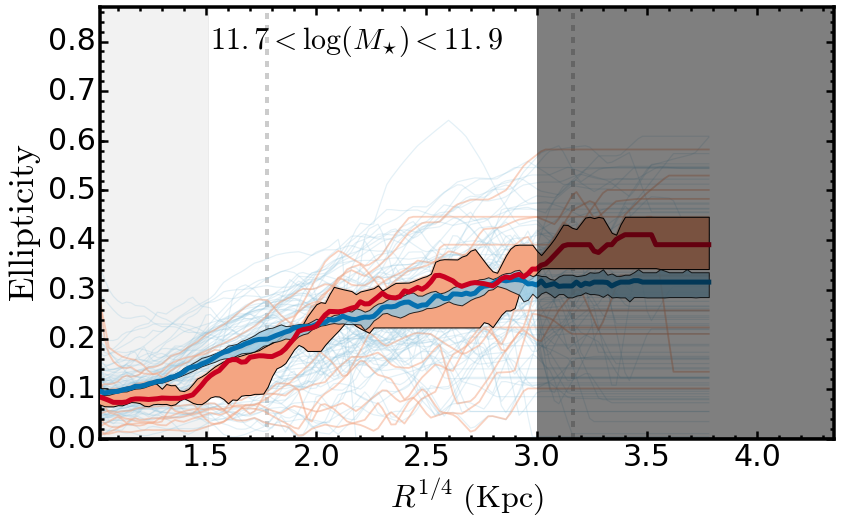

In [812]:
# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

ax1.axhline(0.0, linewidth=4.0, c='k', linestyle='-', zorder=0, alpha=0.3)

# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

# z = 0.2 : 1"=3.3 Kpc
#ax1.axvline(3.3 ** 0.25, linewidth=4.0, c='b', linestyle='--', alpha=0.2, zorder=0)
# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 5.2**0.25], [-2.0, -2.0], [2.0, 2.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)

for i, gg in enumerate(gm2_se):
    if np.nanmax(gg[RSMA_COMMON[indEllip] <= 2.1]) <= 0.4:
        ax1.plot(RSMA_COMMON[indEllip], gg, c=BLUE0, alpha=0.25, linewidth=1.2)
    else:
        np.delete(gm2_se, i)
for j, bb in enumerate(bm2_se):
    if np.nanmax(bb[RSMA_COMMON[indEllip] <= 2.1]) <= 0.4:
        ax1.plot(RSMA_COMMON[indEllip], bb, c=RED0, alpha=0.50, linewidth=1.8)
    else:
        np.delete(bm2_se, j)
        
ax1.fill_between(RSMA_COMMON[indEllip], bm2_me[0], bm2_me[1], 
                 facecolor=RED0, edgecolor='k', alpha=1.0, zorder=1005)
ax1.fill_between(RSMA_COMMON[indEllip], gm2_me[0], gm2_me[1], 
                 facecolor=BLUE0, edgecolor='k', alpha=0.8, zorder=1005)

ax1.plot(RSMA_COMMON[indEllip], gm2_me[2], linestyle='-', linewidth=5.0, 
         c=BLUE1, alpha=1.0, zorder=1010)
ax1.plot(RSMA_COMMON[indEllip], bm2_me[2], linestyle='-', linewidth=5.0, 
         c=RED1, alpha=1.0, zorder=1010)
ax1.fill_between([3.0, 4.5], [-0.1, -0.1], [1.1, 1.1], 
                 facecolor='k', edgecolor='none', alpha=0.5, zorder=2000)

ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=32)
ax1.set_ylabel('$\mathrm{Ellipticity}$', size=36)

ax1.set_xlim(1.02, 4.35)
ax1.set_ylim(-0.0, 0.87)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

ax1.text(0.15, 0.88, '$11.7 < \log (M_{\star}) < 11.9$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=30.0, transform=ax1.transAxes)

plt.show()

fig.savefig('../figure/hscMassive_eprof_m2_test.png', dpi=230)

# Color profiles

In [405]:
# GAMA M1
gm1_sG, gm1_mG, gm1_aG, gm1_dG = organizeSbp(prof_gama_m1, 
                                             col1='muG3', col2='KCORRECT_c_G', kind='sbp')
gm1_sR, gm1_mR, gm1_aR, gm1_dR = organizeSbp(prof_gama_m1, 
                                             col1='muR3', col2='KCORRECT_c_R', kind='sbp')
gm1_sI, gm1_mI, gm1_aI, gm1_dI = organizeSbp(prof_gama_m1, 
                                             col1='muI3', col2='KCORRECT_c_I', kind='sbp')

# BCG M1
bm1_sG, bm1_mG, bm1_aG, bm1_dG = organizeSbp(prof_bcg_m1, 
                                             col1='muG3', col2='KCORRECT_c_G', kind='sbp')
bm1_sR, bm1_mR, bm1_aR, bm1_dR = organizeSbp(prof_bcg_m1, 
                                             col1='muR3', col2='KCORRECT_c_R', kind='sbp')
bm1_sI, bm1_mI, bm1_aI, bm1_dI = organizeSbp(prof_bcg_m1, 
                                             col1='muI3', col2='KCORRECT_c_I', kind='sbp')

In [406]:
# GAMA M2
gm2_sG, gm2_mG, gm2_aG, gm2_dG = organizeSbp(prof_gama_m2, 
                                             col1='muG3', col2='KCORRECT_c_G', kind='sbp')
gm2_sR, gm2_mR, gm2_aR, gm2_dR = organizeSbp(prof_gama_m2, 
                                             col1='muR3', col2='KCORRECT_c_R', kind='sbp')
gm2_sI, gm2_mI, gm2_aI, gm2_dI = organizeSbp(prof_gama_m2, 
                                             col1='muI3', col2='KCORRECT_c_I', kind='sbp')

# BCG M2
bm2_sG, bm2_mG, bm2_aG, bm2_dG = organizeSbp(prof_bcg_m2, 
                                             col1='muG3', col2='KCORRECT_c_G', kind='sbp')
bm2_sR, bm2_mR, bm2_aR, bm2_dR = organizeSbp(prof_bcg_m2, 
                                             col1='muR3', col2='KCORRECT_c_R', kind='sbp')
bm2_sI, bm2_mI, bm2_aI, bm2_dI = organizeSbp(prof_bcg_m2, 
                                             col1='muI3', col2='KCORRECT_c_I', kind='sbp')

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in subtract


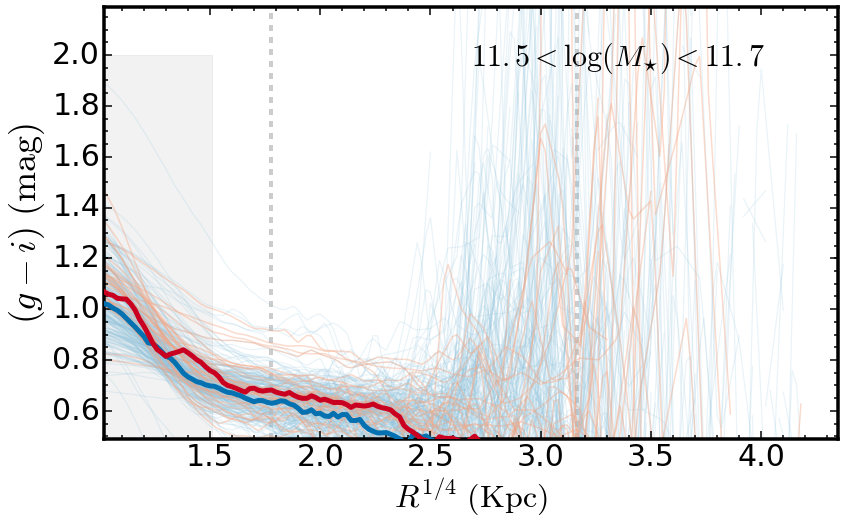

In [412]:
# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

# z = 0.2 : 1"=3.3 Kpc
#ax1.axvline(3.3 ** 0.25, linewidth=4.0, c='b', linestyle='--', alpha=0.2, zorder=0)
# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 5.2**0.25], [-2.0, -2.0], [2.0, 2.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)

for gG, gI in zip(gm1_sG, gm1_sI):
    ax1.plot(RSMA_COMMON, (gI-gG) * 2.5, c=BLUE0, alpha=0.20, linewidth=1.2)
for bG, bI in zip(bm1_sG, bm1_sI):
    ax1.plot(RSMA_COMMON, (bI-bG) * 2.5, c=RED0, alpha=0.40, linewidth=1.5)

#ax1.fill_between(RSMA_COMMON, (gm1_mc[0], gm1_mc[1], 
#                 facecolor='k', alpha=0.8, zorder=1005)
#ax1.fill_between(RSMA_COMMON, bm1_mc[0], bm1_mc[1], 
#                 facecolor='r', alpha=0.8, zorder=1005)
ax1.plot(RSMA_COMMON, (gm1_mI[2]-gm1_mG[2]) * 2.5, linestyle='-', linewidth=5.0, 
         c=BLUE1, alpha=1.0, zorder=1010)
ax1.plot(RSMA_COMMON, (bm1_mI[2]-bm1_mG[2]) * 2.5, linestyle='-', linewidth=5.0, 
         c=RED1, alpha=1.0, zorder=1010)

ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=32)
ax1.set_ylabel('$(g-i)\ \mathrm{(mag)}$', size=36)

ax1.set_xlim(1.02, 4.35)
ax1.set_ylim(0.49, 2.19)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

ax1.text(0.50, 0.84, '$11.5 < \log (M_{\star}) < 11.7$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=30.0, transform=ax1.transAxes)

plt.show()

#fig.savefig('../figure/hscMassive_cprof_m1_test.png', dpi=230)

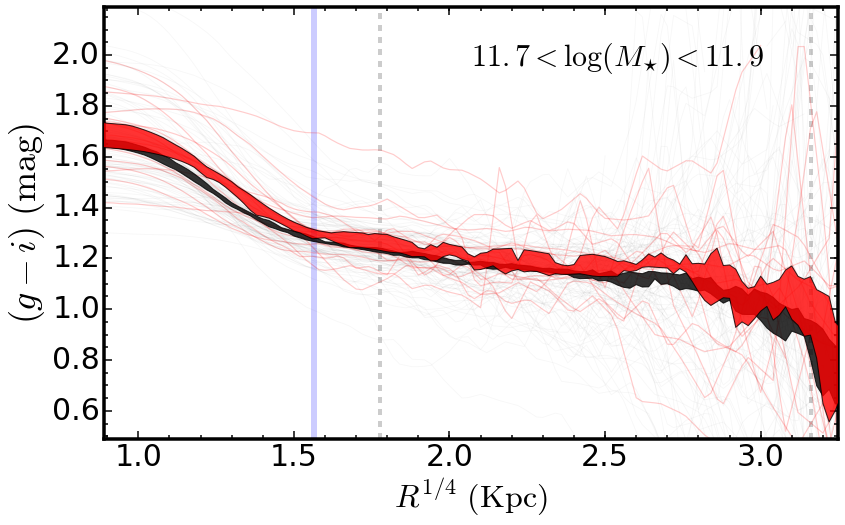

In [340]:
# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

# z = 0.2 : 1"=3.3 Kpc
#ax1.axvline(3.3 ** 0.25, linewidth=4.0, c='b', linestyle='--', alpha=0.2, zorder=0)
# z = 0.4 : 1"=5.4 Kpc
ax1.axvline(6.0 ** 0.25, linewidth=6.0, c='b', linestyle='-', alpha=0.2, 
            zorder=0)

for gg in gm2_sc:
    ax1.plot(RSMA_COMMON, gg, c='k', alpha=0.03, linewidth=0.9)
for bb in bm2_sc:
    ax1.plot(RSMA_COMMON, bb, c='r', alpha=0.20, linewidth=1.2)

# M1
ax1.fill_between(RSMA_COMMON, gm2_mc[0], gm2_mc[1], 
                 facecolor='k', alpha=0.8, zorder=1005)
ax1.fill_between(RSMA_COMMON, bm2_mc[0], bm2_mc[1], 
                 facecolor='r', alpha=0.8, zorder=1005)

ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=32)
ax1.set_ylabel('$(g-i)\ \mathrm{(mag)}$', size=36)

ax1.set_xlim(0.89, 3.25)
ax1.set_ylim(0.49, 2.19)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

ax1.text(0.50, 0.84, '$11.7 < \log (M_{\star}) < 11.9$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=30.0, transform=ax1.transAxes)

plt.show()

fig.savefig('../figure/hscMassive_cprof_m2_test.png', dpi=230)